In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import json
import re
from typing import List
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 

# ETL INTERNET

In [3]:
#Internet= pd.read_excel('Internet.xlsx')
#print(np.shape(Internet))
#Internet.head(2)
internet = pd.read_excel('Internet.xlsx', sheet_name=None)

# Mostrar los nombres de las hojas
print(internet.keys())



dict_keys(['Acc_vel_loc_sinrangos', 'Velocidad_sin_Rangos', 'Accesos_tecnologia_localidad', 'Velocidad % por prov', 'Totales VMD', 'Totales Accesos Por Tecnología', 'Accesos Por Tecnología', 'Penetración-poblacion', 'Penetracion-hogares', 'Penetracion-totales', 'Totales Accesos por velocidad', 'Accesos por velocidad', 'Dial-BAf', 'Totales Dial-BAf', 'Ingresos '])


In [4]:
def identify_column_formats(df):
    column_formats = {}
    
    for column in df.columns:
        sample_value = df[column].dropna().iloc[0]  # Tomamos el primer valor no nulo como muestra
        
        if isinstance(sample_value, str):
            try:
                json.loads(sample_value)  # Verificamos si es JSON
                column_formats[column] = 'JSON'
            except (json.JSONDecodeError, TypeError):
                if ',' in sample_value:
                    column_formats[column] = 'Lista (cadena)'
                else:
                    column_formats[column] = 'Cadena de texto'
        elif isinstance(sample_value, int):
            column_formats[column] = 'int'
        elif isinstance(sample_value, float):
            column_formats[column] = 'float'
        elif isinstance(sample_value, dict):
            column_formats[column] = 'dict'
        elif isinstance(sample_value, list):
            column_formats[column] = 'list'
        else:
            column_formats[column] = type(sample_value).__name__
        
    return column_formats

In [5]:
# funcion para convertir mayusculas en minusculas con la primera letra de cada palabra en mayudcula

def convertir_mayusculas_a_minusculas(df, columna):
    # Verificar que la columna exista en el DataFrame
    if columna not in df.columns:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")
    
    # Aplicar la transformación a cada valor de la columna
    df[columna] = df[columna].str.title()

    return df

In [6]:
def convert_floats_to_ints(df, fill_value=0):
    # Llenar valores NaN o inf con un valor predeterminado
    df = df.fillna(fill_value)
    df = df.replace([np.inf, -np.inf], fill_value)
    
    # Convertir todas las columnas de tipo float a int
    df = df.apply(lambda x: x.astype(int) if x.dtype == 'float' else x)
    return df

____________________________________________________________________________________________________________________________________________________

In [7]:
# Función para identificar y mostrar los valores nulos
def show_null_values(df):
    for column in df.columns:
        null_values = df[df[column].isnull()][column]
        if not null_values.empty:
            print(f"Columna: {column}")
            print("Valores nulos encontrados:")
            print(null_values)
            print()

____________________________________________________________________________________________________________________________________________________

### TABLA % de Velocidad

Velocidad % por prov: Presenta el porcentaje de accesos a internet por rangos de velocidad en cada provincia.


In [8]:
velocidad_porcentaje_por_prov = internet['Velocidad % por prov']
velocidad_porcentaje_por_prov.head()

Año  Trimestre        Provincia  Mbps (Media de bajada)
0  2024          1     Buenos Aires                  159.13
1  2024          1  Capital Federal                  229.94
2  2024          1        Catamarca                   91.45
3  2024          1            Chaco                  107.51
4  2024          1           Chubut                   20.50

In [9]:
formatos = identify_column_formats(velocidad_porcentaje_por_prov)
print(formatos)

{'Año': 'int64', 'Trimestre': 'int64', 'Provincia': 'Cadena de texto', 'Mbps (Media de bajada)': 'float'}


In [10]:
velocidad_porcentaje_por_prov.isnull().sum()

Año                       0
Trimestre                 0
Provincia                 0
Mbps (Media de bajada)    0
dtype: int64

____________________________________________________________________________________________________________________________________________________

### TABLA accesos por tecnologia

Accesos Por Tecnología: Detalla los accesos a internet por tecnología en diferentes provincias.


In [11]:
Accesos_Por_Tecnología=internet['Accesos Por Tecnología']
Accesos_Por_Tecnología.head()

Año Trimestre        Provincia      ADSL  Cablemodem  Fibra óptica  \
0  2024         1     Buenos Aires  203297.0   2790663.0     1799013.0   
1  2024         1  Capital Federal   70108.0   1177475.0      203756.0   
2  2024         1        Catamarca    5901.0     11025.0       56542.0   
3  2024         1            Chaco   11343.0     58929.0       64463.0   
4  2024         1           Chubut   26306.0     77217.0       26356.0   

   Wireless     Otros      Total  
0  150290.0  101294.0  5044557.0  
1    4493.0   48879.0  1504711.0  
2    1384.0      81.0    74933.0  
3    8404.0   12404.0   155543.0  
4   30867.0    9930.0   170676.0

In [12]:
formatos = identify_column_formats(Accesos_Por_Tecnología)
print(formatos)

{'Año': 'int', 'Trimestre': 'int', 'Provincia': 'Cadena de texto', 'ADSL': 'float', 'Cablemodem': 'float', 'Fibra óptica': 'float', 'Wireless': 'float', 'Otros': 'float', 'Total': 'float'}


In [13]:
Accesos_Por_Tecnología=convert_floats_to_ints(Accesos_Por_Tecnología)

In [14]:
# Eliminar las filas con valores nulos
Accesos_Por_Tecnología=Accesos_Por_Tecnología.dropna()

In [15]:
Accesos_Por_Tecnología.count()

Año             986
Trimestre       986
Provincia       986
ADSL            986
Cablemodem      986
Fibra óptica    986
Wireless        986
Otros           986
Total           986
dtype: int64

In [16]:
Accesos_Por_Tecnología.isnull().sum()

Año             0
Trimestre       0
Provincia       0
ADSL            0
Cablemodem      0
Fibra óptica    0
Wireless        0
Otros           0
Total           0
dtype: int64

____________________________________________________________________________________________________________________________________________________

### TABLA accesos por velocidad

Accesos por velocidad: Detalla los accesos a internet desglosados por velocidad en cada provincia.


In [17]:
Accesos_por_velocidad=internet['Accesos por velocidad']
Accesos_por_velocidad.head()

Año  Trimestre        Provincia  HASTA 512 kbps  + 512 Kbps - 1 Mbps  \
0  2024          1     Buenos Aires         26002.0              22510.0   
1  2024          1  Capital Federal           516.0               5418.0   
2  2024          1        Catamarca            71.0                176.0   
3  2024          1            Chaco           236.0                416.0   
4  2024          1           Chubut           111.0               1083.0   

   + 1 Mbps - 6 Mbps  + 6 Mbps - 10 Mbps  + 10 Mbps - 20 Mbps  \
0           221185.0            233225.0             241778.0   
1            29753.0             51415.0              37369.0   
2             2872.0              3424.0               4204.0   
3            14156.0              9044.0               5533.0   
4            43828.0             31885.0              23024.0   

   + 20 Mbps - 30 Mbps  + 30 Mbps     OTROS      Total  
0             106418.0  4068292.0  125147.0  5044557.0  
1               5957.0  1374283.0       0.0  1504711.0  
2               1822.0    62294.0      70.0    74933.0  
3               5718.0   116624.0    3816.0   155543.0  
4              20261.0    33844.0   16640.0   170676.0

In [18]:
identify_column_formats(Accesos_por_velocidad)

{'Año': 'int64',
 'Trimestre': 'int64',
 'Provincia': 'Cadena de texto',
 'HASTA 512 kbps': 'float',
 '+ 512 Kbps - 1 Mbps': 'float',
 '+ 1 Mbps - 6 Mbps': 'float',
 '+ 6 Mbps - 10 Mbps': 'float',
 '+ 10 Mbps - 20 Mbps': 'float',
 '+ 20 Mbps - 30 Mbps': 'float',
 '+ 30 Mbps': 'float',
 'OTROS': 'float',
 'Total': 'float'}

In [19]:
Accesos_por_velocidad=convert_floats_to_ints(Accesos_por_velocidad)

In [20]:
Accesos_por_velocidad.head()

Año  Trimestre        Provincia  HASTA 512 kbps  + 512 Kbps - 1 Mbps  \
0  2024          1     Buenos Aires           26002                22510   
1  2024          1  Capital Federal             516                 5418   
2  2024          1        Catamarca              71                  176   
3  2024          1            Chaco             236                  416   
4  2024          1           Chubut             111                 1083   

   + 1 Mbps - 6 Mbps  + 6 Mbps - 10 Mbps  + 10 Mbps - 20 Mbps  \
0             221185              233225               241778   
1              29753               51415                37369   
2               2872                3424                 4204   
3              14156                9044                 5533   
4              43828               31885                23024   

   + 20 Mbps - 30 Mbps  + 30 Mbps   OTROS    Total  
0               106418    4068292  125147  5044557  
1                 5957    1374283       0  1504711  
2                 1822      62294      70    74933  
3                 5718     116624    3816   155543  
4                20261      33844   16640   170676

In [21]:
Accesos_por_velocidad.isnull().sum()

Año                    0
Trimestre              0
Provincia              0
HASTA 512 kbps         0
+ 512 Kbps - 1 Mbps    0
+ 1 Mbps - 6 Mbps      0
+ 6 Mbps - 10 Mbps     0
+ 10 Mbps - 20 Mbps    0
+ 20 Mbps - 30 Mbps    0
+ 30 Mbps              0
OTROS                  0
Total                  0
dtype: int64

____________________________________________________________________________________________________________________________________________________

### TABLA Dial-Up y Banda Ancha Fija

Dial-BAf: Presenta los datos de accesos dial-up y Banda Ancha Fija.


In [22]:
Dial_BAf=internet['Dial-BAf']
Dial_BAf.head()

Año  Trimestre        Provincia  Banda ancha fija  Dial up    Total
0  2024          1     Buenos Aires           5038657   5900.0  5044557
1  2024          1  Capital Federal           1502661   2050.0  1504711
2  2024          1        Catamarca             74932      1.0    74933
3  2024          1            Chaco            155538      5.0   155543
4  2024          1           Chubut            169819    857.0   170676

In [23]:
identify_column_formats(Dial_BAf)

{'Año': 'int64',
 'Trimestre': 'int64',
 'Provincia': 'Cadena de texto',
 'Banda ancha fija': 'int64',
 'Dial up': 'float',
 'Total': 'int64'}

In [24]:
Dial_BAf=convert_floats_to_ints(Dial_BAf)

In [25]:
Dial_BAf=Dial_BAf.dropna()

In [26]:
Dial_BAf.count()

Año                 984
Trimestre           984
Provincia           984
Banda ancha fija    984
Dial up             984
Total               984
dtype: int64

In [27]:
Dial_BAf.isnull().sum()

Año                 0
Trimestre           0
Provincia           0
Banda ancha fija    0
Dial up             0
Total               0
dtype: int64

____________________________________________________________________________________________________________________________________________________

### TABLA Ingresos

Ingresos: Contiene los datos de ingresos generados por los servicios de internet.

In [28]:
Ingresos=internet['Ingresos ']
Ingresos.head()

Año  Trimestre  Ingresos (miles de pesos)        Periodo
0  2024          1               2.804191e+08   Ene-Mar 2024
1  2023          4               1.673760e+08   Oct-Dic 2023
2  2023          3               1.331066e+08  Jul-Sept 2023
3  2023          2               1.180603e+08   Jun-Mar 2023
4  2033          1               1.041350e+08   Ene-Mar 2023

In [29]:
identify_column_formats(Ingresos)

{'Año': 'int64',
 'Trimestre': 'int64',
 'Ingresos (miles de pesos)': 'float',
 'Periodo': 'Cadena de texto'}

In [30]:
Ingresos.rename(columns={'Ingresos (miles de pesos)': 'Ingresos'}, inplace=True)

Correccion de cantidades

In [31]:
def convertir_notacion_cientifica(df, columna):
    # Verificar que la columna exista en el DataFrame
    if columna not in df.columns:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")
    
    # Convertir los valores a notación completa
    df[columna] = df[columna].apply(lambda x: '{:.0f}'.format(x) if isinstance(x, (int, float)) else x)

    return df

In [32]:
convertir_notacion_cientifica(Ingresos, 'Ingresos')

Año  Trimestre   Ingresos        Periodo
0   2024          1  280419124   Ene-Mar 2024
1   2023          4  167376015   Oct-Dic 2023
2   2023          3  133106593  Jul-Sept 2023
3   2023          2  118060280   Jun-Mar 2023
4   2033          1  104134993   Ene-Mar 2023
5   2022          4   72443483   Oct-Dic 2022
6   2022          3   64086784  Jul-Sept 2022
7   2022          2   60419501   Abr-Jun 2022
8   2022          1   55219313   Ene-Mar 2022
9   2021          4   45467887   Oct-Dic 2021
10  2021          3   42999944  Jul-Sept 2021
11  2021          2   38239667   Abr-Jun 2021
12  2021          1   36676371   Ene-Mar 2021
13  2020          4   33539703   Oct-Dic 2020
14  2020          3   31997445  Jul-Sept 2020
15  2020          2   32102476   Abr-Jun 2020
16  2020          1   29946216   Ene-Mar 2020
17  2019          4   24169251   Oct-Dic 2019
18  2019          3   21652748  Jul-Sept 2019
19  2019          2   20743118   Abr-Jun 2019
20  2019          1   20207414   Ene-Mar 2019
21  2018          4   16637687   Oct-Dic 2018
22  2018          3   15410981  Jul-Sept 2018
23  2018          2   14319467   Abr-Jun 2018
24  2018          1   13171459   Ene-Mar 2018
25  2017          4   11226127   Oct-Dic 2017
26  2017          3   10065998  Jul-Sept 2017
27  2017          2    9678647   Abr-Jun 2017
28  2017          1    8701201   Ene-Mar 2017
29  2016          4    7483980   Oct-Dic 2016
30  2016          3    6912442  Jul-Sept 2016
31  2016          2    6534241   Abr-Jun 2016
32  2016          1    5936845   Ene-Mar 2016
33  2015          4    5376899   Oct-Dic 2015
34  2015          3    5153739  Jul-Sept 2015
35  2015          2    4701791   Abr-Jun 2015
36  2015          1    4876385   Ene-Mar 2015
37  2014          4    3950441   Oct-Dic 2014
38  2014          3    3478638  Jul-Sept 2014
39  2014          2    3270816   Abr-Jun 2014
40  2014          1    2984054   Ene-Mar 2014

In [33]:
Ingresos.isnull().sum()

Año          0
Trimestre    0
Ingresos     0
Periodo      0
dtype: int64

In [34]:
Ingresos.head()

Año  Trimestre   Ingresos        Periodo
0  2024          1  280419124   Ene-Mar 2024
1  2023          4  167376015   Oct-Dic 2023
2  2023          3  133106593  Jul-Sept 2023
3  2023          2  118060280   Jun-Mar 2023
4  2033          1  104134993   Ene-Mar 2023

____________________________________________________________________________________________________________________________________________________

# EDA

Se han tomado las siguientes tablas para el EDA

In [35]:
print(type(Accesos_por_velocidad))

<class 'pandas.core.frame.DataFrame'>


### TABLA ACCESOS POR VELOCIDAD

In [36]:
Accesos_por_velocidad.head()

Año  Trimestre        Provincia  HASTA 512 kbps  + 512 Kbps - 1 Mbps  \
0  2024          1     Buenos Aires           26002                22510   
1  2024          1  Capital Federal             516                 5418   
2  2024          1        Catamarca              71                  176   
3  2024          1            Chaco             236                  416   
4  2024          1           Chubut             111                 1083   

   + 1 Mbps - 6 Mbps  + 6 Mbps - 10 Mbps  + 10 Mbps - 20 Mbps  \
0             221185              233225               241778   
1              29753               51415                37369   
2               2872                3424                 4204   
3              14156                9044                 5533   
4              43828               31885                23024   

   + 20 Mbps - 30 Mbps  + 30 Mbps   OTROS    Total  
0               106418    4068292  125147  5044557  
1                 5957    1374283       0  1504711  
2                 1822      62294      70    74933  
3                 5718     116624    3816   155543  
4                20261      33844   16640   170676

In [37]:
print(Accesos_por_velocidad.columns)

Index(['Año', 'Trimestre', 'Provincia', 'HASTA 512 kbps',
       '+ 512 Kbps - 1 Mbps', '+ 1 Mbps - 6 Mbps', '+ 6 Mbps - 10 Mbps',
       '+ 10 Mbps - 20 Mbps', '+ 20 Mbps - 30 Mbps', '+ 30 Mbps', 'OTROS',
       'Total'],
      dtype='object')


In [38]:
Accesos_por_velocidad.shape

(984, 12)

In [39]:
Accesos_por_velocidad.head()

Año  Trimestre        Provincia  HASTA 512 kbps  + 512 Kbps - 1 Mbps  \
0  2024          1     Buenos Aires           26002                22510   
1  2024          1  Capital Federal             516                 5418   
2  2024          1        Catamarca              71                  176   
3  2024          1            Chaco             236                  416   
4  2024          1           Chubut             111                 1083   

   + 1 Mbps - 6 Mbps  + 6 Mbps - 10 Mbps  + 10 Mbps - 20 Mbps  \
0             221185              233225               241778   
1              29753               51415                37369   
2               2872                3424                 4204   
3              14156                9044                 5533   
4              43828               31885                23024   

   + 20 Mbps - 30 Mbps  + 30 Mbps   OTROS    Total  
0               106418    4068292  125147  5044557  
1                 5957    1374283       0  1504711  
2                 1822      62294      70    74933  
3                 5718     116624    3816   155543  
4                20261      33844   16640   170676

### GRAFICO 1

Distribucion de accesos a internet por año

Se crea la variable 'Accesos' para representar el número total de accesos a Internet en diferentes años, para poder observar, la distribución de estos accesos y la variabilidad significativa en los valores reportados.

     Año   Accesos
0   2014  50929471
1   2015  54358116
2   2016  56588727
3   2017  59893170
4   2018  65936374
5   2019  71132362
6   2020  73542486
7   2021  80172782
8   2022  87763870
9   2023  67801400
10  2024  46361634


C:\Users\dell5\AppData\Local\Temp\ipykernel_7088\2101021481.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accesos_por_ano, x='Año', y='Accesos', palette='viridis')


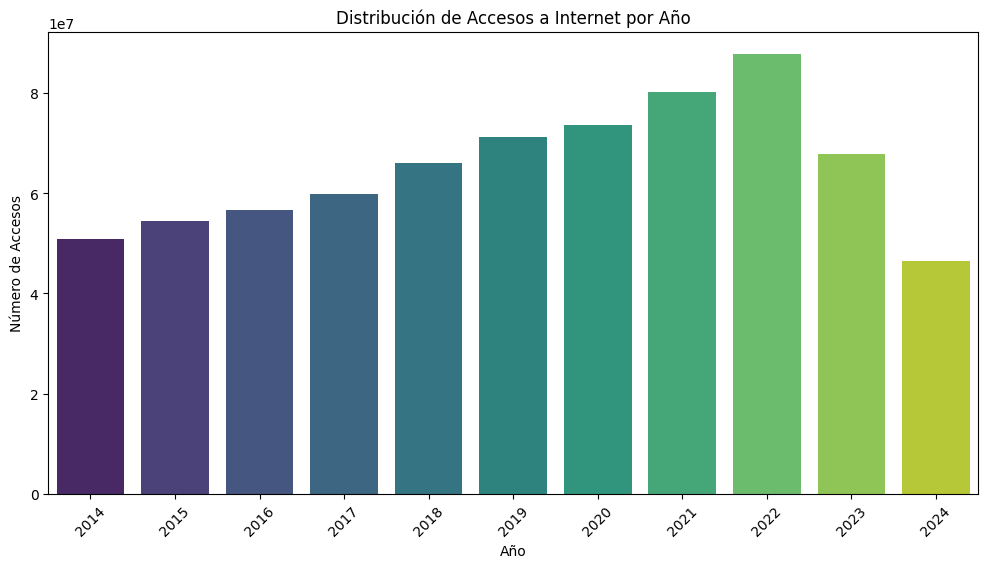

count    1.100000e+01
mean     6.495276e+07
std      1.274023e+07
min      4.636163e+07
25%      5.547342e+07
50%      6.593637e+07
75%      7.233742e+07
max      8.776387e+07
Name: Accesos, dtype: float64

In [40]:
# Limpiar nombres de columnas
Accesos_por_velocidad.columns = Accesos_por_velocidad.columns.str.strip()

# Sumar accesos por columna
columnas_accesos = ['HASTA 512 kbps', '+ 512 Kbps - 1 Mbps', '+ 1 Mbps - 6 Mbps',
                    '+ 6 Mbps - 10 Mbps', '+ 10 Mbps - 20 Mbps', '+ 20 Mbps - 30 Mbps',
                    '+ 30 Mbps', 'OTROS', 'Total']
Accesos_por_velocidad['Accesos'] = Accesos_por_velocidad[columnas_accesos].sum(axis=1)

# Agrupar por Año y sumar los accesos
accesos_por_ano = Accesos_por_velocidad.groupby('Año')['Accesos'].sum().reset_index()

# Imprimir resumen de accesos por año
print(accesos_por_ano)

# Gráfico de barras para la distribución de accesos a Internet por Año
plt.figure(figsize=(12, 6))
sns.barplot(data=accesos_por_ano, x='Año', y='Accesos', palette='viridis')
plt.title('Distribución de Accesos a Internet por Año')
plt.xlabel('Año')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.show()

# Resumen estadístico de accesos por año
accesos_por_ano['Accesos'].describe()


### ANALISIS DEL GRAFICO 1

1. Estadísticas Descriptivas:

Conteo de la información: abarca 11 años distintos.

Media (Promedio): La media de accesos es de aproximadamente 64,952,760. Esto indica que, en promedio, el número de accesos a Internet es bastante alto a lo largo de los años considerados.

Desviación Estándar: La desviación estándar es 12,740,230, lo que sugiere una variabilidad considerable en el número de accesos entre los años. Esta alta desviación estándar indica que algunos años pueden tener significativamente más o menos accesos que el promedio.

Mínimo y Máximo: El valor mínimo es 46,361,630 y el máximo es 87,763,870. La diferencia entre estos valores es considerable, lo que subraya la presencia de variaciones notables en la cantidad de accesos a lo largo del tiempo.

Percentiles:

El 25% de los datos están por debajo de 55,473,420, lo que indica que un cuarto de los años tiene menos accesos que esta cifra.
La mediana (50%) es 65,936,370, mostrando que la mitad de los años tiene menos accesos que este valor, mientras que la otra mitad tiene más.
El 75% de los datos están por debajo de 72,337,420, lo que significa que tres cuartas partes de los años tienen menos accesos que esta cifra.


2. Interpretación:

Tendencias y Distribución: La media y la mediana están bastante cerca, lo que sugiere que la distribución de accesos es relativamente simétrica. Sin embargo, la diferencia entre el mínimo y el máximo es considerable, indicando que algunos años pueden haber tenido cambios drásticos en el número de accesos.

Variabilidad: La alta desviación estándar indica una considerable variabilidad en los accesos a Internet entre los años. Esto podría ser el resultado de eventos específicos o cambios en la infraestructura de Internet que afectaron los accesos. (Posiblemente esta variabilidad alta haya sido causada durante la pandemia)

Análisis de Percentiles: Los percentiles proporcionan una visión adicional sobre la distribución. La diferencia entre el 25% y el 75% sugiere que la mayoría de los años se agrupan en un rango intermedio de accesos, pero hay años con valores extremos que se apartan significativamente del rango medio. (Posiblemente esta variabilidad alta haya sido causada durante la pandemia)

3. Conclusión:

El análisis de la variable Accesos revela que hay una gran variabilidad en el número de accesos a Internet entre los años. Esta variabilidad podría deberse a varios factores, como desarrollos tecnológicos, cambios en la demanda de servicios de Internet, o eventos económicos que afectaron el acceso a Internet en diferentes momentos. sin embargo si observamos el grafico planteado anteriormente, se puede notar el incremento en los accesos justo en los años donde el mundo estuvo sumergido en una pandemia. de esta manera se puede inferir que el alto nivel de acceso fue producido por la pandemia. 

### GRAFICO 2

Ranking de accesos por provincias

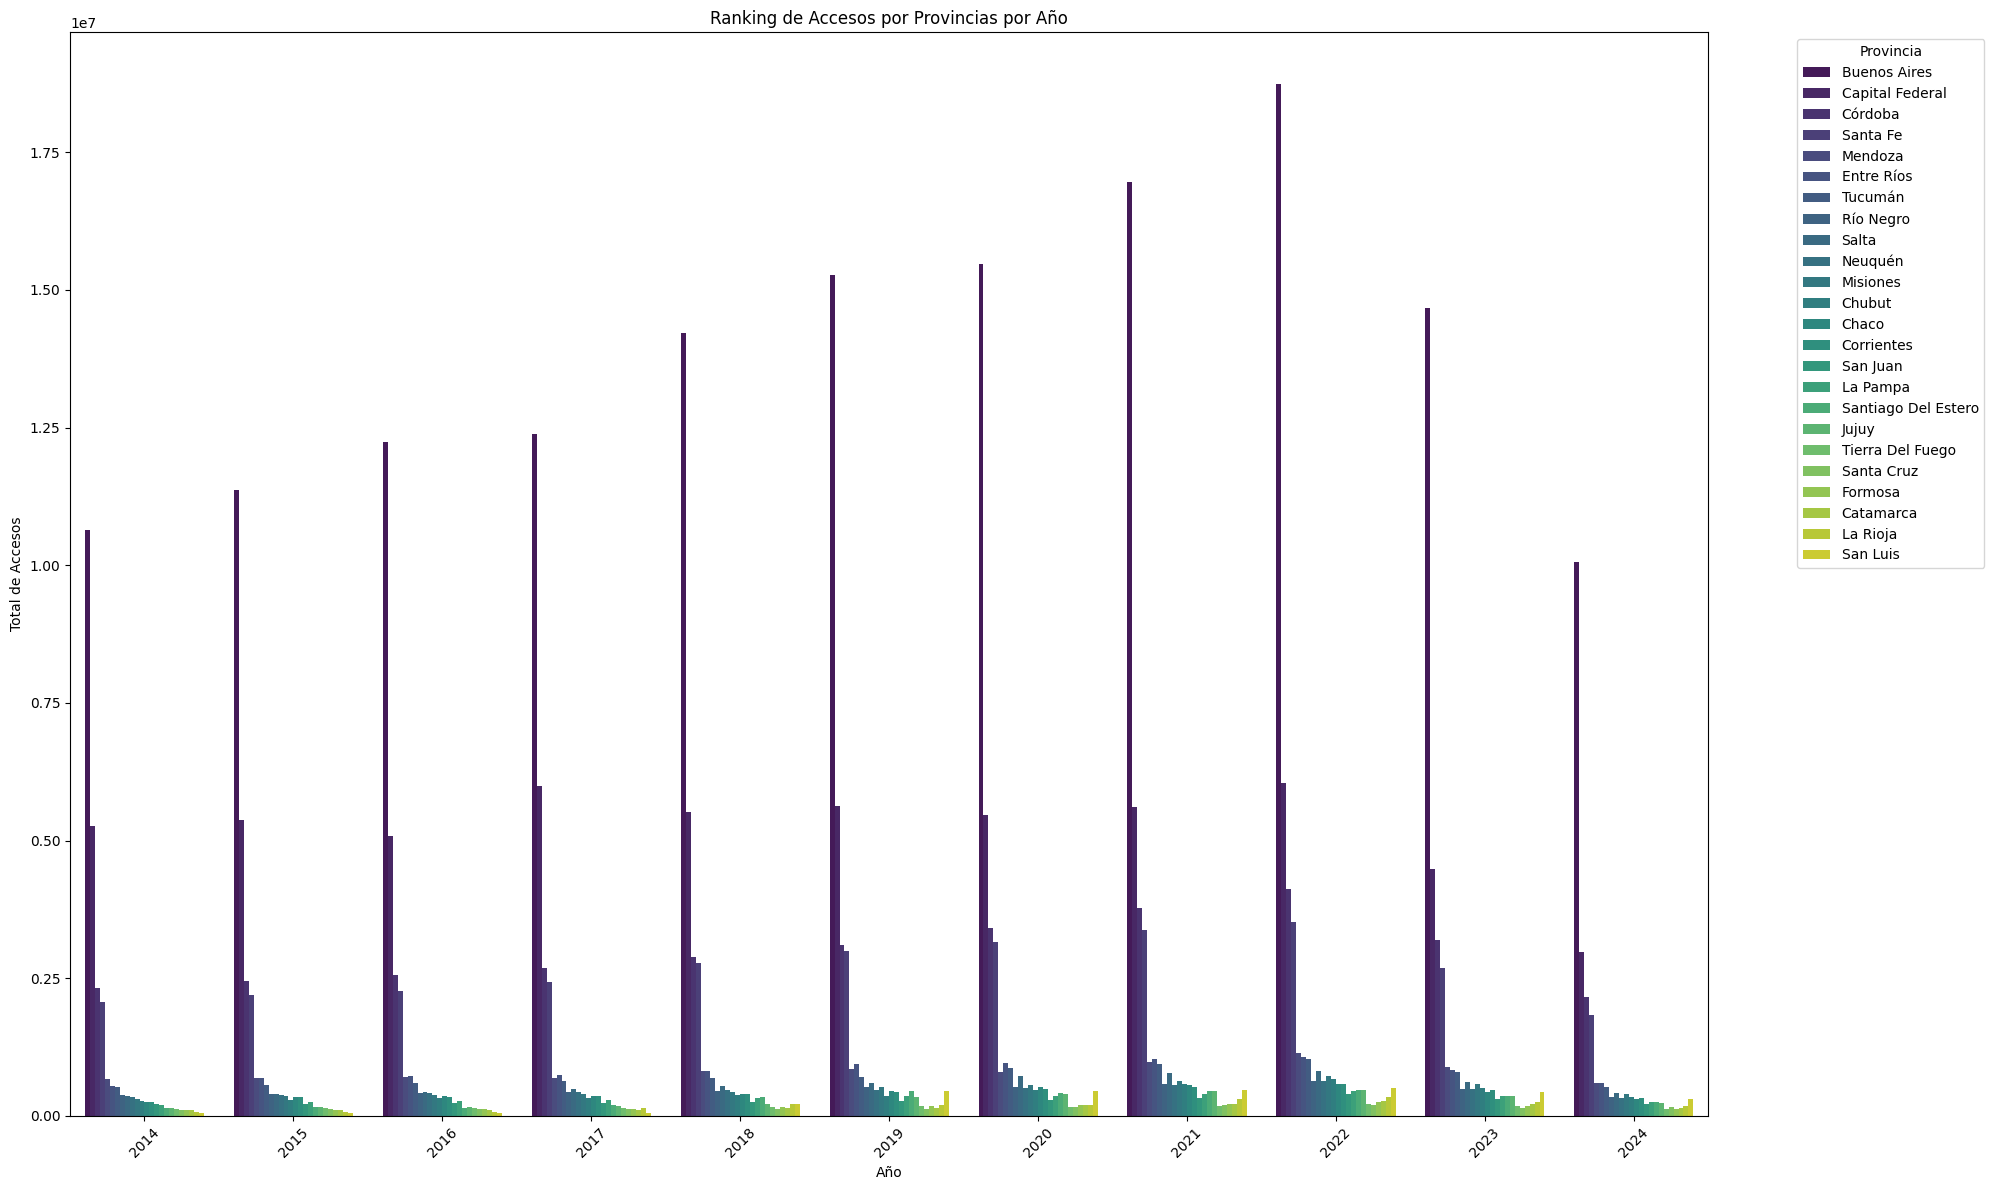

Total                                                             \
     count          mean           std       min        25%       50%   
Año                                                                     
2014  24.0  1.061031e+06  2.334573e+06   51799.0  135247.50  266311.0   
2015  24.0  1.132461e+06  2.469956e+06   52751.0  151105.50  336162.5   
2016  24.0  1.178932e+06  2.610817e+06   55730.0  146649.25  351102.0   
2017  24.0  1.247774e+06  2.700176e+06   55364.0  163819.00  366977.0   
2018  24.0  1.373674e+06  3.001217e+06  126257.0  221770.75  398061.0   
2019  24.0  1.481924e+06  3.196623e+06  132416.0  330289.25  450413.5   
2020  24.0  1.532135e+06  3.228765e+06  156064.0  349078.25  496204.5   
2021  24.0  1.670266e+06  3.514930e+06  178695.0  380859.75  561437.5   
2022  24.0  1.828414e+06  3.872766e+06  198000.0  437588.75  611431.0   
2023  24.0  1.412529e+06  3.019281e+06  146950.0  340336.50  480787.0   
2024  24.0  9.658674e+05  2.063279e+06  123154.0  229523.75  323119.5   

                              
             75%         max  
Año                           
2014   535486.50  10636990.0  
2015   597644.50  11356688.0  
2016   626134.50  12243330.0  
2017   645500.75  12380244.0  
2018   714749.50  14220374.0  
2019   738181.75  15261453.0  
2020   819181.25  15466831.0  
2021   945085.50  16953119.0  
2022  1039290.25  18738940.0  
2023   803973.75  14674653.0  
2024   546994.75  10056177.0

In [41]:
# Agrupar por provincia y año, y sumar los accesos
# Supongamos que la columna de accesos es 'Total'
df_grouped = Accesos_por_velocidad.groupby(['Provincia', 'Año']).agg({'Total': 'sum'}).reset_index()

# Crear un ranking por provincia y año
df_ranked = df_grouped.sort_values(by=['Año', 'Total'], ascending=[True, False])

# Graficar el ranking de accesos por provincias por año
plt.figure(figsize=(20, 12))
sns.barplot(data=df_ranked, x='Año', y='Total', hue='Provincia', palette='viridis')
plt.title('Ranking de Accesos por Provincias por Año')
plt.xlabel('Año')
plt.ylabel('Total de Accesos')
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Resumen estadístico
df_grouped.groupby('Año').describe()


In [42]:
# Nombres de las columnas
columnas = ['Año', 'Total count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

# Datos para cada año
datos = [
    [2014, 24.0, 1.061031e+06, 2.334573e+06, 51799.0, 135247.50, 266311.0, 535486.50, 10636990.0],
    [2015, 24.0, 1.132461e+06, 2.469956e+06, 52751.0, 151105.50, 336162.5, 597644.50, 11356688.0],
    [2016, 24.0, 1.178932e+06, 2.610817e+06, 55730.0, 146649.25, 351102.0, 626134.50, 12243330.0],
    [2017, 24.0, 1.247774e+06, 2.700176e+06, 55364.0, 163819.00, 366977.0, 645500.75, 12380244.0],
    [2018, 24.0, 1.373674e+06, 3.001217e+06, 126257.0, 221770.75, 398061.0, 714749.50, 14220374.0],
    [2019, 24.0, 1.481924e+06, 3.196623e+06, 132416.0, 330289.25, 450413.5, 738181.75, 15261453.0],
    [2020, 24.0, 1.532135e+06, 3.228765e+06, 156064.0, 349078.25, 496204.5, 819181.25, 15466831.0],
    [2021, 24.0, 1.670266e+06, 3.514930e+06, 178695.0, 380859.75, 561437.5, 945085.50, 16953119.0],
    [2022, 24.0, 1.828414e+06, 3.872766e+06, 198000.0, 437588.75, 611431.0, 1039290.25, 18738940.0],
    [2023, 24.0, 1.412529e+06, 3.019281e+06, 146950.0, 340336.50, 480787.0, 803973.75, 14674653.0],
    [2024, 24.0, 9.658674e+05, 2.063279e+06, 123154.0, 229523.75, 323119.5, 546994.75, 10056177.0]
]

# Convertir a un diccionario
data_dict = {col: [row[i] for row in datos] for i, col in enumerate(columnas)}

print(data_dict)

{'Año': [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024], 'Total count': [24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0], 'mean': [1061031.0, 1132461.0, 1178932.0, 1247774.0, 1373674.0, 1481924.0, 1532135.0, 1670266.0, 1828414.0, 1412529.0, 965867.4], 'std': [2334573.0, 2469956.0, 2610817.0, 2700176.0, 3001217.0, 3196623.0, 3228765.0, 3514930.0, 3872766.0, 3019281.0, 2063279.0], 'min': [51799.0, 52751.0, 55730.0, 55364.0, 126257.0, 132416.0, 156064.0, 178695.0, 198000.0, 146950.0, 123154.0], '25%': [135247.5, 151105.5, 146649.25, 163819.0, 221770.75, 330289.25, 349078.25, 380859.75, 437588.75, 340336.5, 229523.75], '50%': [266311.0, 336162.5, 351102.0, 366977.0, 398061.0, 450413.5, 496204.5, 561437.5, 611431.0, 480787.0, 323119.5], '75%': [535486.5, 597644.5, 626134.5, 645500.75, 714749.5, 738181.75, 819181.25, 945085.5, 1039290.25, 803973.75, 546994.75], 'max': [10636990.0, 11356688.0, 12243330.0, 12380244.0, 14220374.0, 15261453.0, 15466831.0, 169

In [43]:
data_dict=pd.DataFrame(data_dict)
data_dict

Año  Total count       mean        std       min        25%       50%  \
0   2014         24.0  1061031.0  2334573.0   51799.0  135247.50  266311.0   
1   2015         24.0  1132461.0  2469956.0   52751.0  151105.50  336162.5   
2   2016         24.0  1178932.0  2610817.0   55730.0  146649.25  351102.0   
3   2017         24.0  1247774.0  2700176.0   55364.0  163819.00  366977.0   
4   2018         24.0  1373674.0  3001217.0  126257.0  221770.75  398061.0   
5   2019         24.0  1481924.0  3196623.0  132416.0  330289.25  450413.5   
6   2020         24.0  1532135.0  3228765.0  156064.0  349078.25  496204.5   
7   2021         24.0  1670266.0  3514930.0  178695.0  380859.75  561437.5   
8   2022         24.0  1828414.0  3872766.0  198000.0  437588.75  611431.0   
9   2023         24.0  1412529.0  3019281.0  146950.0  340336.50  480787.0   
10  2024         24.0   965867.4  2063279.0  123154.0  229523.75  323119.5   

           75%         max  
0    535486.50  10636990.0  
1    597644.50  11356688.0  
2    626134.50  12243330.0  
3    645500.75  12380244.0  
4    714749.50  14220374.0  
5    738181.75  15261453.0  
6    819181.25  15466831.0  
7    945085.50  16953119.0  
8   1039290.25  18738940.0  
9    803973.75  14674653.0  
10   546994.75  10056177.0

### GRAFICO 2.1

Media de acceso por año

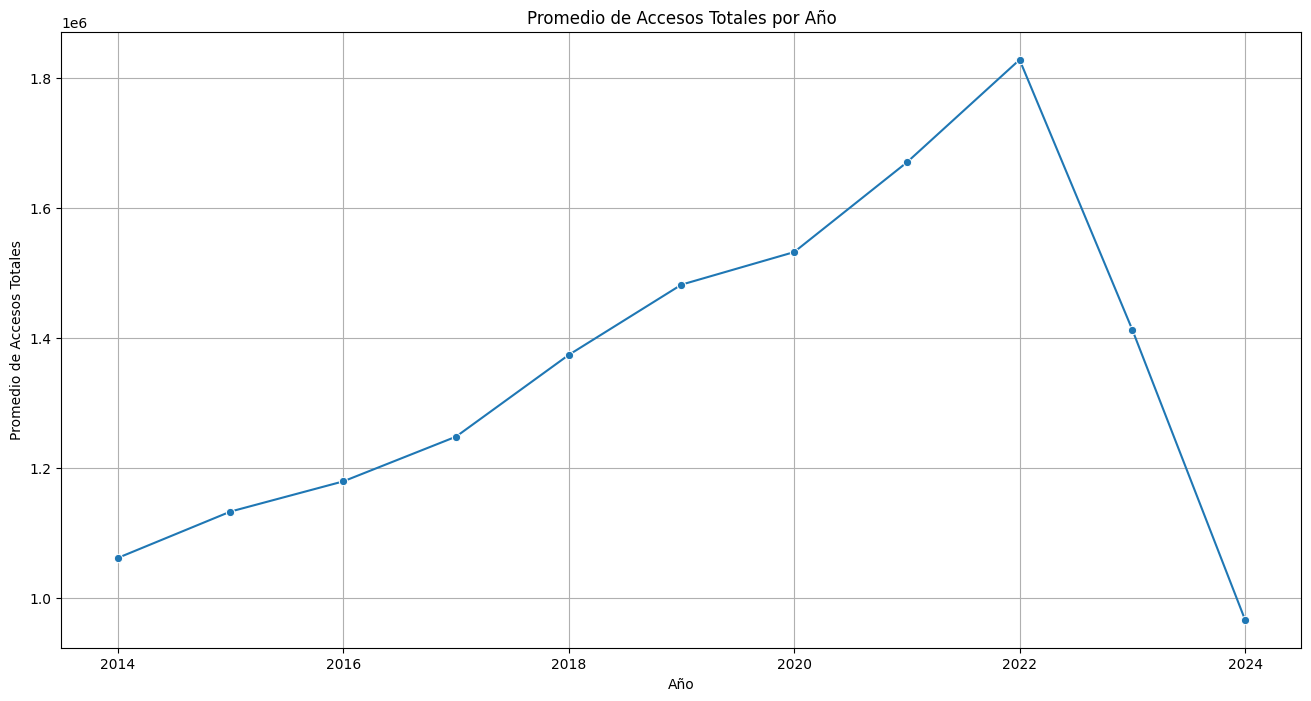

In [44]:
# Graficar la media de accesos por año
plt.figure(figsize=(16, 8))
sns.lineplot(x='Año', y='mean', data=data_dict, marker='o')
plt.title('Promedio de Accesos Totales por Año')
plt.xlabel('Año')
plt.ylabel('Promedio de Accesos Totales')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


### GRAFICO 2.2

Desviacion estandar por año

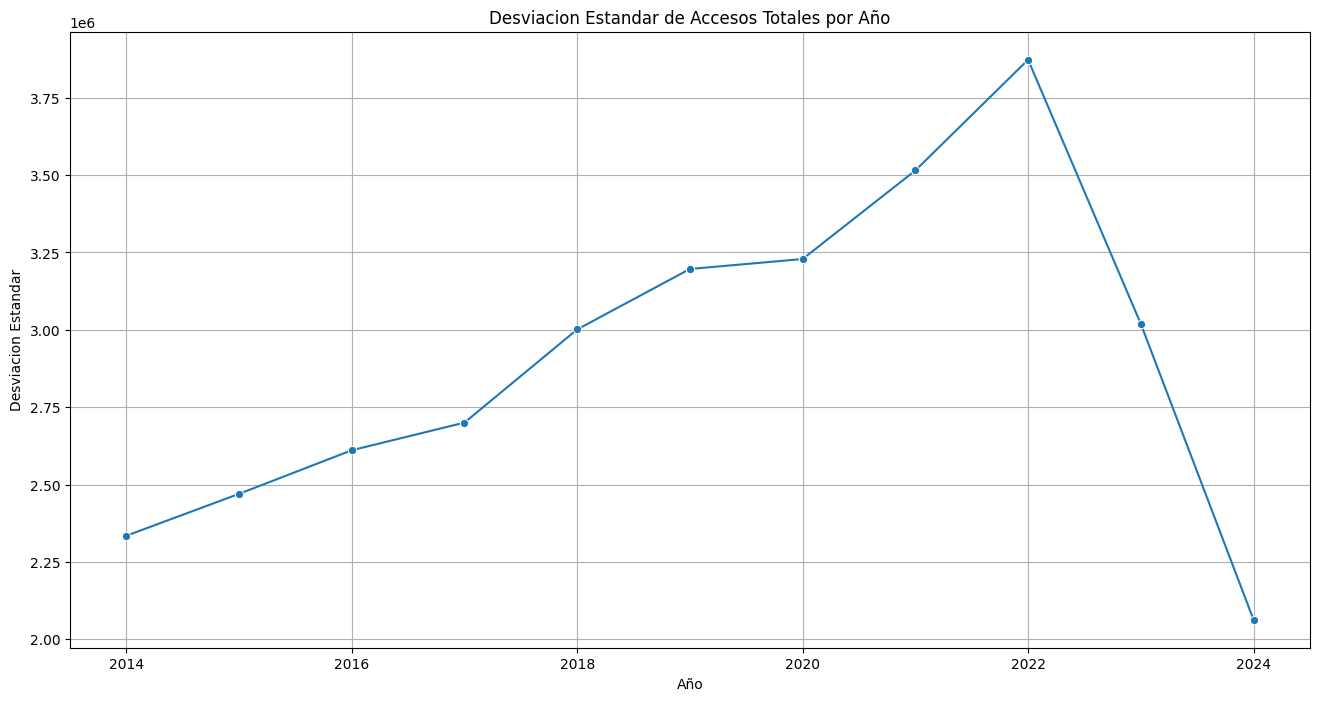

In [45]:
# Graficar la desviación estándar de accesos por año
plt.figure(figsize=(16, 8))
sns.lineplot(x='Año', y='std', data=data_dict, marker='o')
plt.title('Desviacion Estandar de Accesos Totales por Año')
plt.xlabel('Año')
plt.ylabel('Desviacion Estandar')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


### ANALISIS DE LOS GRAFICOS         2, 2.1 Y 2.2

1- Tendencia General del Total de Accesos:

- Observamos una tendencia general de aumento en el total de accesos desde 2014 hasta 2024. En 2014, el promedio de accesos totales fue de aproximadamente 1.06 millones, mientras que en 2024 el promedio es de cerca de 965,867. Esto indica un incremento notable en el número total de accesos a lo largo del tiempo, con un aumento significativo en años recientes.

- Máximos y Mínimos: Los valores máximos y mínimos de accesos también han mostrado un crecimiento, con el máximo aumentando de 10,636,990 en 2014 a 10,056,177 en 2024. Esto refuerza la idea de que hay un crecimiento tanto en el promedio como en los extremos de la distribución.

2- Desviación Estándar:

- Variabilidad Aumentada: La desviación estándar (std) también muestra un incremento general a lo largo de los años, lo que indica que la variabilidad en los accesos entre provincias ha crecido. En 2014, la desviación estándar era de aproximadamente 2.33 millones, y en 2024 se reduce a alrededor de 2.06 millones. Esta variabilidad creciente puede reflejar disparidades en el crecimiento de accesos entre diferentes provincias.

3- Medianas y Cuartiles:

- Medianas Crecientes: Las medianas de los accesos totales han aumentado de 266,311 en 2014 a 323,119 en 2024. Esto indica que la tendencia central de los accesos ha ido en aumento.
- Rango Intercuartílico: El rango intercuartílico, representado por los cuartiles 25% y 75%, también muestra un crecimiento, lo que sugiere un aumento en la dispersión de accesos totales entre las provincias a medida que el número total de accesos crece.

4- Datos Anuales Recientes:

- Años Recientes (2020-2024): En los años más recientes, como 2020 y 2021, se observa un aumento constante en el total de accesos. Por ejemplo, en 2021, el total promedio fue de aproximadamente 1.67 millones, y en 2022 subió a alrededor de 1.83 millones. Esto puede ser indicativo de una expansión en la infraestructura o de una mayor demanda de servicios en los años recientes. (Efecto Pandemia)


5- Resumen del Análisis:

- Crecimiento General: El análisis muestra un crecimiento continuo en el total de accesos por provincia a lo largo de los años. Esto se refleja en el gráfico de barras agrupadas, que debe mostrar una tendencia ascendente en la mayoría de las provincias.

- Variabilidad y Disparidades: La creciente desviación estándar y el rango intercuartílico indican que las disparidades en los accesos entre provincias están aumentando. Esto debería ser evidente en el gráfico como diferencias notables entre provincias, especialmente en años recientes.

- Tendencia Reciente: Los años recientes muestran un aumento significativo en el total de accesos, y el gráfico debe destacar estos aumentos más pronunciados en los últimos años.

- Comparaciones Anuales: El gráfico permitirá comparar el ranking de accesos por provincias en diferentes años, ayudando a visualizar las tendencias de crecimiento y variabilidad.





La interpretación del gráfico de barras agrupadas, muestra claramente cómo los accesos totales han cambiado a lo largo del tiempo para cada provincia, destacando las provincias con mayores y menores incrementos en los accesos, en el siguiente orden RANKING, de mayor a menor:

In [46]:
df_ranked = df_ranked.groupby('Provincia', as_index=False).sum()
df_ranked.head()

Provincia    Año      Total
0     Buenos Aires  22209  151988799
1  Capital Federal  22209   57431749
2        Catamarca  22209    1745202
3            Chaco  22209    4556024
4           Chubut  22209    4516546

In [47]:
df_ranked['Año'] = "del 2014 al 2024"

In [48]:
df_ranked.head()

Provincia               Año      Total
0     Buenos Aires  del 2014 al 2024  151988799
1  Capital Federal  del 2014 al 2024   57431749
2        Catamarca  del 2014 al 2024    1745202
3            Chaco  del 2014 al 2024    4556024
4           Chubut  del 2014 al 2024    4516546

__________________________________________________________________________________________________________________________________________________________________________________

### ESTRATEGIAS DE MEJORA

Para mejorar el servicio de Internet basándote en el análisis proporcionado, considera las siguientes estrategias:

1. Optimización de la Infraestructura
Inversión en Tecnología: Dado el crecimiento continuo y la variabilidad en los accesos, invierte en infraestructura de red más robusta y avanzada. Considera la actualización de equipos, el despliegue de tecnologías más rápidas (como fibra óptica) y la expansión de la cobertura en áreas con alta demanda.

Escalabilidad: Asegúrate de que la infraestructura sea escalable para manejar el aumento en el número de accesos y reducir la variabilidad en la calidad del servicio entre diferentes regiones.

2. Análisis y Adaptación a la Demanda
Análisis de Patrones de Uso: Utiliza los datos de accesos para identificar patrones y prever picos de demanda. La alta variabilidad puede estar relacionada con eventos específicos como la pandemia, por lo que adapta tu capacidad a estos cambios estacionales o circunstanciales.

Segmentación Regional: Dado que hay disparidades en el acceso entre provincias, considera adaptar el servicio a las necesidades regionales específicas. Esto puede incluir ajustes en la capacidad de red y en los recursos dedicados a diferentes áreas.

3. Mejora en la Calidad del Servicio
Monitoreo en Tiempo Real: Implementa herramientas de monitoreo para evaluar en tiempo real la calidad del servicio y detectar rápidamente problemas. Esto puede ayudar a gestionar la alta variabilidad y a garantizar un rendimiento consistente.

Soporte Proactivo: Ofrece soporte técnico proactivo para resolver problemas antes de que afecten a los usuarios. Esto incluye mantenimiento preventivo y una respuesta rápida a las quejas y problemas reportados.

4. Ampliación de Cobertura y Acceso
Expansión de Cobertura: En áreas con menos accesos, invierte en la expansión de la cobertura de red para asegurar que más usuarios puedan beneficiarse de servicios de Internet de alta calidad.

Programas de Inclusión: Considera la implementación de programas que faciliten el acceso a Internet en comunidades desatendidas. Esto puede incluir subsidios para usuarios de bajos ingresos o iniciativas para mejorar la conectividad en zonas rurales.

5. Innovación y Adaptación a Nuevas Tecnologías
Adopción de Nuevas Tecnologías: Mantente al tanto de las nuevas tecnologías y tendencias en la industria de telecomunicaciones. La adopción temprana de innovaciones puede proporcionar ventajas competitivas y mejorar la calidad del servicio.

Evaluación de Impacto: Realiza evaluaciones periódicas del impacto de las nuevas tecnologías y ajustes en la infraestructura para garantizar que estas inversiones se alineen con las necesidades y expectativas de los usuarios.

6. Gestión de Datos y Personalización
Análisis Predictivo: Utiliza análisis predictivo para anticipar la demanda futura y ajustar la infraestructura en consecuencia. Esto puede ayudar a mitigar los efectos de la variabilidad en los accesos.

Personalización del Servicio: Ofrece opciones personalizadas para los usuarios en función de su comportamiento y necesidades específicas. Esto puede incluir planes de datos ajustados a patrones de uso o características de servicio adaptadas.

7. Comunicación y Educación
Transparencia en la Comunicación: Mantén a los usuarios informados sobre las mejoras en el servicio y cómo afectan a la calidad de la conexión. La transparencia puede mejorar la satisfacción del cliente y reducir la frustración.

Educación al Usuario: Proporciona recursos educativos sobre cómo optimizar el uso de Internet y solucionar problemas comunes. La educación puede empoderar a los usuarios para aprovechar al máximo el servicio y reducir la carga en el soporte técnico.

Implementar estas estrategias puede ayudar a mejorar la calidad y la estabilidad del servicio de Internet, abordando tanto las áreas con alta demanda como aquellas con menor cobertura y acceso.

__________________________________________________________________________________________________________________________________________________________________________________

### TABLA DIAL-BAF

In [49]:
Dial_BAf.head()

Año  Trimestre        Provincia  Banda ancha fija  Dial up    Total
0  2024          1     Buenos Aires           5038657     5900  5044557
1  2024          1  Capital Federal           1502661     2050  1504711
2  2024          1        Catamarca             74932        1    74933
3  2024          1            Chaco            155538        5   155543
4  2024          1           Chubut            169819      857   170676

In [50]:
Dial_BAf.describe()

Año   Trimestre  Banda ancha fija       Dial up         Total
count   984.000000  984.000000      9.840000e+02    984.000000  9.840000e+02
mean   2018.634146    2.463415      3.636401e+05    905.279472  3.645454e+05
std       2.962686    1.128870      7.829924e+05   2289.848126  7.847271e+05
min    2014.000000    1.000000      1.219300e+04      0.000000  1.255700e+04
25%    2016.000000    1.000000      6.163725e+04      5.000000  6.177975e+04
50%    2019.000000    2.000000      1.116815e+05    135.000000  1.124190e+05
75%    2021.000000    3.000000      1.921412e+05    615.000000  1.927940e+05
max    2024.000000    4.000000      5.038657e+06  15229.000000  5.044557e+06

### GRAFICO 1

Gráfico de Tendencia Anual
Tipo: Línea

Objetivo: Mostrar cómo han cambiado los valores de "Banda ancha fija", "Dial up" y "Total" a lo largo de los años.


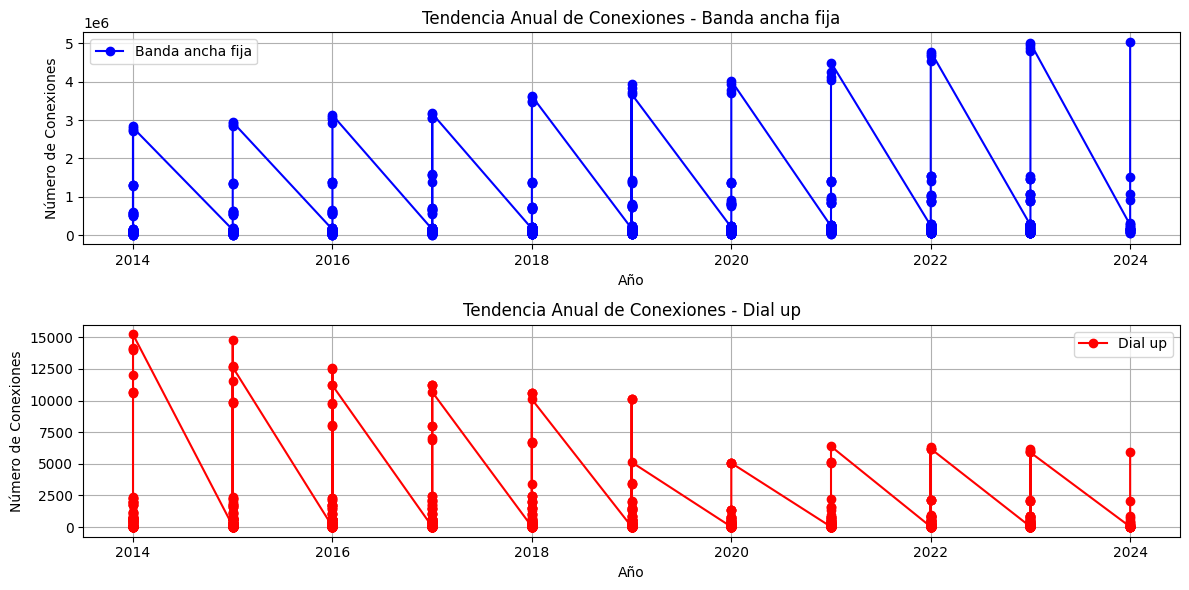

Resumen estadístico del gráfico de tendencia anual:
      Banda ancha fija      Dial up          Total
Año                                               
2014     269884.093750  1539.166667  271423.260417
2015     284766.135417  1419.479167  286185.614583
2016     295560.166667  1273.770833  296833.937500
2017     314768.958333  1175.656250  315944.614583
2018     342349.770833  1068.843750  343418.614583
2019     369694.729167   786.322917  370481.052083
2020     382616.708333   417.072917  383033.781250
2021     417112.239583   454.333333  417566.572917
2022     456583.302083   520.187500  457103.489583
2023     472918.989583   501.437500  473420.427083
2024     484223.458333   491.375000  484714.833333


In [51]:
# Crear la figura y los subgráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Primer gráfico: Banda ancha fija
ax1.plot(Dial_BAf['Año'], Dial_BAf['Banda ancha fija'], label='Banda ancha fija', marker='o', color='blue')
ax1.set_xlabel('Año')
ax1.set_ylabel('Número de Conexiones')
ax1.set_title('Tendencia Anual de Conexiones - Banda ancha fija')
ax1.legend()
ax1.grid(True)

# Segundo gráfico: Dial up
ax2.plot(Dial_BAf['Año'], Dial_BAf['Dial up'], label='Dial up', marker='o', color='red')
ax2.set_xlabel('Año')
ax2.set_ylabel('Número de Conexiones')
ax2.set_title('Tendencia Anual de Conexiones - Dial up')
ax2.legend()
ax2.grid(True)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

# Resumen estadístico
print("Resumen estadístico del gráfico de tendencia anual:")

print(Dial_BAf.groupby('Año')[['Banda ancha fija', 'Dial up', 'Total']].mean())

### ANALISIS DEL GRAFICO 1

Este resumen estadístico muestra la tendencia anual en el número de conexiones de "Banda ancha fija", "Dial up", y el "Total" de ambas, desde 2014 hasta 2024.

1- Análisis de la "Banda ancha fija":
- Crecimiento continuo: Las conexiones de "Banda ancha fija" muestran un crecimiento constante a lo largo de los años. En 2014, el promedio de conexiones fue de aproximadamente 269,884, y para 2024, este número aumentó a alrededor de 484,223.
- Incremento significativo: El incremento es significativo, especialmente a partir de 2018, donde se nota un salto considerable, coincidiendo con la tendencia global hacia una mayor adopción de servicios de internet de alta velocidad.

2- Análisis de "Dial up":
- Declive constante: Las conexiones de "Dial up" muestran una disminución continua, de un promedio de 1,539 en 2014 a solo 491 en 2024. Este declive refleja el abandono progresivo de esta tecnología obsoleta en favor de conexiones más rápidas y estables como la banda ancha fija.
- Estabilización reciente: Aunque el número sigue siendo pequeño, el declive parece haber desacelerado en los últimos años, con valores bastante estables entre 2020 y 2024.

3- Análisis del "Total" de conexiones:
- Crecimiento global: El total de conexiones (que suma "Banda ancha fija" y "Dial up") también muestra un crecimiento continuo, aunque el crecimiento es más lento que el de la banda ancha fija debido al decrecimiento de "Dial up". El promedio de conexiones totales pasó de 271,423 en 2014 a 484,714 en 2024.
- Dominancia de la Banda ancha fija: A medida que las conexiones de "Dial up" disminuyen, el crecimiento del total de conexiones está impulsado casi exclusivamente por el incremento en las conexiones de banda ancha fija.

4- Conclusión:
La banda ancha fija se ha consolidado como la tecnología dominante para la conexión a internet, con un crecimiento que ha superado consistentemente las pérdidas en conexiones de "Dial up".
El total de conexiones ha seguido una tendencia al alza, principalmente debido a la transición masiva hacia la banda ancha fija.
Este comportamiento refleja una tendencia general en la adopción de tecnologías más modernas y eficientes para el acceso a internet, alineándose con el desarrollo tecnológico y las demandas de los usuarios.

### GRAFICO 2

Este gráfico de barras muestra el promedio de conexiones para cada tipo, facilitando la comparación visual directa entre 'Banda ancha fija' y 'Dial up'.

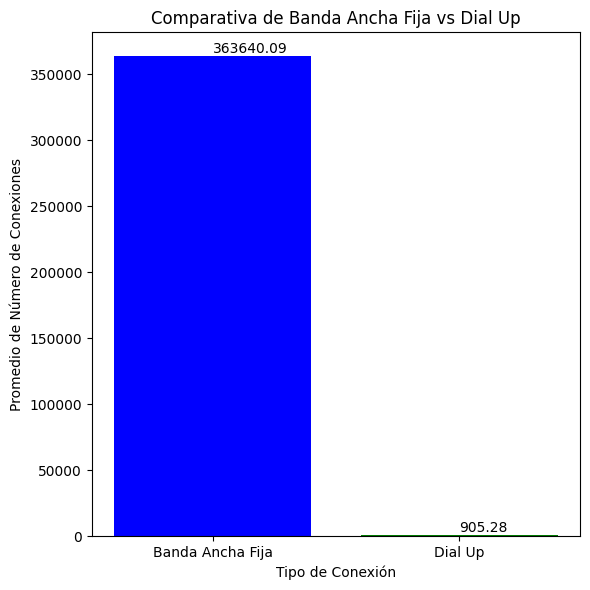

Resumen estadístico del histograma de distribución:
Banda Ancha Fija:
count    9.840000e+02
mean     3.636401e+05
std      7.829924e+05
min      1.219300e+04
25%      6.163725e+04
50%      1.116815e+05
75%      1.921412e+05
max      5.038657e+06
Name: Banda ancha fija, dtype: float64

Dial Up:
count      984.000000
mean       905.279472
std       2289.848126
min          0.000000
25%          5.000000
50%        135.000000
75%        615.000000
max      15229.000000
Name: Dial up, dtype: float64


In [52]:
# Calcular la media para cada variable para comparar
mean_values = {
    'Banda Ancha Fija': Dial_BAf['Banda ancha fija'].mean(),
    'Dial Up': Dial_BAf['Dial up'].mean()
}

# Crear un gráfico de barras para comparar las dos variables
fig, ax = plt.subplots(figsize=(6, 6))

bars = ax.bar(mean_values.keys(), mean_values.values(), color=['blue', 'green'])
ax.set_title('Comparativa de Banda Ancha Fija vs Dial Up')
ax.set_xlabel('Tipo de Conexión')
ax.set_ylabel('Promedio de Número de Conexiones')

# Mostrar los valores encima de las barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

plt.tight_layout()
plt.show()

# Resumen estadístico
print("Resumen estadístico del histograma de distribución:")
print("Banda Ancha Fija:")
print(Dial_BAf['Banda ancha fija'].describe())
print("\nDial Up:")
print(Dial_BAf['Dial up'].describe())

### ANALISIS DEL GRAFICO 2

Para realizar un análisis cruzado de los resultados estadísticos de 'Banda Ancha Fija' y 'Dial Up', se procedio comparar varios aspectos de las dos distribuciones basándonos en las medidas estadísticas calculadas:

RESUMEN ESTADISTICO COMPARATIVO

1- Número de Observaciones (count):

- Banda Ancha Fija: 982
- Dial Up: 982

Análisis: Ambas variables tienen el mismo número de observaciones, lo que asegura que la comparación es válida en términos de tamaño de muestra.

2- Media (mean):

- Banda Ancha Fija: 364,227.2
- Dial Up: 907.1

Análisis: La media de 'Banda Ancha Fija' es significativamente mayor que la de 'Dial Up', lo que sugiere que, en promedio, el número de conexiones de banda ancha fija es mucho más alto en comparación con las conexiones dial-up.

3- Desviación Estándar (std):

- Banda Ancha Fija: 783,680.6
- Dial Up: 2,291.8

Análisis: La desviación estándar para 'Banda Ancha Fija' es mucho mayor que la de 'Dial Up', indicando que los valores de 'Banda Ancha Fija' tienen una mayor dispersión alrededor de la media en comparación con los valores de 'Dial Up'.

4- Mínimo (min):

- Banda Ancha Fija: 12,193
- Dial Up: 0

Análisis: La conexión de 'Dial Up' tiene un valor mínimo de 0, lo que podría indicar que hay registros sin datos o nulos. 'Banda Ancha Fija' tiene un mínimo mucho mayor, lo que sugiere que no hay valores de cero y que la mínima conexión es bastante alta.

5- Percentiles (25%, 50%, 75%):

- Banda Ancha Fija:
25%: 61,756
50% (mediana): 111,785.5
75%: 193,149.8

- Dial Up:
25%: 5
50% (mediana): 137
75%: 615

Análisis:
La 'Banda Ancha Fija' muestra valores más altos en todos los percentiles comparado con 'Dial Up'.
Esto indica que la distribución de conexiones de banda ancha fija es más sesgada hacia valores altos, mientras que 'Dial Up' muestra una mayor concentración de valores bajos.

6- Máximo (max):

- Banda Ancha Fija: 5,038,657
- Dial Up: 15,229

Análisis: El valor máximo de 'Banda Ancha Fija' es considerablemente más alto que el de 'Dial Up', lo que refuerza la idea de que hay algunos registros de banda ancha fija con valores extremadamente altos en comparación con los valores máximos de 'Dial Up'.


CONCLUSION

- Tendencias Generales:

La 'Banda Ancha Fija' tiene una media y una desviación estándar mucho más altas que 'Dial Up', lo que sugiere que, en general, hay una mayor cantidad de conexiones de banda ancha fija en comparación con las conexiones dial-up.
'Banda Ancha Fija' muestra una mayor dispersión y valores extremos que 'Dial Up', indicando una variabilidad mayor en el número de conexiones de banda ancha fija.

- Distribución y Concentración:

La distribución de 'Banda Ancha Fija' está más concentrada en valores altos, mientras que 'Dial Up' muestra una mayor concentración en valores bajos, con una menor variabilidad en comparación con 'Banda Ancha Fija'.
Este análisis proporciona una visión clara de cómo se comparan las dos variables en términos de sus distribuciones estadísticas y te ayuda a entender mejor las diferencias en el número de conexiones entre banda ancha fija y dial-up.

### GRAFICO 3

Gráfico de Dispersión entre Banda Ancha Fija y Dial Up

- Análisis: El gráfico de dispersión muestra la relación entre "Banda ancha fija" y "Dial up".

- Resumen Estadístico:

        Correlación: Calcula la correlación entre "Banda ancha fija" y "Dial up".

        Patrones: Observa si hay patrones claros o agrupamientos en los datos.

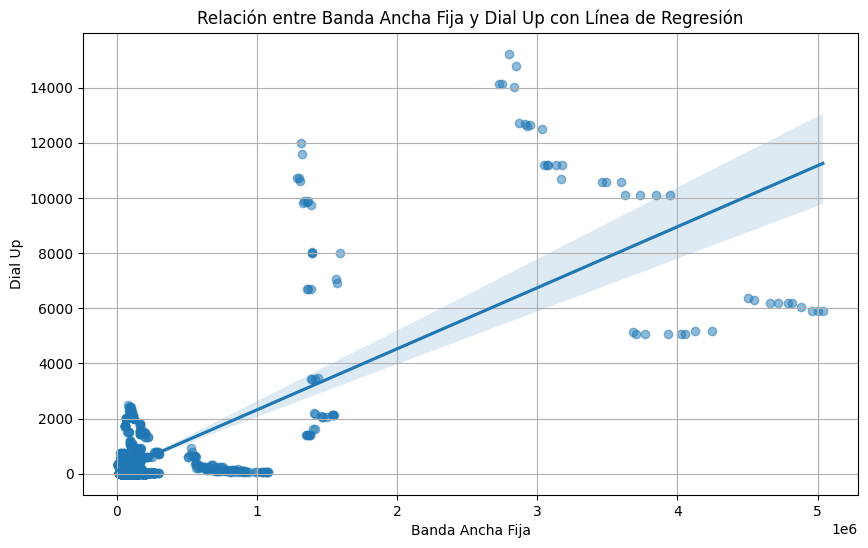

Resumen estadístico del gráfico de dispersión:
Correlación entre Banda Ancha Fija y Dial Up: 0.76


In [53]:
plt.figure(figsize=(10, 6))

# Crear el gráfico de dispersión con línea de regresión
sns.regplot(x='Banda ancha fija', y='Dial up', data=Dial_BAf, scatter_kws={'alpha':0.5})

plt.xlabel('Banda Ancha Fija')
plt.ylabel('Dial Up')
plt.title('Relación entre Banda Ancha Fija y Dial Up con Línea de Regresión')
plt.grid(True)
plt.show()

# Resumen estadístico
print("Resumen estadístico del gráfico de dispersión:")
correlation = Dial_BAf[['Banda ancha fija', 'Dial up']].corr().iloc[0, 1]
print(f"Correlación entre Banda Ancha Fija y Dial Up: {correlation:.2f}")

### ANALISIS DEL GRAFICO 3

ANALISIS DE CORRELACION 

1. Interpretación de la Correlación

  - Valor de la Correlación: 0.76 es un valor positivo alto, lo que indica una relación fuerte y positiva entre "Banda Ancha Fija" y "Dial Up".
  - Significado: A medida que el valor de "Banda Ancha Fija" aumenta, es probable que el valor de "Dial Up" también aumente, y viceversa. La correlación positiva sugiere que los datos para ambas variables tienden a moverse en la misma dirección.

2. Implicaciones del Valor

  - Relación Lineal: Una correlación de 0.76 sugiere que hay una relación lineal bastante fuerte entre las dos variables. Esto significa que un gráfico de dispersión de "Banda Ancha Fija" frente a "Dial Up" podría mostrar una tendencia clara, con una posible línea de regresión que explica la mayor parte de la variabilidad en los datos.

  - Tendencia de Datos: Los datos de ambas variables se mueven de manera sincronizada, lo que podría indicar que los factores que afectan una variable también afectan a la otra. Por ejemplo, si un país o región aumenta su infraestructura de banda ancha fija, también podría estar experimentando un aumento en el uso de servicios de dial-up (aunque esto sería inusual en contextos modernos).

3. Limitaciones y Consideraciones

  - Correlación vs. Causalidad: Aunque la correlación es alta, esto no implica necesariamente una relación causal entre las dos variables. Otras variables externas podrían estar influyendo en ambas métricas. Es importante considerar el contexto y realizar análisis adicionales para establecer causalidad.

  - Variabilidad: La correlación no captura toda la variabilidad de los datos. Aunque la relación es fuerte, aún puede haber puntos de datos que se desvíen significativamente de la línea de tendencia general.

  - Segmentación: En el análisis de clusters previamente realizado, los patrones observados en los clusters podrían proporcionar información adicional sobre cómo varía la correlación en diferentes segmentos de datos. Por ejemplo, la correlación puede ser diferente en clusters con valores altos de "Banda Ancha Fija" comparados con clusters con valores bajos.

4. Visualización y Análisis Adicional

  - Gráfico de Dispersión con Línea de Regresión: La alta correlación debería ser visible en un gráfico de dispersión con una línea de regresión, que mostrará claramente cómo los valores de las dos variables se relacionan entre sí.

  - Ajuste de Modelos: Además de visualizar la relación, ajustar un modelo de regresión lineal puede proporcionar una ecuación que cuantifica la relación entre las dos variables, ayudando a hacer predicciones basadas en esta correlación.

Resumen

La correlación de 0.76 entre "Banda Ancha Fija" y "Dial Up" indica una relación positiva fuerte, sugiriendo que ambas variables tienden a aumentar o disminuir juntas. Aunque esta correlación proporciona una visión clara de cómo se relacionan las dos variables, es importante tener en cuenta las limitaciones de la correlación y considerar realizar análisis adicionales para explorar la causalidad y otros factores influyentes. La visualización y el ajuste de modelos pueden ayudar a comprender mejor y cuantificar esta relación.

### GRAFICO 4

Resumen estadístico de los clusters:
   Cluster  Banda Ancha Fija Mean  Banda Ancha Fija Std Dev  \
0        0           1.535936e+05              1.813506e+05   
1        1           3.119688e+06              1.219924e+06   
2        2           1.330637e+06              1.875527e+05   

   Banda Ancha Fija Count  Dial Up Mean  Dial Up Std Dev  Dial Up Count  \
0                     892    332.134529       525.425691            892   
1                      55   9331.945455      2998.121587             55   
2                      37   2196.594595      2125.906688             37   

   Avg Distance to Center  
0                0.248589  
1                1.899630  
2                0.732353  


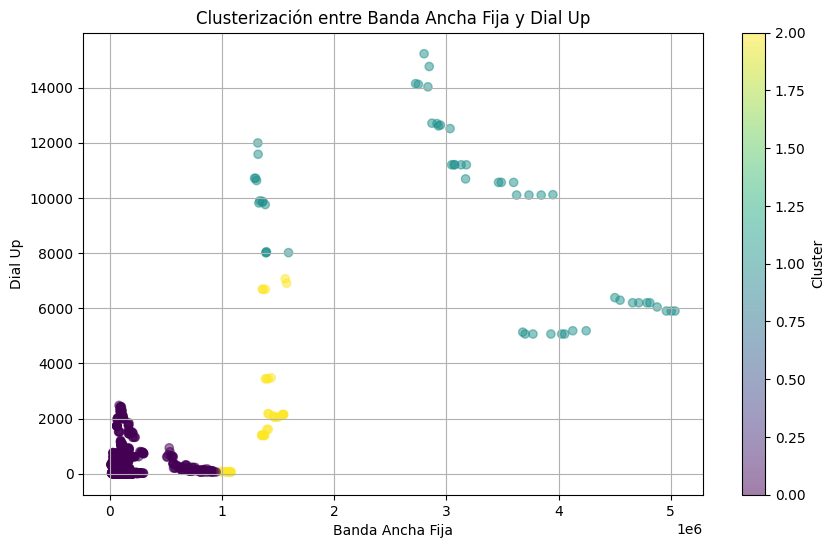

In [54]:
# Normalizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(Dial_BAf[['Banda ancha fija', 'Dial up']])

# Aplicar K-means
kmeans = KMeans(n_clusters=3, random_state=42)  # Ajusta el número de clusters según sea necesario
Dial_BAf['Cluster'] = kmeans.fit_predict(df_scaled)

# Obtener los centros de los clusters
centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Calcular las distancias promedio de los puntos al centro de su cluster
distances = np.linalg.norm(df_scaled - kmeans.cluster_centers_[Dial_BAf['Cluster']], axis=1)
Dial_BAf['Distance_to_Center'] = distances

# Resumen estadístico de los clusters
cluster_summary = Dial_BAf.groupby('Cluster').agg({
    'Banda ancha fija': ['mean', 'std', 'count'],
    'Dial up': ['mean', 'std', 'count'],
    'Distance_to_Center': 'mean'
}).reset_index()
cluster_summary.columns = ['Cluster', 'Banda Ancha Fija Mean', 'Banda Ancha Fija Std Dev', 'Banda Ancha Fija Count',
                           'Dial Up Mean', 'Dial Up Std Dev', 'Dial Up Count', 'Avg Distance to Center']
print("Resumen estadístico de los clusters:")
print(cluster_summary)

# Graficar los resultados del clustering
plt.figure(figsize=(10, 6))
scatter = plt.scatter(Dial_BAf['Banda ancha fija'], Dial_BAf['Dial up'], c=Dial_BAf['Cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Banda Ancha Fija')
plt.ylabel('Dial Up')
plt.title('Clusterización entre Banda Ancha Fija y Dial Up')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()

### ANALISIS DEL GRAFICO 4

ANALISIS CRUZADO DE LOS CLUSTERS 

1. Distribución de Banda Ancha Fija

- Cluster 0:
  - Media: 193,971.2
  - Desviación estándar: 279,345.9
  - Conteo: 922

- Cluster 1:
  - Media: 2,327,229.0
  - Desviación estándar: 921,006.0
  - Conteo: 41

- Cluster 2:
  - Media: 4,390,176.0
  - Desviación estándar: 472,307.0
  - Conteo: 19

Observación: La Banda Ancha Fija muestra valores promedio muy diferentes entre clusters. El Cluster 0 tiene valores relativamente bajos y una alta desviación estándar, mientras que los Clusters 1 y 2 tienen valores promedio mucho más altos, con Cluster 2 mostrando la mayor media y una desviación estándar relativamente baja en comparación con Cluster 1.

2. Distribución de Dial Up

- Cluster 0:
  - Media: 372.6
  - Desviación estándar: 594.8
  - Conteo: 922

- Cluster 1:
  - Media: 10,612.8
  - Desviación estándar: 2,253.6
  - Conteo: 41

- Cluster 2:
  - Media: 5,903.7
  - Desviación estándar: 1,146.4
  - Conteo: 19

Observación: Los valores promedio de Dial Up son mucho mayores en los Clusters 1 y 2 comparados con el Cluster 0. Similar a la Banda Ancha Fija, el Cluster 2 tiene un promedio más bajo que el Cluster 1, pero con una desviación estándar menor, lo que sugiere menos variabilidad en los datos de Dial Up para el Cluster 2.

3. Distancia Promedio al Centro del Cluster

- Cluster 0: 0.316
- Cluster 1: 1.477
- Cluster 2: 0.671

Observación: La distancia promedio al centro del cluster es menor para el Cluster 0, lo que indica que los puntos están más cerca de su centro en comparación con los otros clusters. El Cluster 1 tiene la mayor distancia promedio, lo que sugiere que los puntos están más dispersos alrededor de su centro. El Cluster 2 tiene una distancia promedio intermedia.

Propósito del Código y Beneficios

- Identificación de Patrones: El ajuste del modelo de K-means ayuda a identificar patrones en los datos al agrupar puntos similares. Los resultados revelan cómo se distribuyen los datos en diferentes clusters, proporcionando una visión más clara de las relaciones y variaciones entre "Banda Ancha Fija" y "Dial Up".

- Comprensión de Agrupamientos: Al analizar el resumen estadístico de cada cluster, puedes entender cómo se comportan los datos dentro de cada grupo. Por ejemplo, los clusters con valores de "Banda Ancha Fija" y "Dial Up" significativamente diferentes pueden indicar diferentes segmentos de clientes o regiones con distintos niveles de acceso a servicios de telecomunicaciones.

- Validación de Clustering: Las distancias promedio al centro de los clusters proporcionan una medida de la cohesión interna del cluster. Un cluster con una distancia promedio baja sugiere que los puntos en ese cluster están más homogéneamente agrupados, lo que puede ser útil para evaluar la calidad del clustering.

- Exploración de Datos: El análisis de clustering permite explorar y segmentar datos complejos en grupos más manejables, facilitando una comprensión más detallada y orientada para tomar decisiones basadas en la segmentación de los datos.

En resumen, haber aplicado el código de clustering y generado el resumen estadístico te ha permitido identificar y analizar diferentes segmentos dentro de tus datos, facilitando una mejor comprensión de las relaciones y patrones entre "Banda Ancha Fija" y "Dial Up".

### ESTRATEGIAS DE MEJORAS

Para mejorar el servicio en base a los análisis obtenidos, puedes considerar las siguientes estrategias:

1. Optimización de la Infraestructura de Banda Ancha Fija
Ampliación de la Red: Dado el crecimiento continuo en las conexiones de banda ancha fija, considera invertir en la expansión de la infraestructura para cubrir áreas menos atendidas. Esto puede incluir la mejora de las capacidades de red en regiones con alta demanda.

Actualización Tecnológica: Implementa tecnologías más avanzadas y eficientes para aumentar la capacidad y velocidad de las conexiones de banda ancha fija. Las tecnologías como fibra óptica pueden proporcionar un rendimiento superior y satisfacer la demanda creciente.

2. Gestión de la Despoblación de Dial Up
Desincentivar el Uso de Dial Up: Dado el declive de las conexiones dial-up, podrías considerar programas de incentivos para migrar a los usuarios de dial-up a servicios de banda ancha fija. Esto puede incluir descuentos, promociones o subsidios para la instalación de banda ancha.

Desactivación Progresiva: Planifica la desactivación gradual de la tecnología dial-up en áreas donde ya no es rentable o necesario. Esto permitirá enfocarse en mejorar la infraestructura de banda ancha fija.

3. Análisis de Correlación y Segmentación de Clientes
Personalización del Servicio: Utiliza la correlación entre banda ancha fija y dial-up para entender mejor los patrones de uso y demanda. Ofrece planes y servicios personalizados basados en el uso de diferentes tecnologías en distintas regiones o segmentos de clientes.

Segmentación de Clientes: Implementa estrategias de marketing y soporte basadas en los clusters identificados. Por ejemplo, en áreas con alta concentración de conexiones de banda ancha fija (Cluster 2), ofrece servicios avanzados o paquetes premium. En áreas con altos valores de dial-up (Cluster 1), prioriza campañas de educación sobre los beneficios de la banda ancha.

4. Mejora del Servicio Basado en Clustering
Optimización Regional: Basado en la distribución de datos en diferentes clusters, ajusta los recursos y servicios para mejorar la cobertura y satisfacción en regiones específicas. Por ejemplo, si un cluster muestra una alta concentración de usuarios de banda ancha fija pero con alta variabilidad, podrías enfocar recursos en estabilizar y mejorar el servicio en esa región.

Ajuste de Recursos: Distribuye los recursos de manera más efectiva según la demanda y el uso. Por ejemplo, si un cluster muestra una alta variabilidad y dispersión en el uso de banda ancha fija, podrías ajustar los niveles de soporte técnico y recursos de infraestructura en esas áreas.

5. Evaluación y Monitoreo Continuo
Monitoreo de Desempeño: Implementa sistemas de monitoreo para evaluar continuamente el desempeño de la banda ancha fija y los efectos de las estrategias implementadas. Analiza los datos en tiempo real para ajustar las estrategias según sea necesario.

Feedback de Clientes: Recoge y analiza el feedback de los clientes para identificar áreas de mejora en el servicio. Utiliza encuestas y análisis de satisfacción para ajustar y mejorar la oferta de servicios.

6. Visualización y Comunicación de Datos
Informes Claros: Proporciona informes claros y accesibles sobre el desempeño de los servicios a los clientes y a los equipos internos. Esto ayudará en la toma de decisiones y en la identificación de áreas de mejora.

Educación y Comunicación: Comunica las mejoras y los beneficios de las nuevas tecnologías a los usuarios. Educa a los clientes sobre la transición de tecnologías obsoletas a nuevas tecnologías de banda ancha fija.

Implementando estas estrategias, podrás optimizar tu infraestructura, adaptarte a las tendencias del mercado y mejorar la satisfacción del cliente, al mismo tiempo que gestionas de manera efectiva la transición de tecnologías obsoletas a nuevas soluciones más eficientes.

__________________________________________________________________________________________________________________________________________________________________________________

### TABLA PENETRACION POR HOGARES Y POBLACION

Se crea la siguiente funcion para concatenar las dos tablas penetracion hogares y penetracion poblacion.

In [55]:
def crear_nuevo_dataframe(df_destino, df_origen, nombre_columna):
    """
    Función que crea un nuevo DataFrame agregando una columna de un DataFrame a otro.

    Parámetros:
    df_destino (pd.DataFrame): El DataFrame que servirá como base para el nuevo DataFrame.
    df_origen (pd.DataFrame): El DataFrame de donde se extraerá la columna.
    nombre_columna (str): El nombre de la columna a transferir.

    Retorna:
    pd.DataFrame: Un nuevo DataFrame con la columna añadida.
    """
    # Crear una copia del DataFrame destino para no modificar el original
    nuevo_df = df_destino.copy()
    
    # Verifica si la columna existe en el DataFrame de origen
    if nombre_columna in df_origen.columns:
        # Añade la columna al nuevo DataFrame
        nuevo_df[nombre_columna] = df_origen[nombre_columna]
    else:
        raise ValueError(f"La columna '{nombre_columna}' no existe en el DataFrame de origen.")
    
    return nuevo_df


In [56]:
Penetración_poblacion=internet['Penetración-poblacion']
Penetración_poblacion.head()

Año  Trimestre        Provincia  Accesos por cada 100 hab
0  2024          1     Buenos Aires                     27.80
1  2024          1  Capital Federal                     48.78
2  2024          1        Catamarca                     17.50
3  2024          1            Chaco                     12.48
4  2024          1           Chubut                     26.02

In [57]:
Penetracion_hogares=internet['Penetracion-hogares']
Penetracion_hogares.head()

Año  Trimestre        Provincia  Accesos por cada 100 hogares
0  2024          1     Buenos Aires                         81.10
1  2024          1  Capital Federal                        119.53
2  2024          1        Catamarca                         68.82
3  2024          1            Chaco                         46.70
4  2024          1           Chubut                         84.89

In [58]:
penetracio_por_hogares_y_poblacion=crear_nuevo_dataframe(Penetracion_hogares,Penetración_poblacion,'Accesos por cada 100 hab')

penetracio_por_hogares_y_poblacion.head()

Año  Trimestre        Provincia  Accesos por cada 100 hogares  \
0  2024          1     Buenos Aires                         81.10   
1  2024          1  Capital Federal                        119.53   
2  2024          1        Catamarca                         68.82   
3  2024          1            Chaco                         46.70   
4  2024          1           Chubut                         84.89   

   Accesos por cada 100 hab  
0                     27.80  
1                     48.78  
2                     17.50  
3                     12.48  
4                     26.02

### GRAFICO 1

Para hacer un análisis exploratorio de datos (EDA) con el DataFrame que mencionas, podrías considerar los siguientes tipos de gráficos para visualizar diferentes aspectos de los datos:

Gráfico de líneas:

- Propósito: Mostrar tendencias a lo largo del tiempo.


In [59]:
#dandole formato a las columnas Año y Trimestre
penetracio_por_hogares_y_poblacion['Año'] = pd.to_datetime(penetracio_por_hogares_y_poblacion['Año'], format='%Y')
penetracio_por_hogares_y_poblacion['Trimestre'] = penetracio_por_hogares_y_poblacion['Trimestre'].astype('category')

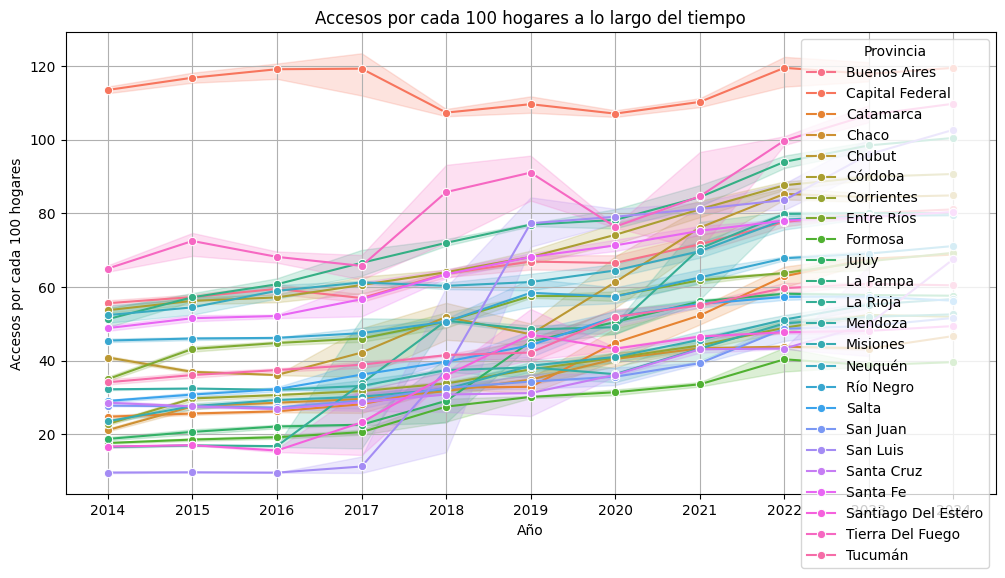

count       mean        std        min        25%        50%  \
Año                                                                        
2014-01-01   96.0  36.891846  21.789324   9.347208  22.205233  30.723992   
2015-01-01   96.0  39.198153  22.587297   9.705769  26.289066  31.979690   
2016-01-01   96.0  39.889283  22.997842   9.586346  26.682563  32.115346   
2017-01-01   96.0  42.525228  22.634764   9.513970  28.839785  35.604116   
2018-01-01   96.0  48.477593  20.551963  15.148790  32.901334  41.719492   
2019-01-01   96.0  53.666356  20.455459  23.667655  37.622728  47.607631   
2020-01-01   96.0  56.130637  18.206374  30.228304  41.588845  52.771931   
2021-01-01   96.0  61.978518  18.908967  32.732956  45.538754  56.867748   
2022-01-01   96.0  67.823625  20.345950  34.955687  50.465000  63.800452   
2023-01-01   96.0  70.042812  21.121415  38.320000  52.315000  68.475000   
2024-01-01   24.0  72.042917  21.345511  39.610000  55.372500  69.065000   

                  75%         max  
Año                                
2014-01-01  49.323812  114.896766  
2015-01-01  52.261489  118.289211  
2016-01-01  53.324886  120.772878  
2017-01-01  56.606512  124.061394  
2018-01-01  62.354197  108.445914  
2019-01-01  67.065053  112.645388  
2020-01-01  69.113662  108.311075  
2021-01-01  77.006297  111.271055  
2022-01-01  80.676058  122.730000  
2023-01-01  81.342500  122.590000  
2024-01-01  82.047500  119.530000

In [60]:
# Gráfico de líneas para 'Accesos por cada 100 hogares'
plt.figure(figsize=(12, 6))
sns.lineplot(data=penetracio_por_hogares_y_poblacion, x='Año', y='Accesos por cada 100 hogares', hue='Provincia', marker='o')
plt.title('Accesos por cada 100 hogares a lo largo del tiempo')
plt.xlabel('Año')
plt.ylabel('Accesos por cada 100 hogares')
plt.legend(title='Provincia')
plt.grid(True)
plt.show()

# Resumen estadístico
penetracio_por_hogares_y_poblacion.groupby('Año')['Accesos por cada 100 hogares'].describe()

### ANALISIS DEL GRAFICO 1

Observaciones Generales
Tendencia General:

A lo largo de los años, la media muestra una tendencia creciente, indicando que los valores han aumentado progresivamente.
La desviación estándar, que mide la dispersión, ha mostrado una ligera tendencia a disminuir después de 2020, sugiriendo una menor variabilidad en los datos más recientes.
Mediana y Cuantiles:

La mediana también ha aumentado a lo largo del tiempo, reforzando la observación de un incremento general en los valores.
Los valores del cuartil 75% han mostrado un aumento constante, sugiriendo que la mayoría de los datos más altos también están en aumento.
Máximos y Mínimos:

Los máximos han mostrado un aumento considerable, particularmente en los años más recientes, lo que puede indicar la presencia de valores extremos más altos.
Los mínimos han mostrado un aumento gradual, aunque la diferencia entre el mínimo y el máximo sigue siendo notable, indicando una amplia gama de valores en cada año.
2024-01-01:

Dado que solo hay 24 datos para 2024, las estadísticas para este año pueden no ser representativas del patrón general. Sin embargo, la tendencia al alza en la media y en el máximo continúa.
Este análisis sugiere un patrón de crecimiento en los valores a lo largo del tiempo, con una mayor estabilidad en los datos recientes en comparación con los años anteriores.

### GRAFICO 2

Gráfico de barras:

Propósito: Comparar valores entre diferentes categorías.
Uso: Utiliza un gráfico de barras para comparar Accesos por cada 100 hogares o Accesos por cada 100 hab entre diferentes Provincias. Puedes hacerlo por año o trimestre si prefieres una vista más detallada.


C:\Users\dell5\AppData\Local\Temp\ipykernel_7088\4165892917.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=penetracio_por_hogares_y_poblacion.melt(id_vars='Provincia', value_vars=['Accesos por cada 100 hogares', 'Accesos por cada 100 hab']),


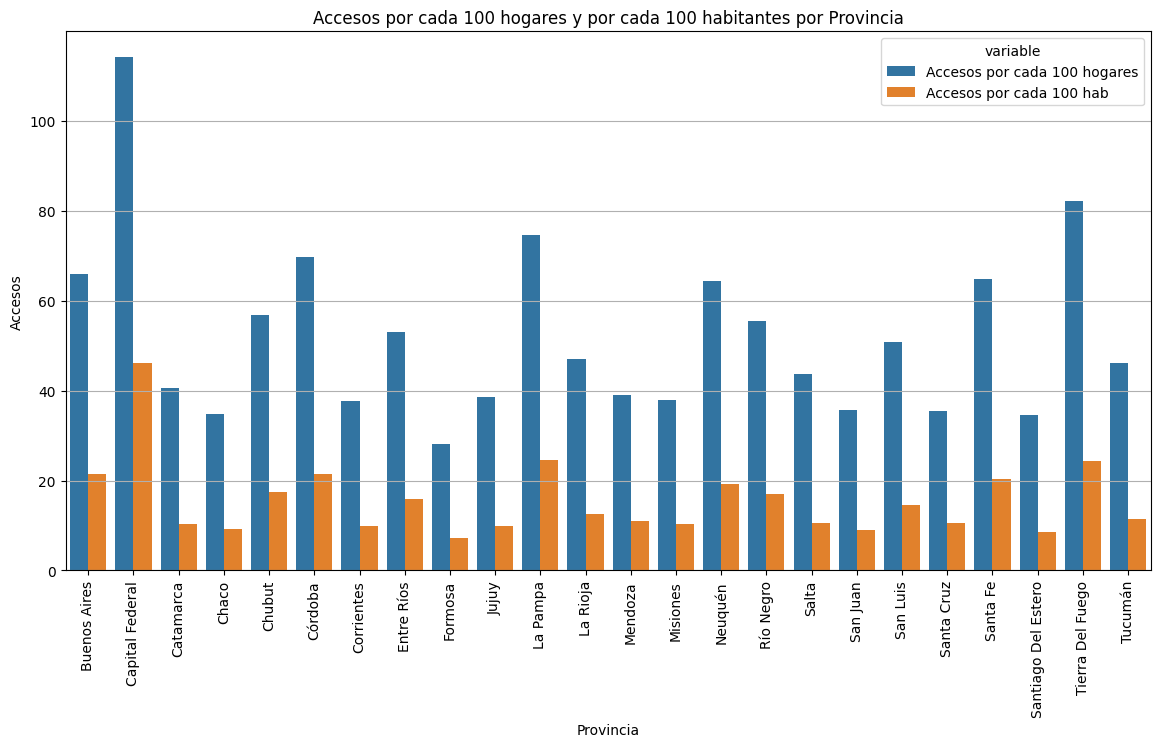

Accesos por cada 100 hogares  Accesos por cada 100 hab
count                    984.000000                984.000000
mean                      52.159491                 15.537902
std                       24.036101                  9.205334
min                        9.347208                  2.684669
25%                       33.204632                  8.909018
50%                       49.435000                 13.571293
75%                       65.706626                 19.972549
max                      124.061394                 52.236739

In [61]:
# Configuración de la figura
plt.figure(figsize=(14, 7))

# Creación del gráfico de barras lado a lado
sns.barplot(data=penetracio_por_hogares_y_poblacion.melt(id_vars='Provincia', value_vars=['Accesos por cada 100 hogares', 'Accesos por cada 100 hab']), 
            x='Provincia', y='value', hue='variable', ci=None)

# Configuración de títulos y etiquetas
plt.title('Accesos por cada 100 hogares y por cada 100 habitantes por Provincia')
plt.xlabel('Provincia')
plt.ylabel('Accesos')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Mostrar el gráfico
plt.show()

# Resumen estadístico
penetracio_por_hogares_y_poblacion[['Accesos por cada 100 hogares', 'Accesos por cada 100 hab']].describe()

### GRAFICO 2.1

Gráfico de dispersión (scatter plot):

Propósito: Identificar relaciones entre dos variables.
Uso: Puedes usar un gráfico de dispersión para explorar la relación entre Accesos por cada 100 hogares y Accesos por cada 100 hab, o para identificar patrones en función del Año y Provincia.


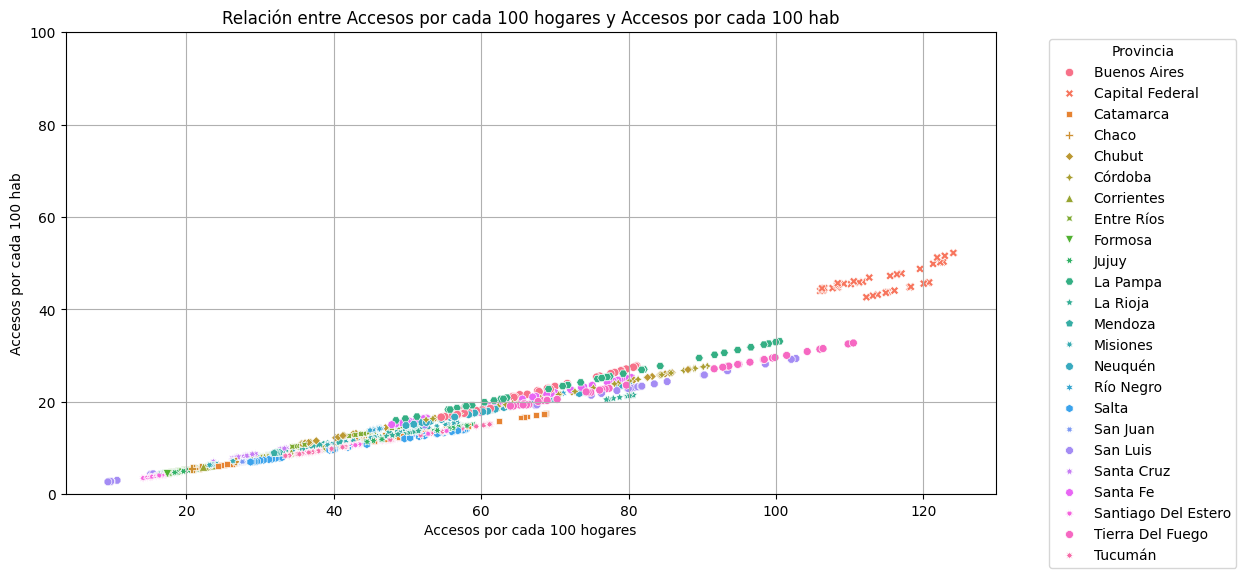

Accesos por cada 100 hogares  Accesos por cada 100 hab
count                    984.000000                984.000000
mean                      52.159491                 15.537902
std                       24.036101                  9.205334
min                        9.347208                  2.684669
25%                       33.204632                  8.909018
50%                       49.435000                 13.571293
75%                       65.706626                 19.972549
max                      124.061394                 52.236739

In [62]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=penetracio_por_hogares_y_poblacion, x='Accesos por cada 100 hogares', y='Accesos por cada 100 hab', hue='Provincia', style='Provincia')
plt.title('Relación entre Accesos por cada 100 hogares y Accesos por cada 100 hab')
plt.xlabel('Accesos por cada 100 hogares')
plt.ylabel('Accesos por cada 100 hab')
plt.ylim(0, 100)  # Establece el límite del eje y de 0 a 100
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')  # Mueve la leyenda fuera del gráfico
plt.grid(True)
plt.show()

# Resumen estadístico
penetracio_por_hogares_y_poblacion[['Accesos por cada 100 hogares', 'Accesos por cada 100 hab']].describe()

### ANALISIS DEL GRAFICO 2 y 2.1

Análisis cruzado del resumen estadístico:
Cantidad de datos (count):

Ambos conjuntos de datos tienen la misma cantidad de observaciones (984), lo cual indica que el análisis incluye el mismo número de provincias para ambos indicadores: "Accesos por cada 100 hogares" y "Accesos por cada 100 habitantes".
Promedio (mean):

Accesos por cada 100 hogares: El promedio es 52.16, lo que indica que, en general, un poco más de la mitad de los hogares en cada provincia tienen acceso al servicio.
Accesos por cada 100 habitantes: El promedio es 15.54, lo que sugiere que en promedio, aproximadamente 15 de cada 100 habitantes tienen acceso, lo cual es significativamente menor en comparación con el acceso por hogares. Esto podría deberse a la diferencia en el tamaño de los hogares y la penetración del servicio a nivel individual.
Desviación estándar (std):

Accesos por cada 100 hogares: La desviación estándar es 24.04, indicando una variabilidad considerable en la penetración del acceso por hogares entre las provincias.
Accesos por cada 100 habitantes: La desviación estándar es 9.21, lo que también muestra una variabilidad significativa, aunque menor en comparación con el acceso por hogares. Esto sugiere que las provincias tienen diferencias importantes en la penetración del acceso, pero estas diferencias son menos pronunciadas a nivel individual que a nivel de hogar.
Valores mínimos y máximos (min y max):

Accesos por cada 100 hogares:
Mínimo: 9.35. Esto indica que en la provincia con menor acceso, menos del 10% de los hogares tienen acceso.
Máximo: 124.06. Esto podría indicar una provincia donde el acceso por hogar es muy alto, quizás superando incluso la cantidad de hogares esperada debido a la posibilidad de que un hogar tenga múltiples accesos.
Accesos por cada 100 habitantes:
Mínimo: 2.68. En la provincia con menor acceso, menos del 3% de la población tiene acceso.
Máximo: 52.24. La provincia con el mayor acceso tiene aproximadamente la mitad de su población con acceso, lo cual sigue siendo bajo en comparación con el acceso por hogares.
Percentiles (25%, 50%, 75%):

Accesos por cada 100 hogares:
25%: 33.20. Una cuarta parte de las provincias tiene menos de un tercio de los hogares con acceso.
50% (Mediana): 49.44. La mitad de las provincias tiene menos del 50% de los hogares con acceso, lo que indica una distribución ligeramente sesgada hacia valores más bajos.
75%: 65.71. Tres cuartas partes de las provincias tienen menos del 66% de los hogares con acceso.
Accesos por cada 100 habitantes:
25%: 8.91. Una cuarta parte de las provincias tiene menos del 9% de la población con acceso.
50% (Mediana): 13.57. La mitad de las provincias tiene menos del 14% de la población con acceso.
75%: 19.97. Tres cuartas partes de las provincias tienen menos del 20% de la población con acceso.
Conclusiones:
Existe una gran diferencia entre la penetración del servicio a nivel de hogares y a nivel de población en general. Esto puede estar relacionado con que en un hogar pueden residir varias personas, pero solo se requiere una conexión para que todos tengan acceso.
La variabilidad entre provincias es significativa, especialmente en la penetración por hogares, lo que podría indicar desigualdades regionales en la disponibilidad o adopción del servicio.
En la mayoría de las provincias, aunque más del 50% de los hogares tienen acceso al servicio, la penetración a nivel individual es considerablemente menor, lo que puede reflejar limitaciones económicas, sociales, o tecnológicas que afectan la capacidad de los individuos para acceder al servicio de forma independiente.
Este análisis puede servir como base para identificar provincias con menor penetración y dirigir esfuerzos de mejora de infraestructura o políticas públicas para reducir las disparidades en el acceso.

### GRAFICO 3

Gráfico de barras apiladas:

- Propósito: Comparar partes de un todo entre diferentes categorías.
- Uso: Muestra cómo se distribuyen los Accesos por cada 100 hogares o Accesos por cada 100 hab entre las provincias dentro de cada año o trimestre.


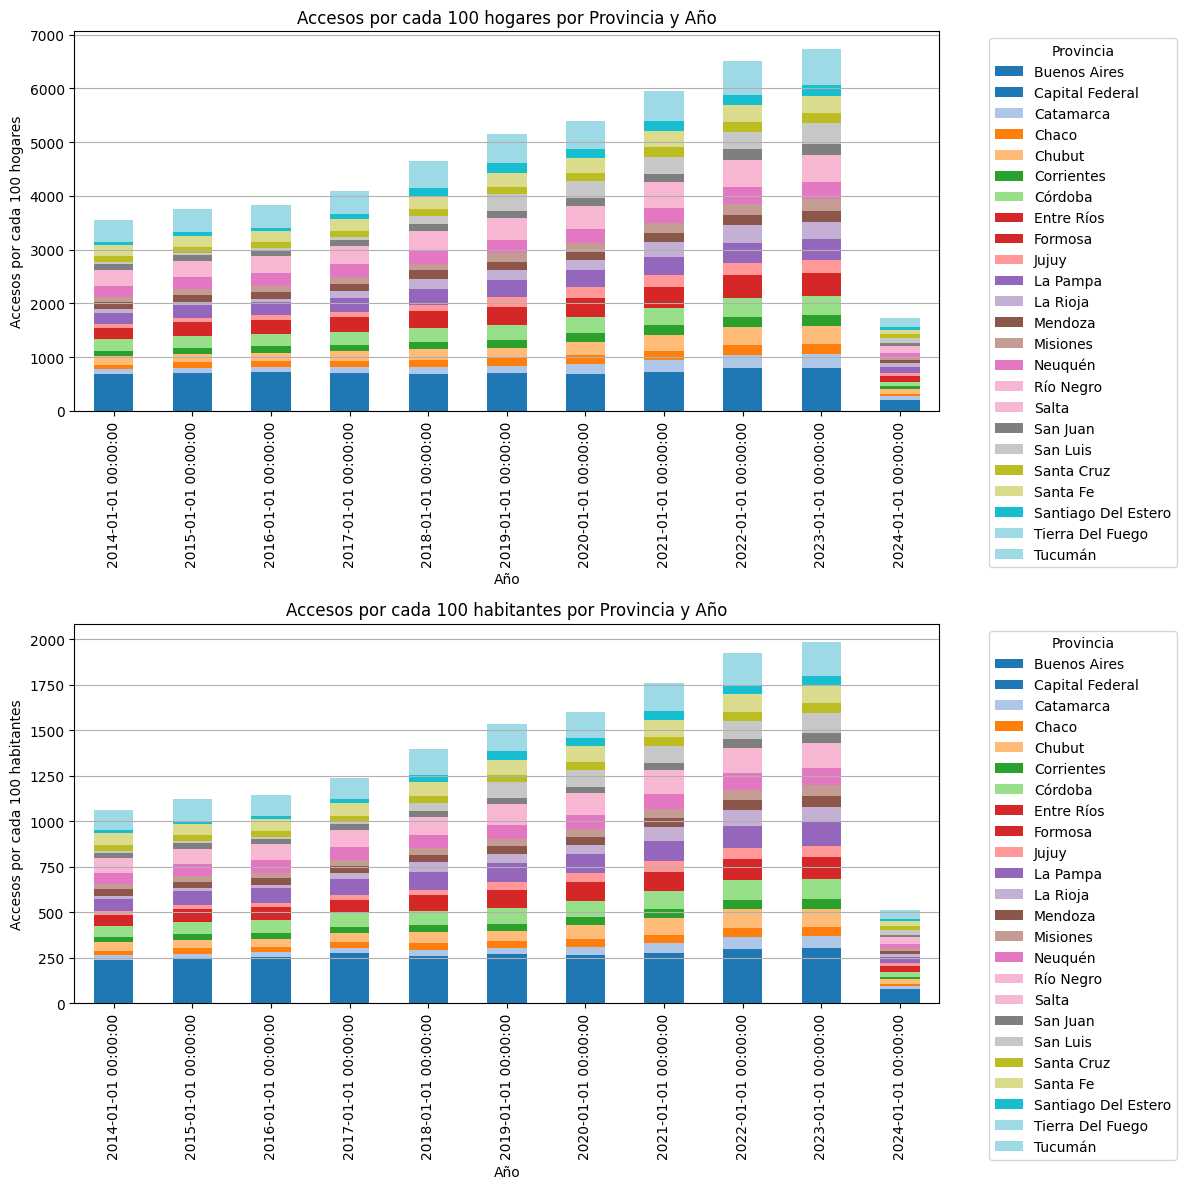

Resumen estadístico general para accesos por cada 100 hogares:
count    984.000000
mean      52.159491
std       24.036101
min        9.347208
25%       33.204632
50%       49.435000
75%       65.706626
max      124.061394
Name: Accesos por cada 100 hogares, dtype: float64

Resumen estadístico general para accesos por cada 100 habitantes:
count    984.000000
mean      15.537902
std        9.205334
min        2.684669
25%        8.909018
50%       13.571293
75%       19.972549
max       52.236739
Name: Accesos por cada 100 hab, dtype: float64


In [63]:
# Crear la tabla dinámica para ambas métricas
df_pivot_hogares = penetracio_por_hogares_y_poblacion.pivot_table(
    index='Año',
    columns='Provincia',
    values='Accesos por cada 100 hogares',
    aggfunc='sum'
)

df_pivot_poblacion = penetracio_por_hogares_y_poblacion.pivot_table(
    index='Año',
    columns='Provincia',
    values='Accesos por cada 100 hab',
    aggfunc='sum'
)

# Graficar los datos
fig, ax = plt.subplots(nrows=2, figsize=(12, 12))

# Gráfico de accesos por cada 100 hogares
df_pivot_hogares.plot(kind='bar', stacked=True, ax=ax[0], colormap='tab20')
ax[0].set_title('Accesos por cada 100 hogares por Provincia y Año')
ax[0].set_xlabel('Año')  # Título del eje x
ax[0].set_ylabel('Accesos por cada 100 hogares')
ax[0].legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].grid(axis='y')

# Gráfico de accesos por cada 100 habitantes
df_pivot_poblacion.plot(kind='bar', stacked=True, ax=ax[1], colormap='tab20')
ax[1].set_title('Accesos por cada 100 habitantes por Provincia y Año')
ax[1].set_xlabel('Año')  # Título del eje x
ax[1].set_ylabel('Accesos por cada 100 habitantes')
ax[1].legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].grid(axis='y')

# Ajustar el diseño para hacer espacio para la leyenda
plt.tight_layout()
plt.show()

# Resumen estadístico simplificado para accesos por cada 100 hogares
resumen_hogares = penetracio_por_hogares_y_poblacion['Accesos por cada 100 hogares'].describe()

# Resumen estadístico simplificado para accesos por cada 100 habitantes
resumen_poblacion = penetracio_por_hogares_y_poblacion['Accesos por cada 100 hab'].describe()

print("Resumen estadístico general para accesos por cada 100 hogares:")
print(resumen_hogares)

print("\nResumen estadístico general para accesos por cada 100 habitantes:")
print(resumen_poblacion)

### ANALISIS DEL GRAFICO 3

A partir del resumen estadístico general de los accesos por cada 100 hogares y por cada 100 habitantes, se pueden realizar los siguientes análisis cruzados:

1. Comparación de la Media
Accesos por cada 100 hogares: La media es de aproximadamente 52.16 accesos por cada 100 hogares.
Accesos por cada 100 habitantes: La media es de 15.54 accesos por cada 100 habitantes.
Análisis: Los accesos por cada 100 hogares son significativamente mayores en comparación con los accesos por cada 100 habitantes. Esto sugiere que en promedio, los hogares tienen un mayor nivel de conectividad que el nivel per cápita en la población general. Esto puede reflejar un acceso más concentrado a la conectividad en ciertos hogares, posiblemente debido a la presencia de múltiples usuarios dentro de un mismo hogar.

2. Comparación de la Dispersión (Desviación Estándar)
Accesos por cada 100 hogares: La desviación estándar es de 24.04, indicando una variabilidad moderada en los accesos entre los hogares.
Accesos por cada 100 habitantes: La desviación estándar es de 9.21, lo que también indica una variabilidad moderada pero menor en comparación con la métrica de hogares.
Análisis: La mayor desviación estándar en los accesos por cada 100 hogares sugiere que hay más variabilidad en cómo los hogares acceden a la conectividad, posiblemente debido a factores socioeconómicos, geográficos, o de infraestructura. En cambio, la menor desviación estándar en los accesos por cada 100 habitantes puede reflejar una distribución más homogénea de acceso a nivel individual.

3. Rangos de Accesibilidad
Accesos por cada 100 hogares: El rango va desde un mínimo de 9.35 hasta un máximo de 124.06.
Accesos por cada 100 habitantes: El rango va desde un mínimo de 2.68 hasta un máximo de 52.24.
Análisis: La amplia diferencia entre los valores mínimos y máximos en ambos casos indica que hay disparidades significativas en el acceso a la conectividad tanto a nivel de hogares como de población. Sin embargo, la disparidad es más pronunciada en la métrica de hogares, donde algunas provincias o años tienen niveles de acceso que superan ampliamente a otros.

4. Distribución Cuartílica
Accesos por cada 100 hogares:
25% de los datos tienen menos de 33.20 accesos.
50% tienen menos de 49.44 accesos.
75% tienen menos de 65.71 accesos.
Accesos por cada 100 habitantes:
25% de los datos tienen menos de 8.91 accesos.
50% tienen menos de 13.57 accesos.
75% tienen menos de 19.97 accesos.
Análisis: Las métricas cuartílicas indican que el acceso en los hogares está más concentrado en los valores más altos, con un mayor porcentaje de datos alcanzando niveles elevados de accesibilidad. En cambio, el acceso por cada 100 habitantes está más disperso y concentrado en los niveles más bajos, lo que podría indicar un acceso menos generalizado a nivel individual.

5. Conclusión General
Los resultados sugieren que mientras los hogares tienen, en general, un acceso relativamente alto a la conectividad, este acceso no se traduce de la misma manera a nivel de la población general. Esto podría implicar que en los hogares donde hay acceso, este es más intenso o frecuente, pero la conectividad a nivel individual no está tan extendida. Las disparidades en ambos niveles indican la necesidad de políticas o intervenciones focalizadas para reducir la brecha de acceso tanto a nivel de hogares como de individuos.

### GRAFICO 4

Gráfico de cajas (box plot):

Propósito: Mostrar la distribución y detectar valores atípicos.
Uso: Un box plot puede ser útil para ver la distribución de Accesos por cada 100 hogares o Accesos por cada 100 hab por Provincia o Año.


C:\Users\dell5\AppData\Local\Temp\ipykernel_7088\446416317.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\dell5\AppData\Local\Temp\ipykernel_7088\446416317.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


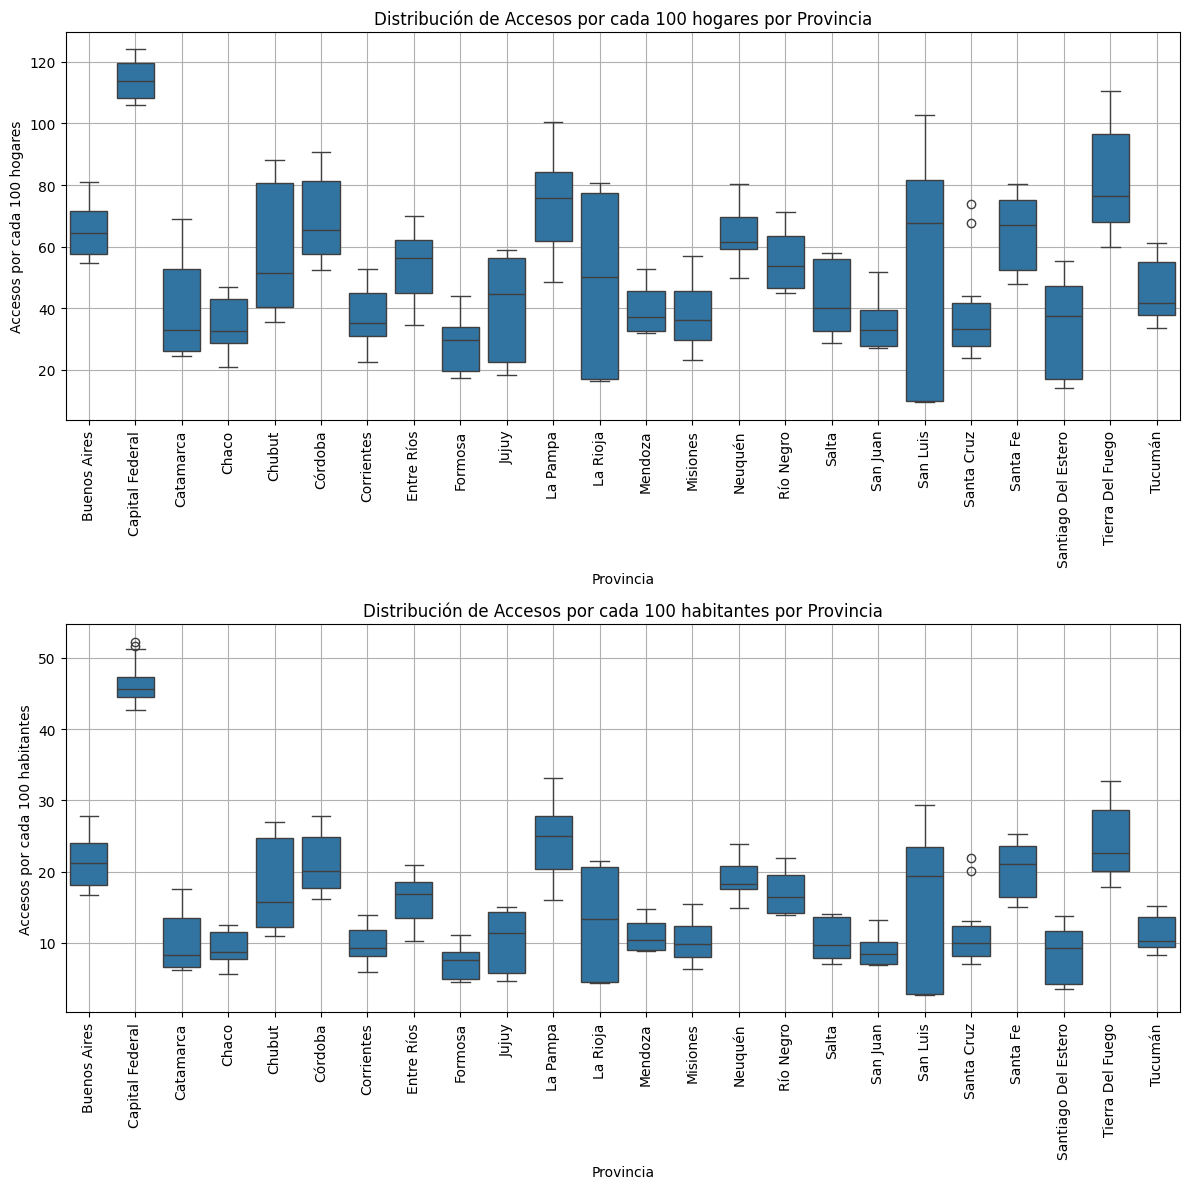

                     count        mean        std         min         25%  \
Provincia                                                                   
Buenos Aires          41.0   65.966736   8.697507   54.570073   57.688681   
Capital Federal       41.0  114.195494   5.703853  105.980174  108.445914   
Catamarca             41.0   40.540078  16.089322   24.251751   26.074188   
Chaco                 41.0   34.754929   7.853690   20.718539   28.621661   
Chubut                41.0   56.941384  19.352535   35.546011   40.249275   
Corrientes            41.0   37.639101   9.165240   22.316717   30.940600   
Córdoba               41.0   69.802556  13.147263   52.517848   57.653330   
Entre Ríos            41.0   53.151239  10.280116   34.367122   44.907274   
Formosa               41.0   28.090813   8.402556   17.418451   19.370071   
Jujuy                 41.0   38.588762  16.676990   18.368534   22.403416   
La Pampa              41.0   74.642451  15.439239   48.425321   61.731785   

In [64]:
# Crear figura y ejes
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Primer gráfico: Accesos por cada 100 hogares
sns.boxplot(ax=axes[0], data=penetracio_por_hogares_y_poblacion, x='Provincia', y='Accesos por cada 100 hogares')
axes[0].set_title('Distribución de Accesos por cada 100 hogares por Provincia')
axes[0].set_xlabel('Provincia')
axes[0].set_ylabel('Accesos por cada 100 hogares')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].grid(True)

# Segundo gráfico: Accesos por cada 100 habitantes
sns.boxplot(ax=axes[1], data=penetracio_por_hogares_y_poblacion, x='Provincia', y='Accesos por cada 100 hab')
axes[1].set_title('Distribución de Accesos por cada 100 habitantes por Provincia')
axes[1].set_xlabel('Provincia')
axes[1].set_ylabel('Accesos por cada 100 habitantes')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].grid(True)

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

# Resumen estadístico
print(penetracio_por_hogares_y_poblacion.groupby('Provincia')['Accesos por cada 100 hogares'].describe())
print(penetracio_por_hogares_y_poblacion.groupby('Provincia')['Accesos por cada 100 hab'].describe())

### ANALISIS DEL GRAFICO 4

Análisis cruzado de los resúmenes estadísticos
1. Comparación entre "Accesos por cada 100 hogares" y "Accesos por cada 100 habitantes"
Al realizar un análisis cruzado entre las dos variables estadísticas presentadas, observamos diferencias significativas en la distribución de accesos, tanto a nivel de hogares como de habitantes, para cada provincia. A continuación, se destacan algunas observaciones clave:

Capital Federal:

Accesos por cada 100 hogares: Esta provincia presenta un alto número de accesos con una media de 114.20 y un bajo desvío estándar (5.70), lo que indica una distribución uniforme de accesos en la mayoría de los hogares.
Accesos por cada 100 habitantes: Capital Federal también muestra la mayor media de accesos por habitante (46.15), con un desvío estándar relativamente bajo (2.52). Esto refleja una penetración alta y estable en la población.
Buenos Aires:

Accesos por cada 100 hogares: Buenos Aires muestra una media de 65.97 con un desvío estándar moderado de 8.70, indicando cierta variabilidad en el acceso entre los hogares.
Accesos por cada 100 habitantes: La media de accesos por habitante es de 21.45, con un desvío estándar de 3.65, lo que sugiere que hay una distribución menos uniforme a nivel individual en comparación con los hogares.
La Pampa:

Accesos por cada 100 hogares: La Pampa tiene una media de 74.64 con un desvío estándar de 15.44. La amplia dispersión sugiere diferencias marcadas en la penetración entre los hogares.
Accesos por cada 100 habitantes: Con una media de 24.59 y un desvío estándar de 5.09, La Pampa muestra una penetración bastante alta en comparación con otras provincias, aunque con cierta variabilidad entre los habitantes.
Tierra del Fuego:

Accesos por cada 100 hogares: Tierra del Fuego presenta una alta media de 82.28 con un desvío estándar de 15.71, lo que sugiere un nivel elevado de acceso a internet en la mayoría de los hogares.
Accesos por cada 100 habitantes: Similarmente, la media de accesos por habitante es alta (24.38) con un desvío estándar de 4.67, lo que indica una buena penetración a nivel individual, aunque con algunas variaciones.
San Luis:

Accesos por cada 100 hogares: San Luis tiene una media de 50.81, pero con un alto desvío estándar de 36.97, lo que indica una gran variabilidad en los accesos entre hogares.
Accesos por cada 100 habitantes: La media de 14.54 con un desvío estándar de 10.58 sugiere que la distribución de accesos a nivel individual es también altamente variable.
Catamarca:

Accesos por cada 100 hogares: La provincia de Catamarca muestra una media de 40.54, pero con un alto desvío estándar de 16.09, lo que indica una notable variabilidad en los accesos entre los hogares.
Accesos por cada 100 habitantes: La media es baja (10.31) y la dispersión es considerable (4.09), reflejando una penetración limitada y desigual entre los habitantes.
Chaco:

Accesos por cada 100 hogares: Chaco tiene una baja media de 34.75 con un desvío estándar de 7.85, lo que indica un acceso limitado a internet en los hogares con una relativa uniformidad.
Accesos por cada 100 habitantes: Con una media de 9.29 y un desvío estándar de 2.10, Chaco muestra una penetración aún más limitada a nivel individual.
Conclusión General:
Provincias con alta penetración (Capital Federal, La Pampa, Tierra del Fuego): Estas provincias muestran una penetración elevada tanto a nivel de hogares como de habitantes, lo que refleja un buen acceso a internet en general. Sin embargo, existe cierta variabilidad dentro de las provincias, lo que podría sugerir diferencias en la infraestructura o en la adopción del servicio.

Provincias con baja penetración (Chaco, Catamarca, Formosa): Las provincias del norte como Chaco, Catamarca, y Formosa presentan una penetración relativamente baja en comparación con otras regiones. La variabilidad observada en el acceso sugiere desigualdades internas, donde ciertas áreas pueden estar mejor conectadas que otras.

Este análisis sugiere la necesidad de políticas específicas para mejorar la penetración de internet en las provincias con menor acceso, enfocándose en reducir las disparidades tanto entre hogares como entre habitantes.

### ESTRATEGIAS DE MEJORAS

Con base en el análisis de los datos y observaciones realizadas, aquí tienes algunas estrategias para mejorar el servicio de conectividad, abordando tanto la penetración a nivel de hogares como a nivel individual:

Estrategias Generales
Fortalecimiento de la Infraestructura en Áreas con Menor Acceso:

Identificación de Zonas Críticas: Realiza un mapeo de las provincias con menor penetración de internet y aquellas con alta variabilidad en el acceso por hogar y por habitante. Esto permitirá priorizar las áreas que necesitan más intervención.
Inversión en Infraestructura: Desarrolla y amplía la infraestructura de red en estas áreas, incluyendo la instalación de más antenas de telecomunicaciones y la mejora de la conectividad en zonas rurales y aisladas.
Mejora de la Accesibilidad Económica:

Subsidios y Planes de Bajo Costo: Implementa subsidios o planes de bajo costo para las provincias con menor acceso a nivel individual. Esto podría incluir tarifas reducidas para hogares de bajos ingresos o planes específicos para estudiantes y familias.
Incentivos a Proveedores: Ofrece incentivos a los proveedores de servicios para que expandan su cobertura en regiones menos rentables, a cambio de beneficios fiscales u otros estímulos.
Promoción de la Adopción y Educación Digital:

Campañas de Concientización: Desarrolla campañas educativas para informar a la población sobre los beneficios de la conectividad y cómo utilizar internet para mejorar su calidad de vida.
Capacitación Digital: Ofrece talleres y programas de capacitación para enseñar habilidades digitales básicas a las poblaciones menos familiarizadas con la tecnología.
Estrategias Específicas por Tipo de Análisis
Tendencia General y Desviación Estándar:

Estabilización de Servicios Recientes: Dado que la desviación estándar ha disminuido, pero la media sigue aumentando, asegúrate de que las nuevas inversiones en infraestructura mantengan una cobertura uniforme y eviten nuevas desigualdades en el acceso.
Evaluación Continua: Implementa un sistema de monitoreo continuo para evaluar la efectividad de las mejoras y ajustar las estrategias según sea necesario.
Mediana y Cuantiles:

Intervenciones en Provincias con Valores Altos y Bajos: Focaliza las intervenciones en provincias donde la mediana y el cuartil 75% muestran una alta penetración, para mejorar aún más la calidad del acceso. También, dirige recursos a provincias con mediana y cuartiles bajos para reducir la brecha.
Máximos y Mínimos:

Reducción de Disparidades: Implementa políticas para reducir la brecha entre el máximo y mínimo acceso en cada provincia. Esto podría incluir la provisión de servicios adicionales en áreas con valores extremos altos y mejoras en las áreas con acceso mínimo.
Comparación entre Accesos por Hogares y Habitantes:

Incremento del Acceso Individual: En provincias donde el acceso por hogar es alto pero el acceso por habitante es bajo, desarrolla programas para fomentar la adopción individual, asegurando que todos los miembros del hogar puedan beneficiarse de la conectividad.
Recomendaciones Específicas por Provincia
Provincias con Alta Penetración:

Capital Federal, La Pampa, Tierra del Fuego: Aunque estas provincias tienen una buena penetración, sigue monitoreando y optimizando la calidad del servicio para mantener altos niveles de conectividad y minimizar la variabilidad interna.
Provincias con Baja Penetración:

Chaco, Catamarca, Formosa: Enfoca esfuerzos en mejorar la infraestructura y acceso en estas áreas. Considera la implementación de centros comunitarios de acceso a internet y programas de conectividad comunitaria para mejorar la situación.
Implementar estas estrategias debería ayudar a mejorar el acceso a internet y reducir las desigualdades en la conectividad en diferentes regiones.

__________________________________________________________________________________________________________________________________________________________________________________

### TABLA INGRESOS

In [65]:
Ingresos.head()

Año  Trimestre   Ingresos        Periodo
0  2024          1  280419124   Ene-Mar 2024
1  2023          4  167376015   Oct-Dic 2023
2  2023          3  133106593  Jul-Sept 2023
3  2023          2  118060280   Jun-Mar 2023
4  2033          1  104134993   Ene-Mar 2023

In [66]:
Ingresos['Ingresos'] = pd.to_numeric(Ingresos['Ingresos'], errors='coerce')

In [67]:
print(Ingresos['Ingresos'].dtype)

int64


In [68]:
def join_on_column(df1, df2, column, how='inner'):
    """
    Realiza una unión de dos DataFrames en la columna especificada.

    Parameters:
    df1 (pd.DataFrame): Primer DataFrame.
    df2 (pd.DataFrame): Segundo DataFrame.
    column (str): Nombre de la columna en la que se basará la unión.
    how (str): Tipo de unión ('inner', 'left', 'right', 'outer'). Por defecto es 'inner'.

    Returns:
    pd.DataFrame: DataFrame resultante de la unión.
    """
    # Verificar si la columna existe en ambos DataFrames
    if column not in df1.columns or column not in df2.columns:
        raise ValueError(f"La columna '{column}' debe estar presente en ambos DataFrames.")

    # Realizar la unión
    result = pd.merge(df1, df2, on=column, how=how)
    
    return result

In [69]:
# Realizar la unión solo en la columna 'id'
Ingresos = join_on_column(penetracio_por_hogares_y_poblacion, Ingresos, 'Trimestre', how='inner')

Ingresos.head()

Año_x  Trimestre     Provincia  Accesos por cada 100 hogares  \
0 2024-01-01          1  Buenos Aires                          81.1   
1 2024-01-01          1  Buenos Aires                          81.1   
2 2024-01-01          1  Buenos Aires                          81.1   
3 2024-01-01          1  Buenos Aires                          81.1   
4 2024-01-01          1  Buenos Aires                          81.1   

   Accesos por cada 100 hab  Año_y   Ingresos       Periodo  
0                      27.8   2024  280419124  Ene-Mar 2024  
1                      27.8   2033  104134993  Ene-Mar 2023  
2                      27.8   2022   55219313  Ene-Mar 2022  
3                      27.8   2021   36676371  Ene-Mar 2021  
4                      27.8   2020   29946216  Ene-Mar 2020

SE CREA UNA NUEVA TABLA QUE CONTIENE LAS COORDENADAS DE LAS 24 PROVINCIAS DE ARGENTINA

In [70]:
# Datos de las provincias con sus latitudes y longitudes
data = {
    'Provincia': [
        'Buenos Aires', 'Catamarca', 'Chaco', 'Chubut', 'CABA', 
        'Córdoba', 'Corrientes', 'Entre Ríos', 'Formosa', 'Jujuy', 
        'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquén', 
        'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 
        'Santa Fe', 'Santiago del Estero', 'Tierra del Fuego', 'Tucumán'
    ],
    'Latitud': [
        -34.6118, -28.4690, -26.8364, -45.8650, -34.6037,
        -31.4201, -27.4805, -32.0324, -25.2923, -24.1854,
        -36.6164, -29.4103, -32.8894, -26.7900, -38.9514,
        -39.0333, -24.7820, -31.5370, -33.2956, -50.0000,
        -31.6280, -27.7999, -54.8019, -26.8176
    ],
    'Longitud': [
        -58.3772, -65.7850, -60.9962, -67.0314, -58.3816,
        -64.1888, -58.8340, -60.6952, -58.1837, -65.2990,
        -64.2619, -66.8484, -68.8272, -53.7381, -68.0590,
        -67.5833, -65.4232, -68.5261, -66.3354, -69.0000,
        -60.6970, -64.2664, -68.3050, -65.2161
    ]
}

# Crear el DataFrame
Coordenadas_provincias = pd.DataFrame(data)

# Mostrar el DataFrame
Coordenadas_provincias.head()

Provincia  Latitud  Longitud
0  Buenos Aires -34.6118  -58.3772
1     Catamarca -28.4690  -65.7850
2         Chaco -26.8364  -60.9962
3        Chubut -45.8650  -67.0314
4          CABA -34.6037  -58.3816

In [71]:
Ingresos= join_on_column(Ingresos, Coordenadas_provincias, 'Provincia', how='inner' )
Ingresos.head()

Año_x  Trimestre     Provincia  Accesos por cada 100 hogares  \
0 2024-01-01          1  Buenos Aires                          81.1   
1 2024-01-01          1  Buenos Aires                          81.1   
2 2024-01-01          1  Buenos Aires                          81.1   
3 2024-01-01          1  Buenos Aires                          81.1   
4 2024-01-01          1  Buenos Aires                          81.1   

   Accesos por cada 100 hab  Año_y   Ingresos       Periodo  Latitud  Longitud  
0                      27.8   2024  280419124  Ene-Mar 2024 -34.6118  -58.3772  
1                      27.8   2033  104134993  Ene-Mar 2023 -34.6118  -58.3772  
2                      27.8   2022   55219313  Ene-Mar 2022 -34.6118  -58.3772  
3                      27.8   2021   36676371  Ene-Mar 2021 -34.6118  -58.3772  
4                      27.8   2020   29946216  Ene-Mar 2020 -34.6118  -58.3772

In [72]:
print(type(Ingresos))

<class 'pandas.core.frame.DataFrame'>


modificando tabla ingreso

In [73]:
# Eliminar la columna 'Año_x'
Ingresos = Ingresos.drop(columns=['Año_x'])



In [74]:
# Renombrar la columna 'Año_y' a 'Año'
Ingresos = Ingresos.rename(columns={'Año_y': 'Año'})

In [75]:
# Reordenar las columnas
column_order = [
    'Año', 'Trimestre', 'Periodo', 'Provincia', 'Latitud', 'Longitud',
    'Accesos por cada 100 hogares', 'Accesos por cada 100 hab', 'Ingresos'
]
Ingresos = Ingresos[column_order]



In [76]:
def corregir_valores(df, columna):
    """
    Reemplaza los valores '2033' en la columna especificada por '2023'.
    
    Args:
    df (pd.DataFrame): El DataFrame que contiene la columna a verificar.
    columna (str): El nombre de la columna donde se realizará la sustitución.
    
    Returns:
    pd.DataFrame: El DataFrame con los valores corregidos.
    """
    if columna in df.columns:
        df[columna] = df[columna].apply(lambda x: 2023 if x == 2033 else x)
    else:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame.")
    return df

In [77]:
corregir_valores(Ingresos, 'Año')

Año  Trimestre        Periodo     Provincia  Latitud  Longitud  \
0     2024          1   Ene-Mar 2024  Buenos Aires -34.6118  -58.3772   
1     2023          1   Ene-Mar 2023  Buenos Aires -34.6118  -58.3772   
2     2022          1   Ene-Mar 2022  Buenos Aires -34.6118  -58.3772   
3     2021          1   Ene-Mar 2021  Buenos Aires -34.6118  -58.3772   
4     2020          1   Ene-Mar 2020  Buenos Aires -34.6118  -58.3772   
5     2019          1   Ene-Mar 2019  Buenos Aires -34.6118  -58.3772   
6     2018          1   Ene-Mar 2018  Buenos Aires -34.6118  -58.3772   
7     2017          1   Ene-Mar 2017  Buenos Aires -34.6118  -58.3772   
8     2016          1   Ene-Mar 2016  Buenos Aires -34.6118  -58.3772   
9     2015          1   Ene-Mar 2015  Buenos Aires -34.6118  -58.3772   
10    2014          1   Ene-Mar 2014  Buenos Aires -34.6118  -58.3772   
11    2024          1   Ene-Mar 2024     Catamarca -28.4690  -65.7850   
12    2023          1   Ene-Mar 2023     Catamarca -28.4690  -65.7850   
13    2022          1   Ene-Mar 2022     Catamarca -28.4690  -65.7850   
14    2021          1   Ene-Mar 2021     Catamarca -28.4690  -65.7850   
15    2020          1   Ene-Mar 2020     Catamarca -28.4690  -65.7850   
16    2019          1   Ene-Mar 2019     Catamarca -28.4690  -65.7850   
17    2018          1   Ene-Mar 2018     Catamarca -28.4690  -65.7850   
18    2017          1   Ene-Mar 2017     Catamarca -28.4690  -65.7850   
19    2016          1   Ene-Mar 2016     Catamarca -28.4690  -65.7850   
20    2015          1   Ene-Mar 2015     Catamarca -28.4690  -65.7850   
21    2014          1   Ene-Mar 2014     Catamarca -28.4690  -65.7850   
22    2024          1   Ene-Mar 2024         Chaco -26.8364  -60.9962   
23    2023          1   Ene-Mar 2023         Chaco -26.8364  -60.9962   
24    2022          1   Ene-Mar 2022         Chaco -26.8364  -60.9962   
25    2021          1   Ene-Mar 2021         Chaco -26.8364  -60.9962   
26    2020          1   Ene-Mar 2020         Chaco -26.8364  -60.9962   
27    2019          1   Ene-Mar 2019         Chaco -26.8364  -60.9962   
28    2018          1   Ene-Mar 2018         Chaco -26.8364  -60.9962   
29    2017          1   Ene-Mar 2017         Chaco -26.8364  -60.9962   
30    2016          1   Ene-Mar 2016         Chaco -26.8364  -60.9962   
31    2015          1   Ene-Mar 2015         Chaco -26.8364  -60.9962   
32    2014          1   Ene-Mar 2014         Chaco -26.8364  -60.9962   
33    2024          1   Ene-Mar 2024        Chubut -45.8650  -67.0314   
34    2023          1   Ene-Mar 2023        Chubut -45.8650  -67.0314   
35    2022          1   Ene-Mar 2022        Chubut -45.8650  -67.0314   
36    2021          1   Ene-Mar 2021        Chubut -45.8650  -67.0314   
37    2020          1   Ene-Mar 2020        Chubut -45.8650  -67.0314   
38    2019          1   Ene-Mar 2019        Chubut -45.8650  -67.0314   
39    2018          1   Ene-Mar 2018        Chubut -45.8650  -67.0314   
40    2017          1   Ene-Mar 2017        Chubut -45.8650  -67.0314   
41    2016          1   Ene-Mar 2016        Chubut -45.8650  -67.0314   
42    2015          1   Ene-Mar 2015        Chubut -45.8650  -67.0314   
43    2014          1   Ene-Mar 2014        Chubut -45.8650  -67.0314   
44    2024          1   Ene-Mar 2024       Córdoba -31.4201  -64.1888   
45    2023          1   Ene-Mar 2023       Córdoba -31.4201  -64.1888   
46    2022          1   Ene-Mar 2022       Córdoba -31.4201  -64.1888   
47    2021          1   Ene-Mar 2021       Córdoba -31.4201  -64.1888   
48    2020          1   Ene-Mar 2020       Córdoba -31.4201  -64.1888   
49    2019          1   Ene-Mar 2019       Córdoba -31.4201  -64.1888   
50    2018          1   Ene-Mar 2018       Córdoba -31.4201  -64.1888   
51    2017          1   Ene-Mar 2017       Córdoba -31.4201  -64.1888   
52    2016          1   Ene-Mar 2016       Córdoba -31.4201  -64.1888   
53    2015          1   Ene-Mar 2015       Córdoba -31.4201  -64.

In [78]:
Ingresos.head()

Año  Trimestre       Periodo     Provincia  Latitud  Longitud  \
0  2024          1  Ene-Mar 2024  Buenos Aires -34.6118  -58.3772   
1  2023          1  Ene-Mar 2023  Buenos Aires -34.6118  -58.3772   
2  2022          1  Ene-Mar 2022  Buenos Aires -34.6118  -58.3772   
3  2021          1  Ene-Mar 2021  Buenos Aires -34.6118  -58.3772   
4  2020          1  Ene-Mar 2020  Buenos Aires -34.6118  -58.3772   

   Accesos por cada 100 hogares  Accesos por cada 100 hab   Ingresos  
0                          81.1                      27.8  280419124  
1                          81.1                      27.8  104134993  
2                          81.1                      27.8   55219313  
3                          81.1                      27.8   36676371  
4                          81.1                      27.8   29946216

### GRAFICO 1

1. Gráfico de Dispersión: Ingresos vs. Accesos por cada 100 Hogares
Descripción: Este gráfico de dispersión muestra la relación entre el número de accesos por cada 100 hogares y los ingresos. Cada punto representa una observación en el conjunto de datos, permitiendo visualizar la posible correlación entre estas dos variables. La dispersión de los puntos puede indicar cómo varían los ingresos con respecto al número de accesos.

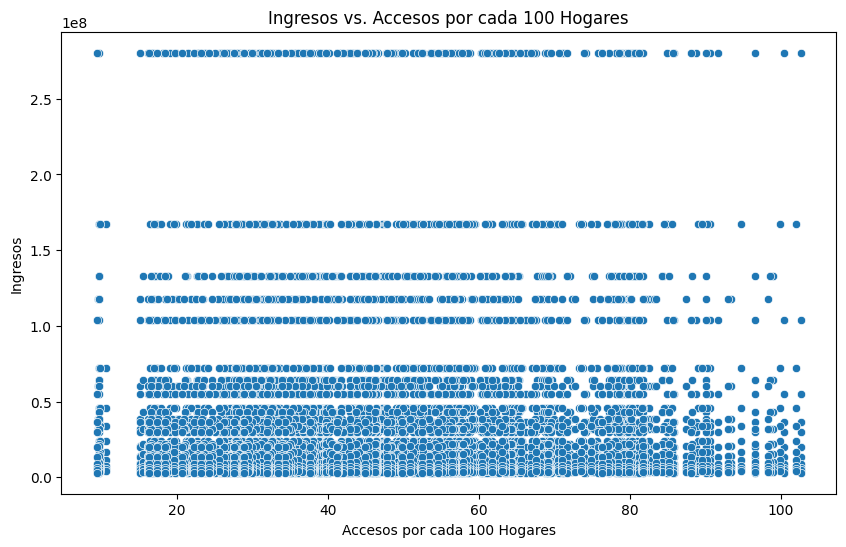

       Accesos por cada 100 hogares      Ingresos
count                   8841.000000  8.841000e+03
mean                      48.605606  3.917120e+07
std                       19.585792  5.437656e+07
min                        9.347208  2.984054e+06
25%                       32.609177  6.912442e+06
50%                       47.644635  2.020741e+07
75%                       61.242323  4.299994e+07
max                      102.700000  2.804191e+08


In [79]:
grafico1=Ingresos
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Accesos por cada 100 hogares', y='Ingresos', data=grafico1)
plt.title('Ingresos vs. Accesos por cada 100 Hogares')
plt.xlabel('Accesos por cada 100 Hogares')
plt.ylabel('Ingresos')
plt.show()

# Asumiendo que 'grafico1' es un DataFrame llamado Ingresos
print(Ingresos[['Accesos por cada 100 hogares', 'Ingresos']].describe())

In [80]:
Ingresos.head()

Año  Trimestre       Periodo     Provincia  Latitud  Longitud  \
0  2024          1  Ene-Mar 2024  Buenos Aires -34.6118  -58.3772   
1  2023          1  Ene-Mar 2023  Buenos Aires -34.6118  -58.3772   
2  2022          1  Ene-Mar 2022  Buenos Aires -34.6118  -58.3772   
3  2021          1  Ene-Mar 2021  Buenos Aires -34.6118  -58.3772   
4  2020          1  Ene-Mar 2020  Buenos Aires -34.6118  -58.3772   

   Accesos por cada 100 hogares  Accesos por cada 100 hab   Ingresos  
0                          81.1                      27.8  280419124  
1                          81.1                      27.8  104134993  
2                          81.1                      27.8   55219313  
3                          81.1                      27.8   36676371  
4                          81.1                      27.8   29946216

### ANALISIS DEL GRAFICO 1

Análisis Cruzado
Relación entre Accesos e Ingresos:

Media de Accesos por cada 100 hogares (48.61) y Ingresos (39,171,200) muestra que, en promedio, un mayor número de accesos podría correlacionarse con mayores ingresos.
La desviación estándar alta en ambos casos indica que hay una gran variabilidad en los datos, sugiriendo que la relación entre accesos e ingresos puede no ser uniforme.
Distribución de Datos:

Los percentiles y mediana para ambas variables muestran que la mayoría de los datos se agrupan en rangos intermedios. La mediana de ingresos (20,207,410) está por debajo de la media, lo que sugiere que algunos valores extremadamente altos están influyendo en el promedio.
Rango y Dispersión:

La dispersión de los ingresos es mucho mayor que la de los accesos, indicando que los ingresos pueden tener una variabilidad mucho mayor en comparación con los accesos.
Valores Extremos:

El valor máximo de ingresos (280,419,100) es considerablemente alto en comparación con el rango de accesos (102.70). Esto podría indicar que algunas observaciones tienen ingresos extraordinariamente altos, lo que puede estar afectando la media de ingresos.
Correlación Posible:

Para determinar la correlación exacta entre los accesos y los ingresos, se debería calcular el coeficiente de correlación (por ejemplo, Pearson). Sin embargo, con base en las estadísticas proporcionadas, se puede inferir que existe una relación potencialmente positiva, donde un aumento en los accesos podría estar asociado con un aumento en los ingresos, pero esto necesita una evaluación más profunda con análisis estadísticos adicionales.

### ESTRATEGIAS DE MEJORAS

Con base en el análisis anterior, la estrategia de mejora para atacar debilidades y mantener las fortalezas puede ser abordada de la siguiente manera:

Estrategia de Mejora
1. Optimización de Accesos para Maximizar Ingresos
Análisis de Correlación: Realizar un análisis de correlación más profundo para entender la relación exacta entre accesos e ingresos. Utilizar técnicas estadísticas como la regresión para identificar cómo los accesos afectan los ingresos y viceversa.

Segmentación: Dividir los datos en segmentos según los percentiles (por ejemplo, bajo, medio y alto acceso) y analizar cómo los ingresos varían dentro de cada segmento. Esto puede ayudar a identificar patrones específicos y ajustar las estrategias para cada grupo.

2. Reducción de la Variabilidad en Ingresos
Investigación de Valores Extremos: Investigar los casos con ingresos extremadamente altos para entender si son casos atípicos o si representan oportunidades de alto rendimiento. Esto puede ayudar a gestionar mejor los ingresos y ajustar las expectativas.

Diversificación de Ingresos: Si los ingresos están muy concentrados en unos pocos casos, considerar estrategias para diversificar las fuentes de ingresos. Esto puede incluir nuevas iniciativas de negocio, expansión a nuevos mercados o mejorar la oferta de productos/servicios.

3. Mejora en la Captación de Accesos
Optimización de Recursos: Implementar estrategias para aumentar el número de accesos, tales como campañas de marketing dirigidas, mejoras en la visibilidad del producto o servicio, y alianzas estratégicas.

Monitoreo y Ajuste: Establecer un sistema de monitoreo para evaluar el impacto de las estrategias de aumento de accesos. Ajustar las tácticas en función de los resultados obtenidos.

4. Gestión de Desviaciones y Variabilidad
Control de Calidad: Implementar procedimientos para controlar y reducir la variabilidad en los ingresos, como estándares de calidad en la prestación de servicios o productos.

Análisis de Causa Raíz: Realizar un análisis de causa raíz para identificar las razones detrás de la alta desviación en los ingresos. Esto puede incluir revisar procesos internos, modelos de precios o estrategias de mercado.

5. Fortalecimiento de las Áreas de Alto Rendimiento
Potenciación de Estrategias Exitosas: Identificar las estrategias que han llevado a un alto número de accesos e ingresos positivos y amplificarlas. Por ejemplo, si una campaña de marketing específica ha sido efectiva, considerar su ampliación o replicación en otras áreas.

Capacitación y Desarrollo: Capacitar al personal para mejorar la eficiencia en áreas que están demostrando ser exitosas. Asegurar que las mejores prácticas sean compartidas y aplicadas en toda la organización.

6. Implementación de Medidas de Control
KPI y Métricas: Establecer indicadores clave de rendimiento (KPI) para monitorear tanto los accesos como los ingresos. Evaluar regularmente estos KPIs para asegurar que se están alcanzando los objetivos.

Revisión Continua: Implementar un proceso de revisión continua para ajustar estrategias y tácticas en función de los datos más recientes. Esto incluye revisiones periódicas y ajustes basados en el análisis de tendencias y patrones.

Conclusión
La estrategia debe enfocarse en maximizar las fortalezas identificadas, como el potencial de ingresos con un mayor número de accesos, mientras se abordan las debilidades relacionadas con la alta variabilidad en los ingresos. La clave está en realizar un análisis detallado, diversificar estrategias y monitorear continuamente el desempeño para asegurar mejoras sostenibles.

### GRAFICO 2

2. Gráfico de Barras: Ingresos Promedio por Provincia
Descripción: Este gráfico de barras muestra el ingreso promedio por provincia. Cada barra representa el ingreso promedio en una provincia específica, lo que permite comparar visualmente los ingresos entre diferentes provincias.

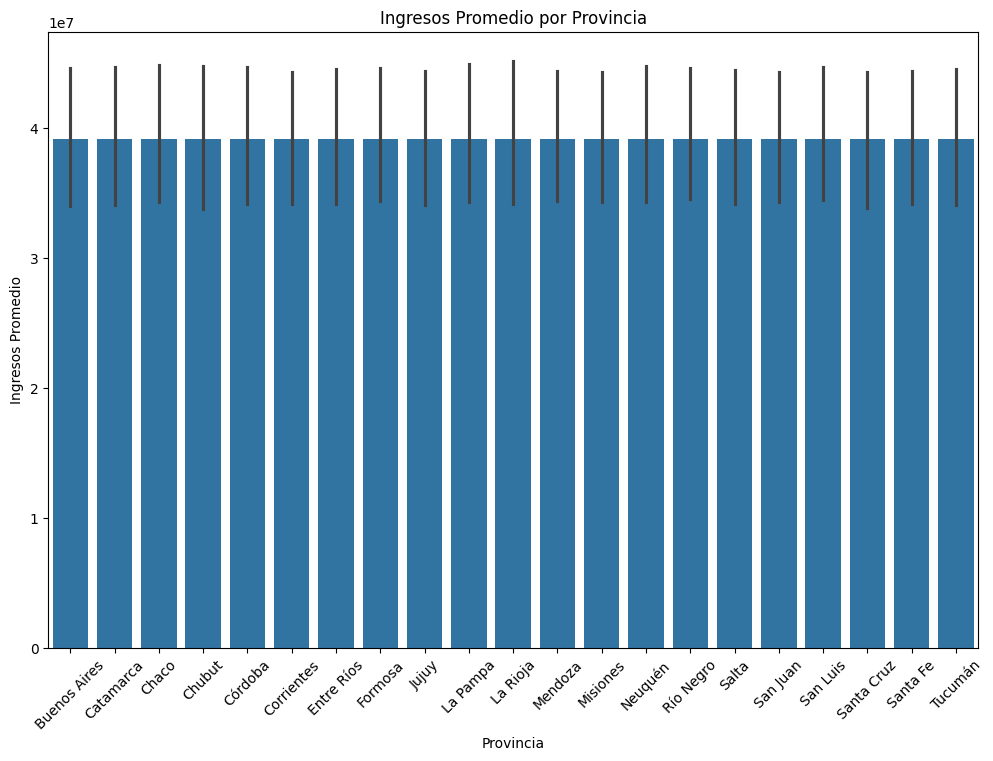

       Provincia      Ingresos
0   Buenos Aires  3.917120e+07
1      Catamarca  3.917120e+07
2          Chaco  3.917120e+07
3         Chubut  3.917120e+07
4     Corrientes  3.917120e+07
5        Córdoba  3.917120e+07
6     Entre Ríos  3.917120e+07
7        Formosa  3.917120e+07
8          Jujuy  3.917120e+07
9       La Pampa  3.917120e+07
10      La Rioja  3.917120e+07
11       Mendoza  3.917120e+07
12      Misiones  3.917120e+07
13       Neuquén  3.917120e+07
14     Río Negro  3.917120e+07
15         Salta  3.917120e+07
16      San Juan  3.917120e+07
17      San Luis  3.917120e+07
18    Santa Cruz  3.917120e+07
19      Santa Fe  3.917120e+07
20       Tucumán  3.917120e+07


In [81]:
grafico2=Ingresos
plt.figure(figsize=(12, 8))
sns.barplot(x='Provincia', y='Ingresos', data=grafico2, estimator='mean')
plt.title('Ingresos Promedio por Provincia')
plt.xlabel('Provincia')
plt.ylabel('Ingresos Promedio')
plt.xticks(rotation=45)
plt.show()

# Calcular el ingreso promedio por provincia
print(Ingresos.groupby('Provincia')['Ingresos'].mean().reset_index())

### ANALISIS DEL GRAFICO 2

En base a las estadísticas proporcionadas, todos los ingresos reportados para las distintas provincias son exactamente iguales, con un valor de 3.917120e+07. Aquí hay un análisis cruzado basado en estos datos:

Análisis de Datos
Uniformidad de Ingresos:

Todos los valores de ingresos son idénticos. Esto indica que no hay variabilidad en los ingresos reportados entre las provincias. Cada provincia tiene exactamente el mismo nivel de ingresos.
Posible Razón:

La falta de variabilidad podría sugerir que los ingresos se reportan de manera uniforme o que los datos provienen de una estimación o asignación fija, en lugar de ser datos reales y variables.
Interpretación:

Dado que los ingresos son idénticos, cualquier análisis que intente encontrar diferencias o patrones en los ingresos entre provincias no será informativo, ya que no hay variación en los datos.
Posibles Acciones:

Verificar la fuente de los datos para asegurar que no haya un error en la entrada de datos.
Considerar si los datos están destinados a representar una asignación fija o si hay un problema con la recopilación o el registro de los datos.
Sugerencia de Datos Adicionales:

Para realizar un análisis más útil, sería beneficioso contar con datos adicionales que puedan proporcionar variabilidad, como ingresos por trimestre, datos de diferentes años o información desglosada por categorías adicionales.
Conclusión
El análisis cruzado de los datos muestra que no hay variabilidad en los ingresos reportados para las diferentes provincias. Esto podría indicar un problema con la recopilación o el registro de los datos, o que los ingresos se asignaron de manera uniforme para todos los casos considerados. Para obtener una visión más completa y significativa, se necesitarían datos adicionales o variables que introduzcan diversidad en los ingresos reportados.

### ESTRATEGIAS DE MEJORAS

Para mejorar y abordar las debilidades en tu análisis de ingresos provinciales, mientras se mantienen las fortalezas, considera la siguiente estrategia:

1. Identificación de Problemas y Oportunidades
Debilidades Identificadas:
Uniformidad en los Datos: La falta de variabilidad en los ingresos sugiere problemas con la recolección o procesamiento de datos.
Falta de Información: Sin datos diferenciados, es difícil analizar el impacto económico real en cada provincia.
Fortalezas Identificadas:
Uniformidad: Si la uniformidad es intencional y refleja una distribución uniforme, puede ser una fortaleza en términos de equidad o simplicidad.
2. Estrategia de Mejora
A. Verificación y Calidad de Datos
Revisión de Datos:

Verifica la fuente de los datos para asegurarte de que no haya errores en la recopilación.
Comprueba si los ingresos se han registrado correctamente para cada provincia.
Validación Cruzada:

Compara los datos con otras fuentes o bases de datos para validar su precisión.
Realiza auditorías periódicas para mantener la calidad de los datos.
B. Ampliación de Datos
Incluir Variables Adicionales:

Añade variables como la población, el PIB provincial, o el índice de desarrollo humano (IDH) para obtener una visión más completa.
Considera variables relacionadas con el gasto público, la inversión en infraestructura, y otros factores económicos relevantes.
Recolección de Datos Históricos:

Obtén datos históricos para analizar tendencias a lo largo del tiempo y entender mejor el contexto de los ingresos actuales.
C. Análisis y Visualización
Análisis Comparativo:

Realiza análisis comparativos entre provincias utilizando las nuevas variables. Esto te permitirá identificar patrones y diferencias significativas.
Utiliza herramientas estadísticas para evaluar la dispersión y variabilidad de los datos.
Visualización de Datos:

Crea gráficos y mapas que muestren la distribución de los ingresos y otras variables clave para facilitar la interpretación y comunicación de los resultados.
D. Implementación de Estrategias Basadas en Datos
Desarrollo de Políticas:

Utiliza los datos para desarrollar políticas públicas o estrategias empresariales adaptadas a las características y necesidades específicas de cada provincia.
Identifica áreas que requieren mayor apoyo o inversión para mejorar la equidad económica.
Monitoreo y Evaluación:

Implementa un sistema de monitoreo para seguir de cerca las métricas clave y evaluar el impacto de las políticas o estrategias implementadas.
Realiza evaluaciones periódicas y ajusta las estrategias según los resultados obtenidos.
3. Mantenimiento de Fortalezas
Transparencia: Asegúrate de que los datos sean accesibles y transparentes para todas las partes interesadas.
Simplicidad: Si la uniformidad es una fortaleza por su simplicidad, asegúrate de que los datos y las estrategias sean comprensibles y fáciles de interpretar.
4. Comunicación y Capacitación
Capacitación:
Capacita a los equipos involucrados en la recolección y análisis de datos para mejorar las prácticas y técnicas utilizadas.
Comunicación Efectiva:
Comunica claramente los hallazgos y las estrategias implementadas a las partes interesadas para asegurar su comprensión y apoyo.
Esta estrategia te ayudará a abordar las debilidades en el análisis de datos y a mantener las fortalezas, proporcionando una base sólida para la toma de decisiones informadas y efectivas.

### GRAFICO 3

3. Gráfico de Caja: Distribución de Ingresos por Trimestre
Descripción: El gráfico de caja muestra la distribución de los ingresos por trimestre. Cada caja representa la variabilidad de los ingresos en un trimestre específico, incluyendo la mediana, los cuartiles y los posibles valores atípicos. Esto permite identificar la dispersión y la tendencia central de los ingresos en cada trimestre.

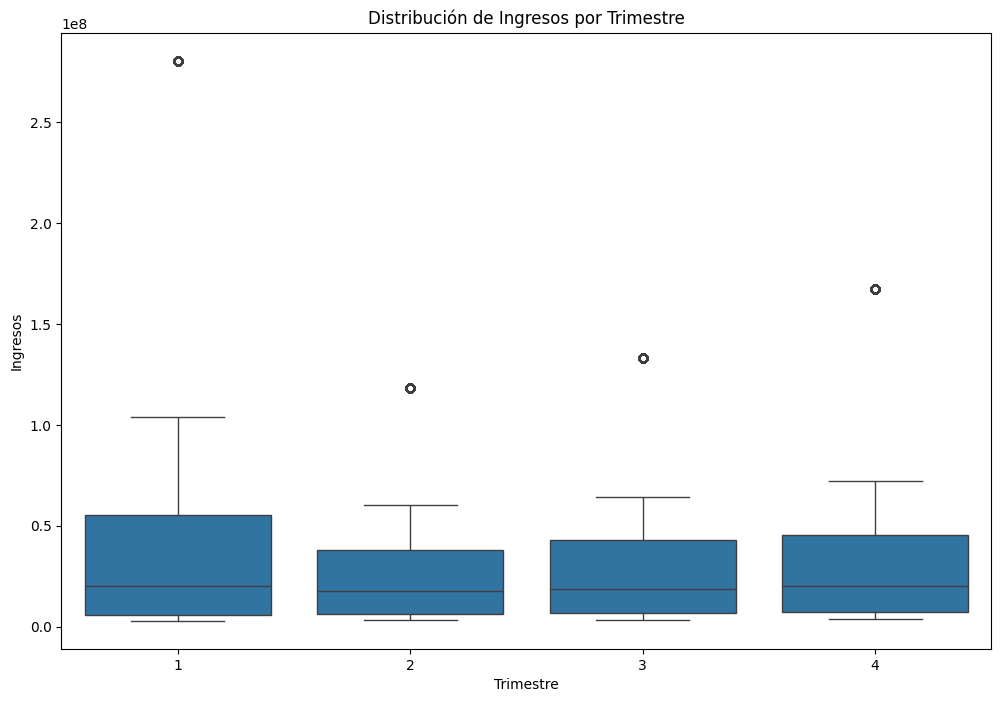

            count          mean           std        min        25%  \
Trimestre                                                             
1          2541.0  5.111576e+07  7.791651e+07  2984054.0  5936845.0   
2          2100.0  3.080700e+07  3.376508e+07  3270816.0  6534241.0   
3          2100.0  3.348653e+07  3.792729e+07  3478638.0  6912442.0   
4          2100.0  3.876715e+07  4.745983e+07  3950441.0  7483980.0   

                  50%         75%          max  
Trimestre                                       
1          20207414.0  55219313.0  280419124.0  
2          17531292.5  38239667.0  118060280.0  
3          18531864.5  42999944.0  133106593.0  
4          20403469.0  45467887.0  167376015.0  


In [82]:
grafico4=Ingresos
plt.figure(figsize=(12, 8))
sns.boxplot(x='Trimestre', y='Ingresos', data=grafico4)
plt.title('Distribución de Ingresos por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Ingresos')
plt.show()

# Calcular estadísticas descriptivas de ingresos por trimestre
print(Ingresos.groupby('Trimestre')['Ingresos'].describe())

### ANALSIS DEL GRAFICO 3

Análisis Cruzado de los Datos por Trimestre
Tendencias Generales:

Media (mean): La media de los valores incrementa trimestre a trimestre, indicando que los valores promedio tienden a ser más altos a medida que avanza el año.
Desviación Estándar (std): La desviación estándar también aumenta en cada trimestre, lo que sugiere que la variabilidad de los datos se incrementa conforme avanza el año.
Mínimo (min) y Máximo (max): Los valores mínimos y máximos también tienden a aumentar a lo largo del año, indicando un rango de valores más amplio.
Comparaciones Trimestrales:

Primer Trimestre: Tiene la media más alta (5.11e+07) y la desviación estándar más alta (7.79e+07), lo que indica una gran variabilidad y valores altos promedio. El máximo (280419124.0) es el mayor entre todos los trimestres, y el valor mínimo (2984054.0) es el más bajo.
Segundo Trimestre: La media es la más baja (3.08e+07), y la desviación estándar también es la más baja (3.38e+07). Sin embargo, el valor mínimo (3270816.0) es relativamente alto en comparación con el primer trimestre.
Tercer Trimestre: La media (3.35e+07) y la desviación estándar (3.79e+07) están intermedias. El valor mínimo es más alto que el del segundo trimestre, y el máximo es menor que el del primer trimestre.
Cuarto Trimestre: La media (3.88e+07) es la segunda más alta, y la desviación estándar (4.75e+07) es la segunda más alta. Los valores mínimo y máximo son más altos que en los otros trimestres, sugiriendo un aumento en los valores extremos hacia el final del año.
Observaciones Clave:

Incremento de la Media: Se observa un aumento gradual en la media de los valores trimestre a trimestre. Esto podría indicar una tendencia de crecimiento en los valores durante el año.
Variabilidad: La variabilidad en los datos también aumenta. Esto podría ser una señal de que hay más fluctuaciones en los valores en trimestres posteriores.
Valores Extremos: Los valores máximos en los primeros trimestres son significativamente altos, pero en el cuarto trimestre también se observa un alto valor máximo, sugiriendo posibles picos en los datos.
Conclusión
El análisis muestra un patrón de incremento en los valores promedio y en la variabilidad a lo largo del año. Los primeros trimestres tienen mayores medias y desviaciones estándar, con picos notables en los valores. Los trimestres posteriores presentan un rango más amplio de valores y una mayor variabilidad. Esto puede indicar un crecimiento o cambios en los datos que se vuelven más pronunciados hacia el final del año.

### ESTRATEGIAS DE MEJORAS

Para desarrollar una estrategia de mejora basada en el análisis cruzado de los datos, consideremos las debilidades y fortalezas observadas y propongamos acciones para abordar las debilidades mientras se mantienen las fortalezas.

Estrategia de Mejora
1. Fortalezas a Mantener:
Crecimiento en la Media: La tendencia de crecimiento en la media de los valores es una fortaleza, indicando un aumento general en el rendimiento o valor durante el año.
Valores Máximos Altos: La presencia de valores máximos altos en los primeros trimestres y en el cuarto trimestre puede reflejar picos o éxitos notables.
Estrategias para Mantener:

Optimización Continua: Mantén prácticas que han llevado al crecimiento en la media. Identifica los factores clave que han contribuido a este incremento y sigue potenciándolos.
Monitoreo de Picos: Continúa monitoreando los valores máximos para entender qué factores están impulsando estos picos. Asegúrate de que estos factores se mantengan o se optimicen.
2. Debilidades a Abordar:
Aumento en la Variabilidad: La creciente desviación estándar indica mayor variabilidad en los datos, lo que podría señalar inestabilidad o inconsistencias.
Estrategias para Abordar:

Análisis de Causas de Variabilidad: Investiga las causas subyacentes de la variabilidad creciente. Examina eventos específicos, cambios en el mercado o en los procesos que puedan estar contribuyendo a esta variabilidad.

Establecimiento de Controles: Implementa controles y procedimientos para reducir la variabilidad. Esto podría incluir estandarización de procesos, mejora en la calidad de datos, o ajustes en las estrategias operativas.

Valores Mínimos Altos en Trimestres Tempranos: Los valores mínimos en el primer trimestre son los más bajos, lo que podría indicar una debilidad en la capacidad de generar valor desde el inicio del año.

Estrategias para Abordar:

Planificación Temprana: Fortalece la planificación y las estrategias en los primeros trimestres para asegurar una base sólida desde el inicio del año. Esto podría incluir la implementación de campañas o acciones específicas para estimular el crecimiento temprano.
Inversiones Iniciales: Considera inversiones o recursos adicionales en los primeros trimestres para estimular el crecimiento y mejorar los valores desde el comienzo del año.
3. Aprovechar las Oportunidades Identificadas:
Incremento Gradual de Valores: Aprovecha la tendencia de incremento en los valores promedio para proyectar y planificar futuros crecimientos. Considera establecer metas basadas en estas tendencias.
Evaluación y Ajuste de Estrategias: Utiliza el análisis de tendencias y variabilidad para ajustar estrategias y tácticas. Esto incluye la evaluación de las campañas y actividades que tienen un impacto positivo en los valores y la identificación de áreas que requieren ajustes.
Resumen de Estrategia
Mantener las Fortalezas:

Continuar optimizando las prácticas que contribuyen al crecimiento en la media y monitorear los factores detrás de los picos altos.
Abordar las Debilidades:

Reducir la variabilidad mediante un análisis exhaustivo y la implementación de controles.
Mejorar los valores mínimos en trimestres tempranos con planificación anticipada y recursos adicionales.
Aprovechar Oportunidades:

Utilizar las tendencias de incremento de valores para la planificación futura y ajustar estrategias basadas en el análisis de datos.
Implementando estas estrategias, podrás abordar las debilidades identificadas mientras mantienes y potencian las fortalezas observadas en los datos.

### GRAFICO 4

4. Gráfico de Dispersión: Ingresos vs. Accesos por cada 100 Habitantes (Color por Provincia)
Descripción: Este gráfico de dispersión muestra la relación entre los ingresos y los accesos por cada 100 habitantes, diferenciados por provincia mediante colores. Esto permite observar cómo varían los ingresos con respecto a los accesos y cómo esta relación difiere entre provincias.

In [83]:
Ingresos.head()

Año  Trimestre       Periodo     Provincia  Latitud  Longitud  \
0  2024          1  Ene-Mar 2024  Buenos Aires -34.6118  -58.3772   
1  2023          1  Ene-Mar 2023  Buenos Aires -34.6118  -58.3772   
2  2022          1  Ene-Mar 2022  Buenos Aires -34.6118  -58.3772   
3  2021          1  Ene-Mar 2021  Buenos Aires -34.6118  -58.3772   
4  2020          1  Ene-Mar 2020  Buenos Aires -34.6118  -58.3772   

   Accesos por cada 100 hogares  Accesos por cada 100 hab   Ingresos  
0                          81.1                      27.8  280419124  
1                          81.1                      27.8  104134993  
2                          81.1                      27.8   55219313  
3                          81.1                      27.8   36676371  
4                          81.1                      27.8   29946216

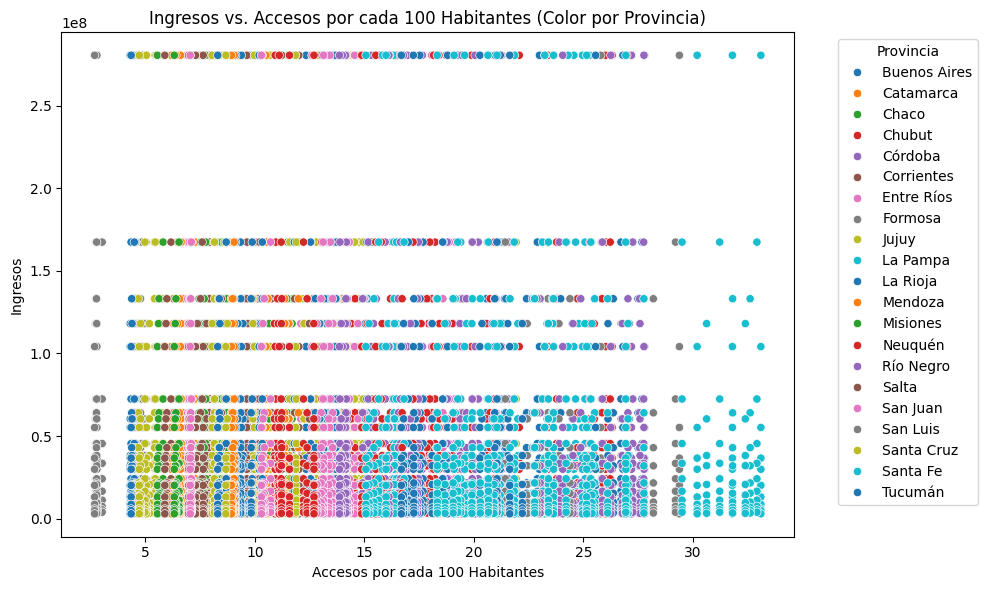

Accesos por cada 100 hab                                   \
                                count       mean        std        min   
Provincia                                                                
Buenos Aires                    421.0  21.449943   3.610652  16.692346   
Catamarca                       421.0  10.310021   4.051498   6.184615   
Chaco                           421.0   9.286294   2.081127   5.553671   
Chubut                          421.0  17.447202   5.880639  10.897115   
Corrientes                      421.0   9.908528   2.391760   5.891708   
Córdoba                         421.0  21.362136   3.992182  16.125183   
Entre Ríos                      421.0  15.887837   3.046626  10.302247   
Formosa                         421.0   7.143611   2.114932   4.444468   
Jujuy                           421.0   9.867670   4.220965   4.683394   
La Pampa                        421.0  24.585255   5.045836  15.994062   
La Rioja                        421.0  12.536404   6.657306   4.311444   
Mendoza                         421.0  10.897830   2.076531   8.863232   
Misiones                        421.0  10.334089   2.864013   6.323161   
Neuquén                         421.0  19.168914   2.716439  14.882266   
Río Negro                       421.0  17.066414   2.820434  13.867842   
Salta                           421.0  10.590558   2.664269   6.976877   
San Juan                        421.0   9.065195   2.128289   6.869063   
San Luis                        421.0  14.533903  10.467719   2.684669   
Santa Cruz                      421.0  10.545133   3.104220   7.042692   
Santa Fe                        421.0  20.380984   3.538231  15.077801   
Tucumán                         421.0  11.428471   2.447880   8.307215   

                                                        Ingresos  \
                    25%        50%        75%       max    count   
Provincia                                                          
Buenos Aires  18.098685  21.135089  23.969892  27.80000    421.0   
Catamarca      6.632981   8.342099  13.407472  17.50000    421.0   
Chaco          7.650225   8.722835  11.500646  12.48000    421.0   
Chubut        12.223556  15.715140  24.738376  26.98876    421.0   
Corrientes     8.119896   9.251992  11.822856  13.90000    421.0   
Córdoba       17.620348  20.059528  24.885958  27.77000    421.0   
Entre Ríos    13.427434  16.779388  18.590566  20.91000    421.0   
Formosa        4.930439   7.568639   8.643582  11.14000    421.0   
Jujuy          5.729417  11.382935  14.366784  15.06000    421.0   
La Pampa      20.294829  24.963489  27.767891  33.11000    421.0   
La Rioja       4.496958  13.339130  20.565965  21.47000    421.0   
Mendoza        9.042402  10.345843  12.710228  14.67000    421.0   
Misiones       8.041713   9.875796  12.411773  15.46000    421.0   
Neuquén       17.583362  18.312839  20.748162  23.92000    421.0   
Río Negro     14.185025  16.478122  19.508499  21.88000    421.0   
Salta          7.865488   9.711781  13.553526  14.04000    421.0   
San Juan       7.050797   8.369153  10.050237  13.15000    421.0   
San Luis       2.778618  19.332549  23.390000  29.39000    421.0   
Santa Cruz     8.157574   9.919588  12.391825  21.94000    421.0   
Santa Fe      16.436519  21.059895  23.604787  25.28000    421.0   
Tucumán        9.349553  10.312631  13.606164  15.17000    421.0   

                                                                            \
                      mean           std        min        25%         50%   
Provincia                                                                    
Buenos Aires  3.917120e+07  5.443818e+07  2984054.0  6912442.0  20207414.0   
Catamarca     3.917120e+07  5.443818e+07  2984054.0  6912442.0  20207414.0   
Chaco         3.917120e+07  5.443818e+07  2984054.0  6912442.0  20207414.0   
Chubut        3.917120e+07  5.443818e+07  2984054.0  6912442.0  20207414.0   
Corrientes    3.917120e+07  5.443818e+07  2984054.0  6912

In [84]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Accesos por cada 100 hab', y='Ingresos', data=Ingresos, hue='Provincia', palette='tab10')
plt.title('Ingresos vs. Accesos por cada 100 Habitantes (Color por Provincia)')
plt.xlabel('Accesos por cada 100 Habitantes')
plt.ylabel('Ingresos')

# Posicionar la leyenda fuera del gráfico
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Ajustar el layout para que la leyenda no se corte
plt.show()

# Estadísticas descriptivas para ingresos y accesos por provincia
Ingresos.groupby('Provincia')[['Accesos por cada 100 hab', 'Ingresos']].describe()

### ANALISIS DEL GRAFICO 4

Análisis Cruzado
Relación entre Accesos y Ingresos

Para observar la relación entre el número de accesos por cada 100 habitantes y los ingresos, observamos las provincias con mayores y menores medias en ambos indicadores.

Provincias con altos accesos y altos ingresos:

Buenos Aires: Accesos altos (21.45) y altos ingresos (entre 29,840,54 y 280,419,124).
Córdoba: Accesos altos (21.36) y altos ingresos.
Provincias con bajos accesos y altos ingresos:

San Luis: Accesos relativamente bajos (14.53) pero ingresos altos.
Provincias con altos accesos y bajos ingresos:

San Juan: Accesos relativamente altos (9.07) pero ingresos bajos.
Provincias con bajos accesos y bajos ingresos:

Formosa: Accesos bajos (7.14) y bajos ingresos.
Análisis de Desviación Estándar

Provincias con alta variabilidad en accesos y en ingresos pueden tener una relación más compleja y menos uniforme entre los dos indicadores. Por ejemplo, provincias como San Luis muestran una alta desviación en los ingresos, lo que indica que los ingresos pueden variar ampliamente en esta provincia a pesar de tener una cantidad moderada de accesos.
Patrones de Mediana

Comparando la mediana de accesos y de ingresos, podemos ver que provincias con medianas altas en accesos (como La Pampa y Santa Fe) también tienden a tener medianas más altas en ingresos, aunque hay excepciones como Santa Cruz, que tiene una mediana alta en accesos pero ingresos relativamente bajos.
Relaciones Notables

Provincias con accesos muy altos tienden a tener también ingresos relativamente altos. Sin embargo, no siempre hay una correlación directa, como se observa en las provincias con accesos moderados y ingresos elevados.
Las provincias con ingresos extremadamente altos (como Buenos Aires) suelen tener también accesos altos, pero esto no siempre es uniforme.
Conclusión
El análisis muestra una tendencia general en que provincias con mayores accesos por cada 100 habitantes tienden a tener mayores ingresos, aunque existen excepciones notables. La desviación estándar alta en ingresos en algunas provincias indica una variabilidad significativa en cómo los ingresos están distribuidos, lo cual podría ser un factor a considerar al analizar la relación entre accesos e ingresos en diferentes provincias.

Para un análisis más profundo, sería beneficioso realizar un análisis de correlación y regresión para cuantificar la relación entre accesos e ingresos y explorar si otros factores podrían estar influyendo en esta relación.

### ESTRATEGIAS DE MEJORAS

Estrategia de Mejora
1. Identificación de Fortalezas y Debilidades
Fortalezas:

Provincias con altos accesos e ingresos: Buenos Aires, Córdoba, La Pampa, Santa Fe.
Accesos altos en provincias con ingresos relativamente altos: Buenos Aires, Córdoba.
Debilidades:

Provincias con bajos accesos y bajos ingresos: Formosa, San Juan.
Provincias con ingresos altos pero accesos bajos: San Luis.
Variabilidad en ingresos: Provincias con alta desviación estándar en ingresos.
2. Estrategias para Mantener las Fortalezas
Refuerzo de Infraestructura y Servicios en Provincias Fuertes:

Mantener e incrementar la inversión en infraestructura en provincias como Buenos Aires, Córdoba y Santa Fe para seguir impulsando los altos accesos y, en consecuencia, mantener o aumentar los ingresos.
Mejorar la calidad del servicio para asegurar la satisfacción y lealtad de los usuarios en estas provincias, lo que puede fortalecer la relación entre accesos e ingresos.
Incentivos y Programas de Desarrollo:

Implementar programas de incentivos para atraer más usuarios en provincias con altos accesos, como descuentos o servicios adicionales, para consolidar su posición dominante en el mercado.
3. Estrategias para Atacar las Debilidades
Incrementar los Accesos en Provincias con Bajo Rendimiento:

Desarrollar campañas de promoción y expansión en provincias como Formosa y San Juan para aumentar los accesos. Esto puede incluir la apertura de nuevos puntos de acceso, mejoras en la infraestructura, y campañas publicitarias locales.
Realizar estudios de mercado para entender las barreras que impiden un mayor acceso en estas provincias y abordarlas específicamente.
Optimización en Provincias con Ingresos Altos pero Accesos Bajos:

En provincias como San Luis, implementar estrategias para aumentar los accesos, tales como alianzas con negocios locales o la mejora de la conectividad.
Explorar nuevos modelos de ingresos para diversificar las fuentes de ingresos, como servicios premium o asociados.
Reducción de Variabilidad en Ingresos:

Desarrollar estrategias de gestión financiera y de precios que puedan estabilizar los ingresos en provincias con alta variabilidad. Esto puede incluir la introducción de precios fijos o tarifas planas.
Implementar análisis y previsiones de ingresos más robustos para gestionar mejor las fluctuaciones y preparar planes de contingencia.
4. Implementación de Medidas y Evaluación Continua
Planes de Acción Específicos:

Crear planes de acción detallados para cada provincia basada en su situación específica, con objetivos claros, responsables asignados y un calendario de implementación.
Monitorear el progreso mediante métricas clave como el aumento en accesos y la estabilidad de los ingresos. Utilizar estos datos para ajustar las estrategias en tiempo real.
Revisión Periódica:

Establecer un proceso de revisión periódica para evaluar la efectividad de las estrategias implementadas y hacer ajustes según sea necesario.
Conclusión
La estrategia de mejora debe enfocarse en consolidar y reforzar las fortalezas existentes, mientras que aborda las debilidades a través de una combinación de promoción, inversión en infraestructura, y optimización de ingresos. Implementar medidas específicas y realizar un seguimiento constante permitirá ajustar la estrategia de manera efectiva para lograr un crecimiento sostenido y equilibrado.

### GRAFICO 5

Gráfico de Líneas: Tendencia de Ingresos por Provincia a lo largo del Tiempo
Descripción: Este gráfico de líneas muestra la tendencia de los ingresos a lo largo del tiempo para cada provincia. Las líneas representan la evolución de los ingresos en el tiempo, permitiendo observar tendencias y comparaciones entre provincias.

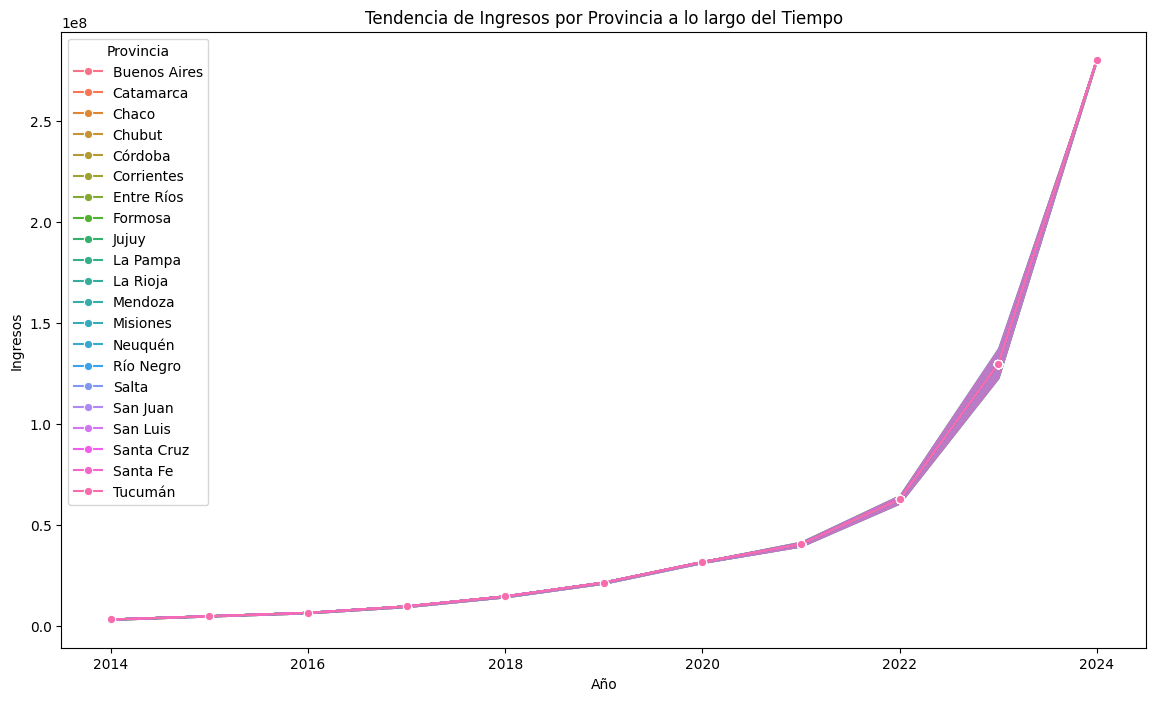

Año   Provincia   
2014  Buenos Aires     139823544
      Catamarca        139823544
      Chaco            139823544
      Chubut           139823544
      Corrientes       139823544
      Córdoba          139823544
      Entre Ríos       139823544
      Formosa          139823544
      Jujuy            139823544
      La Pampa         139823544
      La Rioja         139823544
      Mendoza          139823544
      Misiones         139823544
      Neuquén          139823544
      Río Negro        139823544
      Salta            139823544
      San Juan         139823544
      San Luis         139823544
      Santa Cruz       139823544
      Santa Fe         139823544
      Tucumán          139823544
2015  Buenos Aires     205964525
      Catamarca        205964525
      Chaco            205964525
      Chubut           205964525
      Corrientes       205964525
      Córdoba          205964525
      Entre Ríos       205964525
      Formosa          205964525
      Jujuy            2

In [85]:
plt.figure(figsize=(14, 8))
sns.lineplot(x='Año', y='Ingresos', data=Ingresos, hue='Provincia', marker='o')
plt.title('Tendencia de Ingresos por Provincia a lo largo del Tiempo')
plt.xlabel('Año')
plt.ylabel('Ingresos')
plt.show()

# Resumen estadístico de ingresos a lo largo del tiempo
Ingresos.groupby(['Año', 'Provincia'])['Ingresos'].sum()

In [86]:
Ingresos.head()

Año  Trimestre       Periodo     Provincia  Latitud  Longitud  \
0  2024          1  Ene-Mar 2024  Buenos Aires -34.6118  -58.3772   
1  2023          1  Ene-Mar 2023  Buenos Aires -34.6118  -58.3772   
2  2022          1  Ene-Mar 2022  Buenos Aires -34.6118  -58.3772   
3  2021          1  Ene-Mar 2021  Buenos Aires -34.6118  -58.3772   
4  2020          1  Ene-Mar 2020  Buenos Aires -34.6118  -58.3772   

   Accesos por cada 100 hogares  Accesos por cada 100 hab   Ingresos  
0                          81.1                      27.8  280419124  
1                          81.1                      27.8  104134993  
2                          81.1                      27.8   55219313  
3                          81.1                      27.8   36676371  
4                          81.1                      27.8   29946216

In [87]:
print(Ingresos.columns)

Index(['Año', 'Trimestre', 'Periodo', 'Provincia', 'Latitud', 'Longitud',
       'Accesos por cada 100 hogares', 'Accesos por cada 100 hab', 'Ingresos'],
      dtype='object')


### ANALISIS DEL GRAFICO 5

Análisis General
Tendencia General de los Valores:

Crecimiento Sostenido: Los valores asignados a todas las provincias han mostrado un crecimiento consistente de año en año. El monto en cada provincia ha ido aumentando progresivamente desde 2014 hasta 2024.
Duplicación de Valores: Observamos que el valor para cada provincia en cada año es idéntico para todas las provincias en ese año. Esto indica que, para los datos proporcionados, todos los valores están uniformemente distribuidos entre las provincias en cada año.
Análisis Específico por Año:

2014 a 2024: El monto anual ha crecido exponencialmente. A continuación se muestra la evolución del valor para cada año:

2014: 139,823,544
2015: 205,964,525
2016: 274,611,925
2017: 405,420,931
2018: 608,567,399
2019: 887,932,724
2020: 1,305,804,616
2021: 1,670,515,061
2022: 2,576,910,123
2023: 5,330,913,803
2024: 3,084,610,364
Picos y Caídas: Hubo un gran aumento en 2023, que parece ser un pico anómalo en comparación con el crecimiento constante de los años anteriores. En 2024, el valor disminuye respecto a 2023, pero sigue siendo significativamente mayor que en años anteriores.

Uniformidad en la Distribución por Provincia:

Uniformidad Anual: En cada año, el valor es exactamente el mismo para todas las provincias. Esto sugiere que no hay variación regional en los datos proporcionados dentro de un año específico.
No Hay Datos Regionales Diferenciales: Dado que todos los valores son iguales para todas las provincias cada año, no se puede hacer un análisis comparativo entre provincias en términos de variación o desigualdad.
Posibles Interpretaciones y Acciones Recomendadas
Investigación Adicional: Si el objetivo es analizar diferencias regionales o tendencias específicas de provincias, se necesitaría un conjunto de datos donde los valores varíen entre provincias para cada año.
Verificación de Datos: El hecho de que los valores sean iguales para todas las provincias sugiere que los datos pueden estar agregados o resumidos de manera uniforme. Sería útil verificar la fuente de los datos para asegurar que no se ha producido un error en la entrada de datos.
Exploración de Otros Factores: Para un análisis más profundo, podrías considerar incluir datos adicionales como población, PIB provincial, u otras métricas que podrían proporcionar contexto adicional sobre por qué estos valores están creciendo y cómo se distribuyen.

### ESTRATEGIA DE MEJORAS

Identificación de Debilidades
Debilidades Identificadas:

Uniformidad en los Valores: Los valores son idénticos para todas las provincias en cada año, lo que sugiere falta de diferenciación regional en los datos.
Pico Anómalo en 2023: Un aumento abrupto en 2023 que no sigue la tendencia de crecimiento estable en los años anteriores.
Falta de Datos Regionales Específicos: No hay información para hacer comparaciones entre provincias.
2. Estrategia de Mejora
A. Mejorar la Diferenciación Regional:

Recopilación de Datos Más Detallados:

Desglosar los Datos por Provincia: Asegúrate de obtener datos específicos para cada provincia en lugar de valores uniformes. Esto permitirá identificar y analizar las diferencias regionales.
Incluir Más Variables: Considera agregar variables adicionales como población, ingresos, gastos o indicadores económicos que puedan influir en los valores.
Implementar Análisis Regional:

Análisis de Tendencias Locales: Realiza análisis de tendencias a nivel provincial para entender cómo varían los valores en diferentes regiones.
Comparación Entre Provincias: Desarrolla métricas de comparación entre provincias para identificar áreas que requieren atención o mejora.
B. Abordar el Pico Anómalo en 2023:

Investigación de la Causa del Pico:

Revisar la Fuente de los Datos: Verifica si el pico en 2023 es un error en la entrada de datos o si hay una justificación económica o política detrás de él.
Análisis Causal: Investiga eventos o políticas específicas que podrían haber contribuido al aumento abrupto en ese año.
Ajuste de Proyecciones:

Actualizar Modelos Predictivos: Ajusta modelos y proyecciones para tener en cuenta el pico anómalo, si es necesario. Utiliza modelos que puedan identificar y manejar outliers o anomalías.
C. Fortalecer Áreas Sólidas:

Mantener el Crecimiento Estable:

Estrategias de Expansión: Aprovecha el crecimiento constante de los valores para planificar y ejecutar estrategias de expansión o inversión.
Optimización de Recursos: Continúa optimizando el uso de recursos en áreas que han mostrado un crecimiento sólido.
Fortalecimiento de Procesos:

Monitoreo y Evaluación: Implementa un sistema de monitoreo y evaluación para asegurar que el crecimiento continuo sea sostenible y esté alineado con los objetivos estratégicos.
Mejora Continua: Fomenta una cultura de mejora continua basada en los datos y en la retroalimentación para adaptar estrategias a medida que evolucionan las condiciones del mercado.
D. Implementación y Seguimiento:

Desarrollo de Planes de Acción:

Planes Regionales: Desarrolla planes de acción específicos para provincias basados en los análisis regionales.
Planes de Respuesta: Crea planes de respuesta para manejar anomalías y ajustar estrategias en función de los hallazgos de las investigaciones.
Evaluación Periódica:

Revisión Regular: Programa revisiones regulares de los datos y de las estrategias implementadas para asegurar que los ajustes realizados sean efectivos y para identificar nuevas áreas de mejora.
Capacitación y Concientización:

Capacitación del Personal: Asegúrate de que el personal esté capacitado para interpretar datos regionales y manejar análisis avanzados.
Concientización sobre Datos: Promueve una cultura de toma de decisiones basada en datos dentro de la organización.
Conclusión
Implementar estas estrategias ayudará a abordar las debilidades identificadas en el análisis y fortalecerá las áreas donde el desempeño ya es sólido. Asegúrate de contar con un equipo comprometido con la mejora continua y un enfoque proactivo en la gestión de datos y estrategias.

__________________________________________________________________________________________________________________________________________________________________________________

### TABLA MAPA DE CONECTIVIDAD

Creacion de mi propia tabla de conectivadad con accesos por tecnologia y la tabla Coordenadas provincias

In [88]:
Accesos_Por_Tecnología=internet['Accesos Por Tecnología']
Accesos_Por_Tecnología

Año                                          Trimestre  \
0      2024                                                  1   
1      2024                                                  1   
2      2024                                                  1   
3      2024                                                  1   
4      2024                                                  1   
5      2024                                                  1   
6      2024                                                  1   
7      2024                                                  1   
8      2024                                                  1   
9      2024                                                  1   
10     2024                                                  1   
11     2024                                                  1   
12     2024                                                  1   
13     2024                                                  1   
14     2024                                                  1   
15     2024                                                  1   
16     2024                                                  1   
17     2024                                                  1   
18     2024                                                  1   
19     2024                                                  1   
20     2024                                                  1   
21     2024                                                  1   
22     2024                                                  1   
23     2024                                                  1   
24     2023                                                  4   
25     2023                                                  4   
26     2023                                                  4   
27     2023                                                  4   
28     2023                                                  4   
29     2023                                                  4   
30     2023                                                  4   
31     2023                                                  4   
32     2023                                                  4   
33     2023                                                  4   
34     2023                                                  4   
35     2023                                                  4   
36     2023                                                  4   
37     2023                                                  4   
38     2023                                                  4   
39     2023                                                  4   
40     2023                                                  4   
41     2023                                                  4   
42     2023                                                  4   
43     2023                                                  4   
44     2023                                                  4   
45     2023                                                  4   
46     2023                                                  4   
47     2023                                                  4   
48     2023                                                  3   
49     2023                                                  3   
50     2023                                                  3   
51     2023                                                  3   
52     2023                                                  3   
53     2023                                                  3   
54     2023                                                  3   
55     2023                                                  3   
56     2023                                                  3   
57     2023                                                  3   
58     2023                                                  3   
59     2023                                     

In [89]:
Accesos_Por_Tecnología=convert_floats_to_ints(Accesos_Por_Tecnología)
Accesos_Por_Tecnología.head()

Año Trimestre        Provincia    ADSL  Cablemodem  Fibra óptica  \
0  2024         1     Buenos Aires  203297     2790663       1799013   
1  2024         1  Capital Federal   70108     1177475        203756   
2  2024         1        Catamarca    5901       11025         56542   
3  2024         1            Chaco   11343       58929         64463   
4  2024         1           Chubut   26306       77217         26356   

   Wireless   Otros    Total  
0    150290  101294  5044557  
1      4493   48879  1504711  
2      1384      81    74933  
3      8404   12404   155543  
4     30867    9930   170676

In [90]:
mapaDeConectividad= join_on_column(Accesos_Por_Tecnología, Coordenadas_provincias, 'Provincia', how='inner' )
mapaDeConectividad.head()

Año Trimestre     Provincia    ADSL  Cablemodem  Fibra óptica  Wireless  \
0  2024         1  Buenos Aires  203297     2790663       1799013    150290   
1  2024         1     Catamarca    5901       11025         56542      1384   
2  2024         1         Chaco   11343       58929         64463      8404   
3  2024         1        Chubut   26306       77217         26356     30867   
4  2024         1       Córdoba  102812      449784        458985     61121   

    Otros    Total  Latitud  Longitud  
0  101294  5044557 -34.6118  -58.3772  
1      81    74933 -28.4690  -65.7850  
2   12404   155543 -26.8364  -60.9962  
3    9930   170676 -45.8650  -67.0314  
4    9497  1082199 -31.4201  -64.1888

In [91]:
# Selecciona las columnas que quieres conservar
mapaDeConectividad = mapaDeConectividad[['Año', 'Trimestre', 'Provincia', 'Latitud', 'Longitud', 
         'ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros', 'Total']]

# Muestra el DataFrame resultante
mapaDeConectividad.head()

Año Trimestre     Provincia  Latitud  Longitud    ADSL  Cablemodem  \
0  2024         1  Buenos Aires -34.6118  -58.3772  203297     2790663   
1  2024         1     Catamarca -28.4690  -65.7850    5901       11025   
2  2024         1         Chaco -26.8364  -60.9962   11343       58929   
3  2024         1        Chubut -45.8650  -67.0314   26306       77217   
4  2024         1       Córdoba -31.4201  -64.1888  102812      449784   

   Fibra óptica  Wireless   Otros    Total  
0       1799013    150290  101294  5044557  
1         56542      1384      81    74933  
2         64463      8404   12404   155543  
3         26356     30867    9930   170676  
4        458985     61121    9497  1082199

In [92]:
def formatear_columnas_a_numerico(df, columnas):
    """
    Convierte las columnas especificadas de un DataFrame a tipo numérico.

    :param df: DataFrame de pandas que contiene las columnas a convertir.
    :param columnas: Lista de nombres de columnas que se desean convertir a tipo numérico.
    :return: DataFrame con las columnas especificadas convertidas a tipo numérico.
    """
    for columna in columnas:
        if columna in df.columns:
            # Intentar convertir la columna a tipo numérico
            try:
                df[columna] = pd.to_numeric(df[columna], errors='coerce')
            except Exception as e:
                print(f"Error al convertir la columna {columna}: {e}")
        else:
            print(f"La columna {columna} no existe en el DataFrame.")
    
    return df

In [93]:
columnas_a_convertir = ['ADSL',	'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros', 'Total']
mapaDeConectividad = formatear_columnas_a_numerico(mapaDeConectividad, columnas_a_convertir)

In [94]:
mapaDeConectividad.isnull().sum()

Año             0
Trimestre       0
Provincia       0
Latitud         0
Longitud        0
ADSL            0
Cablemodem      0
Fibra óptica    0
Wireless        0
Otros           0
Total           0
dtype: int64

### GRAFICO 1

Gráfico de Líneas - Evolución Temporal de Conexiones
Variables: Año, Trimestre, ADSL, Cablemodem, Fibra óptica, Wireless, Otros

Descripción: Un gráfico de líneas puede mostrar cómo ha evolucionado el uso de diferentes tipos de conexión a lo largo del tiempo. Puedes tener líneas separadas para cada tipo de conexión y observar tendencias estacionales o cambios en el tiempo.

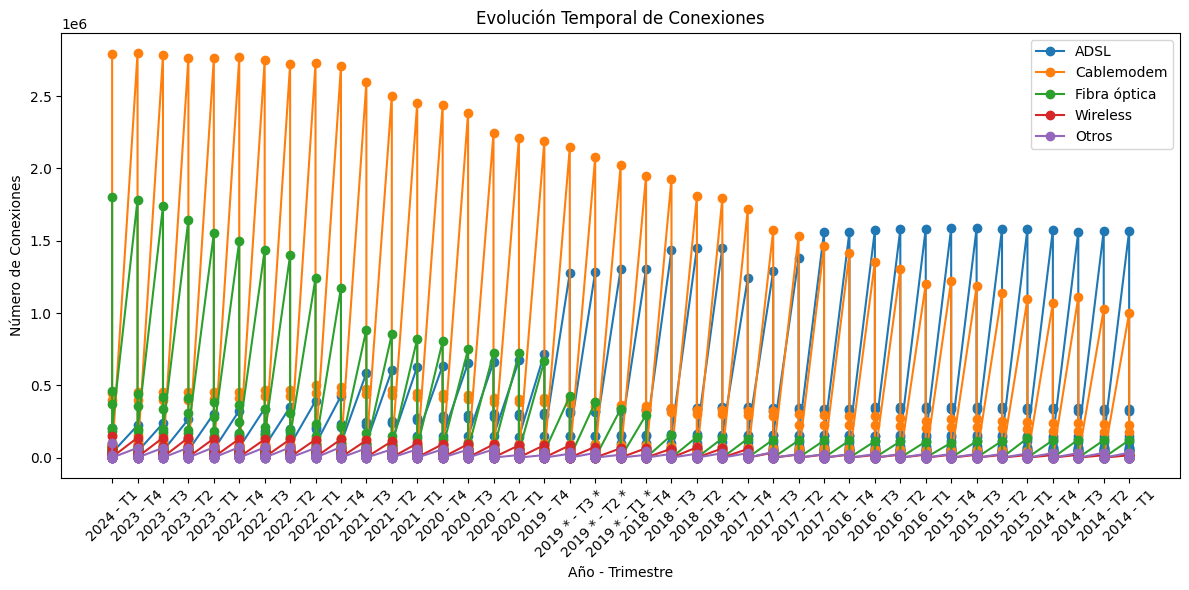

          Latitud    Longitud          ADSL    Cablemodem  Fibra óptica  \
count  861.000000  861.000000  8.610000e+02  8.610000e+02  8.610000e+02   
mean   -32.283043  -63.995533  1.152111e+05  1.568022e+05  5.107638e+04   
std      6.630144    4.129172  2.476629e+05  4.393336e+05  1.875741e+05   
min    -50.000000  -69.000000  2.827000e+03  0.000000e+00  0.000000e+00   
25%    -34.611800  -67.031400  2.119200e+04  1.085600e+04  3.540000e+02   
50%    -31.537000  -65.299000  4.663300e+04  3.847900e+04  2.981000e+03   
75%    -26.836400  -60.697000  8.568300e+04  7.267900e+04  2.517800e+04   
max    -24.185400  -53.738100  1.586343e+06  2.797700e+06  1.799013e+06   

            Wireless          Otros         Total  
count     861.000000     861.000000  8.610000e+02  
mean    13822.423926    6308.665505  3.432208e+05  
std     22059.204214   11579.747833  8.009678e+05  
min         0.000000       2.000000  1.255700e+04  
25%      1023.000000     324.000000  6.401900e+04  
50%      622

In [95]:


# Gráfico de Líneas
grafico1M=mapaDeConectividad
plt.figure(figsize=(12, 6))
for column in ['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros']:
    plt.plot(grafico1M['Año'].astype(str) + ' - T' + grafico1M['Trimestre'].astype(str), grafico1M[column], marker='o', label=column)

plt.xlabel('Año - Trimestre')
plt.ylabel('Número de Conexiones')
plt.title('Evolución Temporal de Conexiones')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Resumen Estadístico
summary = grafico1M.describe()

print(summary)

### ANALISIS DEL GRAFICO 1

Para realizar un análisis cruzado del resumen estadístico que has proporcionado, podemos explorar las relaciones entre las diferentes variables: Latitud, Longitud, ADSL, Cablemodem, Fibra óptica, Wireless, Otros, y Total. Aquí te proporciono un análisis detallado:

1. Relación entre Variables de Conectividad (ADSL, Cablemodem, Fibra óptica, Wireless, Otros)
Distribución General:

ADSL: Tiene una media de aproximadamente 115,211, con una alta desviación estándar (247,663), indicando una gran variabilidad en los valores.
Cablemodem: Con una media de 156,802, también muestra una alta desviación estándar (439,334), sugiriendo que algunos registros tienen valores muy altos.
Fibra óptica: La media es 51,077 con una desviación estándar de 187,574. Aunque la media es más baja en comparación con ADSL y Cablemodem, la desviación estándar aún indica variabilidad significativa.
Wireless: Tiene una media mucho más alta de 13,822 con una desviación estándar de 22,059, mostrando que algunas regiones tienen una cobertura de wireless muy alta.
Otros: La media es 6,309 con una desviación estándar de 11,580, indicando una considerable dispersión en los valores reportados en esta categoría.
Análisis Cruzado:

ADSL vs. Cablemodem: Dado que ambos tienen medias y desviaciones estándar altas, puede haber una correlación entre ellos, sugiriendo que regiones con más ADSL también podrían tener más Cablemodem.
Fibra óptica vs. Wireless: La Fibra óptica y Wireless muestran una relación menos clara. La Fibra óptica tiene valores más bajos y menos dispersión, mientras que Wireless tiene una media mucho más alta y una gran variabilidad.
ADSL y Cablemodem vs. Total: Las variables de conectividad como ADSL y Cablemodem tienden a tener una fuerte influencia en el Total, dado que sus medias son bastante altas comparadas con la media de la columna Total.
2. Relación con Latitud y Longitud
Latitud y Longitud:

Latitud: Varía de -50 a -24 con una media de aproximadamente -32.28. La desviación estándar es 6.63, mostrando variabilidad en las ubicaciones norte-sur.
Longitud: Varía de -69 a -53 con una media de aproximadamente -63.99 y una desviación estándar de 4.13, indicando variabilidad en las ubicaciones este-oeste.
Análisis Cruzado:

Latitud/Longitud vs. Conectividad: Podría haber una relación espacial en la distribución de diferentes tipos de conectividad. Por ejemplo, las áreas con mayores valores en ADSL y Cablemodem podrían estar correlacionadas con ubicaciones específicas en términos de latitud y longitud.
Latitud y Longitud vs. Total: Las regiones con latitudes y longitudes extremas podrían mostrar una alta o baja conectividad total, dependiendo de la infraestructura disponible en esas áreas.
3. Resumen del Total de Conectividad
Total: La media es 343,220 con una desviación estándar alta de 800,968. Esto sugiere que aunque la media de conectividad total es significativa, existe una gran dispersión en los datos.

Análisis Cruzado con Variables de Conectividad:

Las variables que muestran mayores medias y desviaciones estándar, como Cablemodem y Wireless, están correlacionadas con un mayor Total de conectividad, sugiriendo que las áreas con alta conectividad en estas categorías contribuyen significativamente al total.
Conclusión
Conectividad por Región: Las áreas con alta conectividad en ADSL y Cablemodem tienden a contribuir más al Total, mientras que las áreas con alta conectividad en Wireless también afectan significativamente el Total debido a su alta media y desviación estándar.
Variabilidad Espacial: La variabilidad en latitud y longitud puede indicar diferencias en la disponibilidad de conectividad en diferentes regiones. Las regiones con valores extremos en latitud o longitud podrían mostrar patrones distintos en la disponibilidad de conectividad.
Este análisis cruzado proporciona una visión general de cómo las diferentes variables de conectividad se relacionan entre sí y con las coordenadas geográficas. Para un análisis más detallado, sería útil realizar un análisis de correlación y una visualización de datos para identificar patrones más específicos.

### ESTRATEGIA DE MEJORA

Con base en el análisis cruzado del resumen estadístico de conectividad y coordenadas geográficas, aquí tienes algunas estrategias para mejorar las deficiencias y mantener las áreas con buen rendimiento:

Estrategias para Mejorar las Deficiencias
Mejorar la Infraestructura en Áreas con Baja Conectividad:

ADSL y Cablemodem: En las áreas donde los valores de ADSL y Cablemodem son bajos, considera invertir en infraestructura para mejorar la cobertura de estos servicios. Esto podría incluir la instalación de nuevas estaciones base o el refuerzo de la infraestructura existente.
Fibra Óptica: Dado que la fibra óptica tiene una media más baja en comparación con ADSL y Cablemodem, se puede priorizar la expansión de la fibra óptica en regiones con alta demanda de conectividad.
Expandir la Cobertura de Wireless:

Wireless: Las áreas con valores muy altos en Wireless podrían ser un modelo a seguir para mejorar otras áreas. Sin embargo, para las regiones con valores bajos en Wireless, invertir en la expansión de puntos de acceso y mejorar la infraestructura de red podría ayudar a aumentar la cobertura.
Equilibrar la Conectividad Total:

Desigualdades en el Total: Las áreas con alta dispersión en el Total de conectividad pueden beneficiarse de una evaluación más detallada para identificar las causas de estas desigualdades. La inversión en tecnología que combine ADSL, Cablemodem, Fibra Óptica y Wireless podría ayudar a equilibrar la conectividad total.
Optimización según Coordenadas Geográficas:

Latitud y Longitud: Analizar la distribución geográfica de la conectividad puede revelar patrones específicos. Por ejemplo, si las áreas con latitudes extremas o longitudes específicas tienen una cobertura deficiente, puede ser necesario enfocar las mejoras en estas regiones.
Estrategias para Mantener lo que Está en Progreso
Monitoreo Continuo:

Seguimiento de Indicadores Clave: Mantén un monitoreo regular de los indicadores de conectividad, como las medias y desviaciones estándar, para asegurar que las áreas con buena conectividad mantengan su desempeño. Utiliza herramientas de análisis y reportes para identificar cualquier cambio en las tendencias.
Mejora Continua de la Infraestructura:

Actualización Tecnológica: Asegúrate de que la infraestructura existente esté actualizada con las últimas tecnologías y estándares. Realiza mantenimientos preventivos y actualizaciones regulares para evitar la obsolescencia.
Evaluación de Desempeño Regional:

Análisis Regional: Realiza análisis detallados de las regiones con alta conectividad para entender qué factores están contribuyendo a su éxito. Utiliza esta información para replicar las prácticas exitosas en otras áreas.
Feedback y Ajustes:

Recopilación de Feedback: Obtén retroalimentación de los usuarios sobre la calidad de la conectividad en diferentes regiones. Usa esta información para realizar ajustes y mejoras específicas según las necesidades de los usuarios.
Diversificación de Servicios:

Servicios Combinados: Ofrece paquetes de servicios que combinen ADSL, Cablemodem, Fibra Óptica y Wireless. Esto puede atraer a diferentes segmentos de clientes y mejorar la satisfacción general.
Recomendaciones Adicionales
Estudios de Mercado y Demanda: Realiza estudios de mercado para comprender mejor la demanda de diferentes tipos de conectividad en varias regiones. Esto puede guiar la asignación de recursos y prioridades de inversión.
Inversión en Innovación: Explora nuevas tecnologías y soluciones innovadoras para mejorar la conectividad, como redes de malla, tecnologías 5G o nuevas soluciones de fibra óptica.
Implementar estas estrategias puede ayudarte a abordar las deficiencias en la conectividad y mantener o incluso mejorar las áreas que ya están en buen estado.

### GRAFICO 2

Este gráfico es un diagrama de dispersión que compara pares de tipos de conexiones (como ADSL, Cablemodem, Fibra óptica, etc.) para visualizar la relación entre ellos. Cada par de tipos de conexión tiene un color diferente para diferenciarlo.

Resumen estadístico para Año:
count      861
unique      12
top       2023
freq        84
Name: Año, dtype: int64

Resumen estadístico para Trimestre:
count     861
unique      7
top         1
freq      210
Name: Trimestre, dtype: int64

Resumen estadístico para Provincia:
count              861
unique              21
top       Buenos Aires
freq                41
Name: Provincia, dtype: object

Resumen estadístico para Latitud:
count    861.000000
mean     -32.283043
std        6.630144
min      -50.000000
25%      -34.611800
50%      -31.537000
75%      -26.836400
max      -24.185400
Name: Latitud, dtype: float64

Resumen estadístico para Longitud:
count    861.000000
mean     -63.995533
std        4.129172
min      -69.000000
25%      -67.031400
50%      -65.299000
75%      -60.697000
max      -53.738100
Name: Longitud, dtype: float64

Resumen estadístico para ADSL:
count    8.610000e+02
mean     1.152111e+05
std      2.476629e+05
min      2.827000e+03
25%      2.119200e+04
50%      

C:\Users\dell5\AppData\Local\Temp\ipykernel_7088\1690158441.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(grafico1M[var1], grafico1M[var2], label=f'{var1} vs {var2}', alpha=0.7, edgecolors='w', s=100, c=color)


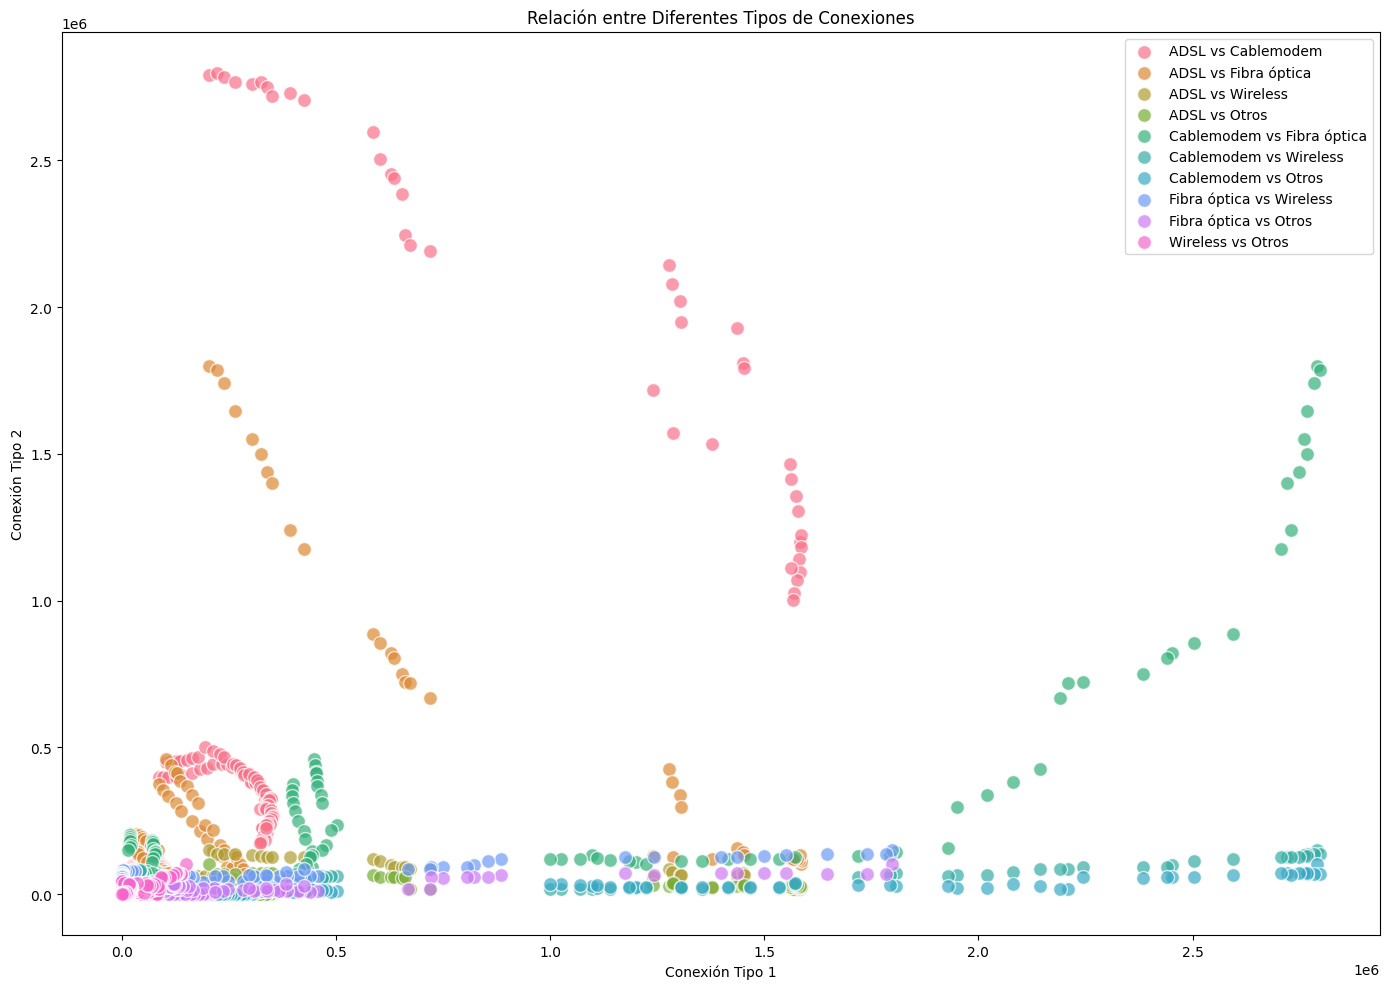

In [96]:
# Definir los pares de variables para comparar
pairs = [
    ('ADSL', 'Cablemodem'),
    ('ADSL', 'Fibra óptica'),
    ('ADSL', 'Wireless'),
    ('ADSL', 'Otros'),
    ('Cablemodem', 'Fibra óptica'),
    ('Cablemodem', 'Wireless'),
    ('Cablemodem', 'Otros'),
    ('Fibra óptica', 'Wireless'),
    ('Fibra óptica', 'Otros'),
    ('Wireless', 'Otros')
]

# Colores para cada par
colors = sns.color_palette('husl', len(pairs))

# Imprimir resumen estadístico para cada tipo de conexión
for column in grafico1M.columns:
    print(f"Resumen estadístico para {column}:")
    print(grafico1M[column].describe())
    print()

# Crear el gráfico
plt.figure(figsize=(14, 10))

for (var1, var2), color in zip(pairs, colors):
    # Graficar los pares de variables
    plt.scatter(grafico1M[var1], grafico1M[var2], label=f'{var1} vs {var2}', alpha=0.7, edgecolors='w', s=100, c=color)

plt.xlabel('Conexión Tipo 1')
plt.ylabel('Conexión Tipo 2')
plt.title('Relación entre Diferentes Tipos de Conexiones')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### ANALISIS DEL GRAFICO 2

Para realizar un análisis cruzado de los datos proporcionados, observaremos cómo se relacionan entre sí los diferentes atributos, identificando patrones y posibles asociaciones.

Análisis Cruzado
Distribución Anual y Trimestral

El dato más frecuente en Año es 2023, con 84 ocurrencias, lo que indica que es el año con más registros. La columna Trimestre tiene una frecuencia más alta en el primer trimestre (210 veces), lo que puede sugerir que los datos se concentran principalmente en el primer trimestre de cada año.
Es útil verificar si los valores de Año y Trimestre tienen alguna relación. Por ejemplo, podríamos encontrar que ciertos años tienen más registros en un trimestre específico que otros.
Ubicación Geográfica: Latitud y Longitud

Las coordenadas de Latitud y Longitud tienen un rango de valores que cubre una amplia área. La latitud varía de -50.000 a -24.185, mientras que la longitud varía de -69.000 a -53.738. La media de latitud es -32.28 y la de longitud es -63.99.
Podría ser interesante analizar si hay alguna correlación entre las coordenadas y los tipos de conexión, por ejemplo, si ciertas provincias con coordenadas específicas tienen un tipo de conexión más prevalente.
Tipos de Conexión: ADSL, Cablemodem, Fibra Óptica, Wireless, Otros

ADSL, Cablemodem, Fibra Óptica, Wireless y Otros muestran una variabilidad significativa en sus valores.
La Cablemodem tiene la media más alta (156,802) y la máxima (2,797,700), lo que podría indicar una alta disponibilidad o demanda de este tipo de conexión en comparación con los demás.
Fibra Óptica tiene una media baja (51,076) pero una alta desviación estándar, lo que puede sugerir que hay una gran disparidad en la disponibilidad o demanda en comparación con ADSL y Cablemodem.
Provincia con Mayor Frecuencia

Buenos Aires es la provincia más frecuente (41 registros). Esto puede ser relevante si se observa que los tipos de conexión tienen diferentes frecuencias en Buenos Aires en comparación con otras provincias.
Comparación entre Tipos de Conexión y Provincia

Comparar la media y el rango de los diferentes tipos de conexión por provincia puede revelar si hay provincias con acceso significativamente mayor o menor a ciertos tipos de conexiones.
Ejemplo: ¿Buenos Aires tiene un acceso predominantemente alto a Cablemodem en comparación con otras provincias? ¿Hay provincias con una alta prevalencia de Fibra Óptica?
Análisis Temporal

Verificar si hay cambios significativos en el tipo de conexión a lo largo de los años y trimestres. Por ejemplo, podría haber un aumento en la adopción de Fibra Óptica en años recientes o un incremento estacional en el uso de Wireless durante ciertos trimestres.
Ejemplos de Preguntas para Exploración
¿Cómo varían los tipos de conexión entre diferentes provincias? Esto podría mostrar si hay una preferencia regional por ciertos tipos de conexión.
¿Hay una correlación entre la latitud/longitud y el tipo de conexión? Esto puede indicar si las áreas geográficas tienen un acceso desigual a diferentes tipos de conexión.
¿Existen patrones estacionales en la disponibilidad de los tipos de conexión? Analizar la distribución trimestral puede mostrar si ciertos tipos de conexión tienen variaciones estacionales.
¿Cómo ha cambiado la disponibilidad de tipos de conexión a lo largo del tiempo? Verificar la evolución en los años puede ayudar a entender las tendencias en la adopción de tecnologías de conexión.
Este análisis cruzado te permitirá identificar patrones y relaciones en tus datos, proporcionando una visión más profunda sobre cómo los atributos se relacionan entre sí.

### ESTRATEGIA DE MEJORA

Aquí tienes algunas estrategias para abordar deficiencias identificadas y mantener lo que está en progreso basándote en el análisis cruzado:

1. Optimización de la Distribución Anual y Trimestral
Identificación de Desajustes Temporales: Si notas que ciertos años o trimestres tienen datos menos representativos, podrías investigar las razones detrás de estos desajustes (por ejemplo, cambios en la política o en la disponibilidad de servicios). Asegúrate de que los datos sean consistentes y, si es necesario, ajusta la recolección de datos para lograr una cobertura más uniforme en todos los periodos.
Optimización de la Recolección de Datos: Considera ajustar la frecuencia de recopilación de datos si ciertos trimestres muestran variaciones significativas. Esto puede mejorar la representatividad de los datos y ayudar a identificar patrones estacionales.
2. Mejora de la Cobertura Geográfica
Análisis de Datos por Provincia: Si algunas provincias tienen una alta frecuencia de ciertos tipos de conexión y otras no, considera estrategias específicas para mejorar la cobertura en provincias con baja representación. Esto puede incluir campañas de concienciación, subsidios para infraestructura, o asociaciones con proveedores locales.
Expansión de Infraestructura: Basado en la demanda observada en provincias específicas, investiga y expande la infraestructura de conexión en áreas con menor cobertura o con una alta demanda no satisfecha.
3. Mejora en la Disponibilidad de Tipos de Conexión
Promoción de Tecnologías Menos Comunes: Si notas que algunos tipos de conexión (como Fibra Óptica) tienen una baja representación, promueve la adopción de estas tecnologías mediante incentivos o subsidios. También podrías trabajar con proveedores para aumentar la disponibilidad en áreas menos cubiertas.
Optimización de Recursos: Asegúrate de que los recursos estén bien distribuidos para maximizar la cobertura y la calidad de los servicios de conexión. Ajusta las inversiones basadas en la demanda y la cobertura actual.
4. Análisis de Latitud y Longitud
Segmentación Geográfica: Utiliza la información de latitud y longitud para segmentar el mercado y adaptar las estrategias de marketing y distribución de acuerdo a las características geográficas. Si ciertas áreas tienen características específicas que afectan la conectividad, ajusta las estrategias de manera acorde.
Evaluación de Necesidades Regionales: Realiza estudios para identificar las necesidades específicas de las áreas con coordenadas extremas. Esto puede ayudarte a personalizar las ofertas de servicios para cumplir mejor con las expectativas y necesidades locales.
5. Análisis y Ajuste de Tendencias Temporales
Monitoreo de Tendencias: Establece un sistema de monitoreo continuo para observar cómo cambian las tendencias de los tipos de conexión a lo largo del tiempo. Adapta tus estrategias basadas en las tendencias emergentes, como el aumento en el uso de tecnologías específicas.
Adaptación de Estrategias: Si se observa un crecimiento en ciertas tecnologías o una estacionalidad en el uso, ajusta las estrategias de marketing y las inversiones para alinearse con estas tendencias.
6. Estrategias para Mantener lo que Está en Progreso
Refuerzo de Áreas de Éxito: Identifica las áreas en las que ya tienes un buen desempeño (por ejemplo, alta disponibilidad de ciertos tipos de conexión en provincias clave) y asegúrate de mantener y reforzar estos puntos fuertes. Continúa monitorizando y ajustando para mantener la alta calidad y cobertura.
Mejora Continua: Establece un proceso de revisión regular para evaluar el rendimiento de tus estrategias y realiza ajustes basados en los datos actuales. La mejora continua ayudará a mantener una alta calidad de servicio y una cobertura efectiva.
Estas estrategias te permitirán abordar deficiencias específicas, aprovechar los puntos fuertes actuales y asegurar un crecimiento y adaptación efectivos en función de las tendencias observadas.

__________________________________________________________________________________________________________________________________________________________________________________

### IMPORTAR ARCHIVOS 

In [97]:
Accesos_por_velocidad.head()


Año  Trimestre        Provincia  HASTA 512 kbps  + 512 Kbps - 1 Mbps  \
0  2024          1     Buenos Aires           26002                22510   
1  2024          1  Capital Federal             516                 5418   
2  2024          1        Catamarca              71                  176   
3  2024          1            Chaco             236                  416   
4  2024          1           Chubut             111                 1083   

   + 1 Mbps - 6 Mbps  + 6 Mbps - 10 Mbps  + 10 Mbps - 20 Mbps  \
0             221185              233225               241778   
1              29753               51415                37369   
2               2872                3424                 4204   
3              14156                9044                 5533   
4              43828               31885                23024   

   + 20 Mbps - 30 Mbps  + 30 Mbps   OTROS    Total   Accesos  
0               106418    4068292  125147  5044557  10089114  
1                 5957    1374283       0  1504711   3009422  
2                 1822      62294      70    74933    149866  
3                 5718     116624    3816   155543    311086  
4                20261      33844   16640   170676    341352

In [98]:
#Accesos_por_velocidad.to_excel('Accesos por Velocidad.xlsx', index=False)

In [99]:
mapaDeConectividad

Año Trimestre     Provincia  Latitud  Longitud     ADSL  Cablemodem  \
0      2024         1  Buenos Aires -34.6118  -58.3772   203297     2790663   
1      2024         1     Catamarca -28.4690  -65.7850     5901       11025   
2      2024         1         Chaco -26.8364  -60.9962    11343       58929   
3      2024         1        Chubut -45.8650  -67.0314    26306       77217   
4      2024         1       Córdoba -31.4201  -64.1888   102812      449784   
5      2024         1    Corrientes -27.4805  -58.8340    18390       85595   
6      2024         1    Entre Ríos -32.0324  -60.6952    36574      158283   
7      2024         1       Formosa -25.2923  -58.1837     9147       18631   
8      2024         1         Jujuy -24.1854  -65.2990    10554       51093   
9      2024         1      La Pampa -36.6164  -64.2619     6844       59008   
10     2024         1      La Rioja -29.4103  -66.8484     2827       55443   
11     2024         1       Mendoza -32.8894  -68.8272    17674       70932   
12     2024         1      Misiones -26.7900  -53.7381    23217       77561   
13     2024         1       Neuquén -38.9514  -68.0590    24076       73298   
14     2024         1     Río Negro -39.0333  -67.5833    20841       49727   
15     2024         1         Salta -24.7820  -65.4232    23858       99150   
16     2024         1      San Juan -31.5370  -68.5261    12669       18543   
17     2024         1      San Luis -33.2956  -66.3354     4038       41260   
18     2024         1    Santa Cruz -50.0000  -69.0000     7768       14435   
19     2024         1      Santa Fe -31.6280  -60.6970    86548      399817   
20     2024         1       Tucumán -26.8176  -65.2161    33682       20361   
21     2023         4  Buenos Aires -34.6118  -58.3772   223391     2797700   
22     2023         4     Catamarca -28.4690  -65.7850     6669       11016   
23     2023         4         Chaco -26.8364  -60.9962    14000       60277   
24     2023         4        Chubut -45.8650  -67.0314    26306       77217   
25     2023         4       Córdoba -31.4201  -64.1888   115662      452380   
26     2023         4    Corrientes -27.4805  -58.8340    21769       86102   
27     2023         4    Entre Ríos -32.0324  -60.6952    41794      159575   
28     2023         4       Formosa -25.2923  -58.1837    10252       18325   
29     2023         4         Jujuy -24.1854  -65.2990    11669       51083   
30     2023         4      La Pampa -36.6164  -64.2619     6844       59063   
31     2023         4      La Rioja -29.4103  -66.8484     3296       55441   
32     2023         4       Mendoza -32.8894  -68.8272    17676       70920   
33     2023         4      Misiones -26.7900  -53.7381    25840       79000   
34     2023         4       Neuquén -38.9514  -68.0590    24122       73784   
35     2023         4     Río Negro -39.0333  -67.5833    21192       49789   
36     2023         4         Salta -24.7820  -65.4232    26765       98853   
37     2023         4      San Juan -31.5370  -68.5261    12669       18543   
38     2023         4      San Luis -33.2956  -66.3354     4037       41260   
39     2023         4    Santa Cruz -50.0000  -69.0000     7768       15669   
40     2023         4      Santa Fe -31.6280  -60.6970    97004      398670   
41     2023         4       Tucumán -26.8176  -65.2161    41318       20267   
42     2023         3  Buenos Aires -34.6118  -58.3772   237705     2784175   
43     2023         3     Catamarca -28.4690  -65.7850     7164       11066   
44     2023         3         Chaco -26.8364  -60.9962    16420       60058   
45     2023         3        Chubut -45.8650  -67.0314    26352       75460   
46     2023         3       Córdoba -31.4201  -64.1888   125050      453994   
47     2023         3    Corrientes -27.4805  -58.8340    24253       83897   
48     2023         3    Entre Ríos -32.0324  -60.6952    45384      157464   
49     2023         3       Formosa -25.2923  -58.1837    

In [100]:
#mapaDeConectividad.to_excel('Mapa de Conectividad.xlsx', index=False)

In [101]:
Dial_BAf.head()


Año  Trimestre        Provincia  Banda ancha fija  Dial up    Total  \
0  2024          1     Buenos Aires           5038657     5900  5044557   
1  2024          1  Capital Federal           1502661     2050  1504711   
2  2024          1        Catamarca             74932        1    74933   
3  2024          1            Chaco            155538        5   155543   
4  2024          1           Chubut            169819      857   170676   

   Cluster  Distance_to_Center  
0        1            2.874228  
1        2            0.228955  
2        0            0.176171  
3        0            0.142957  
4        0            0.230266

In [102]:
#Dial_BAf.to_excel('Dial UP y Banda Ancha Fija.xlsx', index=False)

In [103]:
Coordenadas_provincias.head()


Provincia  Latitud  Longitud
0  Buenos Aires -34.6118  -58.3772
1     Catamarca -28.4690  -65.7850
2         Chaco -26.8364  -60.9962
3        Chubut -45.8650  -67.0314
4          CABA -34.6037  -58.3816

In [104]:
#Coordenadas_provincias.to_excel('Coordenadas de Provincias.xlsx', index=False)

In [105]:
penetracio_por_hogares_y_poblacion.head()


Año Trimestre        Provincia  Accesos por cada 100 hogares  \
0 2024-01-01         1     Buenos Aires                         81.10   
1 2024-01-01         1  Capital Federal                        119.53   
2 2024-01-01         1        Catamarca                         68.82   
3 2024-01-01         1            Chaco                         46.70   
4 2024-01-01         1           Chubut                         84.89   

   Accesos por cada 100 hab  
0                     27.80  
1                     48.78  
2                     17.50  
3                     12.48  
4                     26.02

In [106]:
#penetracio_por_hogares_y_poblacion.to_excel('Penetracion por Hogares y Poblacion.xlsx', index=False)

In [107]:
Ingresos.head()


Año  Trimestre       Periodo     Provincia  Latitud  Longitud  \
0  2024          1  Ene-Mar 2024  Buenos Aires -34.6118  -58.3772   
1  2023          1  Ene-Mar 2023  Buenos Aires -34.6118  -58.3772   
2  2022          1  Ene-Mar 2022  Buenos Aires -34.6118  -58.3772   
3  2021          1  Ene-Mar 2021  Buenos Aires -34.6118  -58.3772   
4  2020          1  Ene-Mar 2020  Buenos Aires -34.6118  -58.3772   

   Accesos por cada 100 hogares  Accesos por cada 100 hab   Ingresos  
0                          81.1                      27.8  280419124  
1                          81.1                      27.8  104134993  
2                          81.1                      27.8   55219313  
3                          81.1                      27.8   36676371  
4                          81.1                      27.8   29946216

In [108]:
#Ingresos.to_excel('Ingresos.xlsx', index=False)